In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.metrics import SparseCategoricalCrossentropy, Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Параметри для експериментів

Запропоновані в домашці:
- кількість шарів;
- кількість нейронів;
- функції активації;
- кількість епох;
- розмір батчу;
- вибір оптимізатора;
- різні техніки регуляризації і т.д.

Додатково слід розглянути вплив перемішування на результати роботи моделі:
- перемішування "з коробки";
- пакет (вибірка) має репрезентувати датасет (популяцію), тобто, якщо у нас в датасеті перший клас складає 10%, то і в кожному пакеті він має бути представленим 10%.

Для чистоти екперименту слід підготувати перемішані набори заздалегідь, а не перемішувати перед кожним прогоном

# ПОПЕРЕДЖЕННЯ

Ноутбук виконується декілька годин, тож або вірте написаному, або заплануйте якусь паралельну роботу

In [2]:
# Завантаження даних
(train_X, train_Y), (test_X, test_Y) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Підготовка даних

В моделі ми будемо використовувати шари Dense, які на вході очікують масив, а не матрицю. Дану проблему можна вирішити, додавши шар Flattern на вході, або ж здійснити попередню підготовку даних безпосередньо в ноутбуці, або ж в класі Dataset. 

Також бажано нормалізувати вхідні дані. Це завдання може бути виконано для всього масиву на вході діленням на 255, так і додаванням шару нормалізації на вході моделі. В нашому випадку застосуємо перший варіант.

Також на етапі підготовки слід перетворити масив категорій у матрицю, адже ми будемо працювати з категоріальними метриками. Зазвичай цю задачу варто виконувати на вході, однак ми будемо проводити деякі експерименти з пакетами, тож це перетворення буде відбуватись в датасеті



In [8]:
(train_len, train_dim_1, train_dim_2) = train_X.shape

train_X = train_X.reshape(train_len, train_dim_1 * train_dim_2)
test_X = test_X.reshape(len(test_X), train_dim_1 * train_dim_2)

train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [29]:
train_X = train_X.astype("float32")
test_X = test_X.astype("float32")

train_X /=255.
test_X /=255.

test_Y = tf.one_hot(test_Y, 10)

In [19]:
# Зафіксуємо сіди, щоб наступні вибірки були стабільні

SEEDS = [
    838726177,
 3049246437,
 1325552272,
 3358301288,
 761429700,
 1905312321,
 2689303359,
 725966248,
 2591264909,
 2924421902,
 2232487821,
 3058713305,
 2692650260,
 355959646,
 1467950649,
 2181226481,
 4261138877,
 3532537319,
 1638793723,
 2737004893,
 528309456,
 2541179092,
 2885553981,
 264040215,
 39022697,
 148417819,
 1144242918,
 2439007715,
 3163941325,
 12502175
]



Створимо допоміжні класи:

1. Датасет
2. Генератор моделей
3. Вивід історії навчання

In [20]:
class MyDataset(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size = 256, stratyfy = False, seeds = []):
        self.X = X
        self.y = y
        self.batches = []
        self.batch_size = batch_size
        self.stratyfy = stratyfy
        self.current_epoch = -1 # стане нулем при першій підготовці даних для епохи
        self.seeds = SEEDS if len(seeds) == 0 else seeds
        self.n_epochs = len(self.seeds)
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, index):
        return self.batches[index][0], tf.one_hot(self.batches[index][1], 10)  
    
    def on_epoch_end(self):
        self.current_epoch += 1
        if self.current_epoch == self.n_epochs:
            self.current_epoch = 0
            # Заганяємо в цикл
        curr_seed = self.seeds[self.current_epoch]
        self.batches = []
        
        X_to_split = self.X.copy()
        Y_to_split = self.y.copy()

        while len(X_to_split) > self.batch_size:
            if self.stratyfy:
                X_to_split, curr_batch_X, Y_to_split, curr_batch_Y = train_test_split(X_to_split, Y_to_split, test_size=self.batch_size, random_state=curr_seed, shuffle=True, stratify=Y_to_split)
            else:
                X_to_split, curr_batch_X, Y_to_split, curr_batch_Y = train_test_split(X_to_split, Y_to_split, test_size=self.batch_size, random_state=curr_seed, shuffle=True)
            
            self.batches.append((curr_batch_X, curr_batch_Y))
        
        if len(X_to_split) > 0:
            self.batches.append((X_to_split, Y_to_split))

In [25]:
ds = MyDataset(train_X, train_Y, 10000, True)

for i in range(len(ds)):
    cur_x, cur_y = ds[i]
    print(cur_y.numpy().sum(axis=0))
    print(cur_x.sum())

# Ікси різні і рівномірно представлені в пакетах

[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2243055.5
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2252947.2
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2248499.2
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2243180.8
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2232727.8
[1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
2234937.5


In [70]:
def create_model(layers=[], optimizer = SGD, lr=0.01):
    model = Sequential()

    if len(layers) == 0:
        model.add(Dense(512, "relu", input_shape=(28*28,)))
        model.add(Dense(256, "relu"))
        model.add(Dense(128, "relu"))
    
    else:
        for layer in layers:
            model.add(layer)
    
    model.add(Dense(10, activation="softmax"))

    model.compile(optimizer=optimizer(learning_rate=lr), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    return model

def fit_model(model:tf.keras.models.Sequential, fit_dataset, val_dataset, epochs=30, verbose=0, add_early_stopping = False, add_save = False):
    callbacks = []

    if add_early_stopping:
        callback_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="categorical_accuracy", mode="max", verbose=verbose, patience=3)
        callbacks.append(callback_early_stopping)
    
    if add_save:
        callback_save = tf.keras.callbacks.ModelCheckpoint(filepath="best_model", save_best_only=True, verbose=verbose)
        callbacks.append(callback_save)

    history = model.fit(fit_dataset, validation_data=val_dataset, epochs=epochs, verbose=verbose, callbacks=callbacks)
    return history

def present_histiry(title, history_data):
    figure, axis = plt.subplots(ncols=2, figsize=(15, 5))

    axis[0].plot(history_data.history["loss"], label="train loss")
    axis[0].plot(history_data.history["val_loss"], label="valid loss")
    # axis[0].title(title + ": loss")
    axis[0].grid()
    axis[0].legend()
    #plt.show()

    axis[1].plot(history_data.history["categorical_accuracy"], label="train accuracy")
    axis[1].plot(history_data.history["val_categorical_accuracy"], label="valid accuracy")
    # axis[1].title(title + ": accuracy")
    axis[1].grid()
    axis[1].legend()

    figure.suptitle(title + f" max val accuracy {max(history_data.history['val_categorical_accuracy'])}")
    
    plt.show()


Створимо базову модель та виведемо її результати

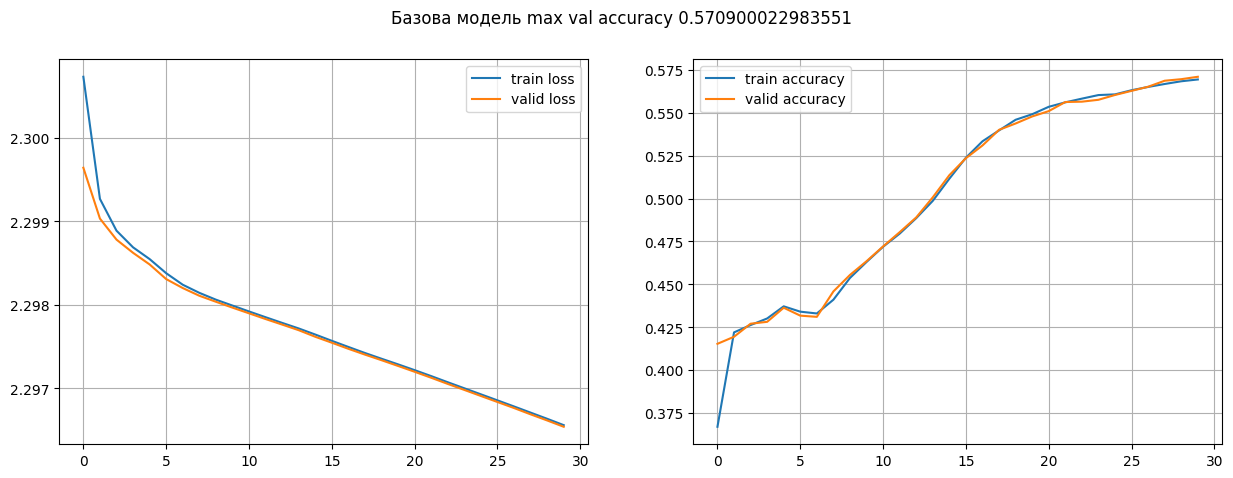

In [36]:
base_ds = MyDataset(train_X, train_Y, 1000, True)
base_model = create_model()
base_history = fit_model(base_model, base_ds, (test_X, test_Y))
present_histiry("Базова модель", base_history)

Результати роботи базової моделі виявились геть незадовільні:

1. Криві втрат та точності не вийшли на плато
3. Після 30 епох точність менше 60%

Змінимо оптимізатор

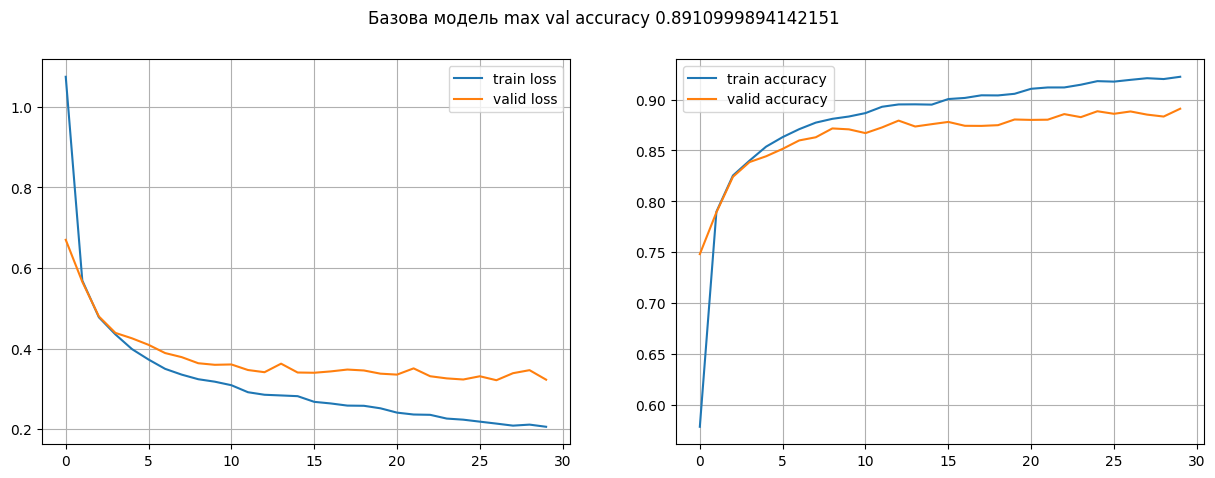

In [37]:
base_ds = MyDataset(train_X, train_Y, 1000, True)
base_model = create_model(optimizer=Adam)
base_history = fit_model(base_model, base_ds, (test_X, test_Y))
present_histiry("Базова модель", base_history)

Використання Adam дало суттєвий приріст:

1. Точність моделі виросла до майже 90 відсотків
2. Криві втрат і точності візуально вийшли на плато, тож скорше за все модель на 30 епохах досягає межі навчання
3. Попередня гіпотеза опосередковано підтверджується ще й тим, що криві валідаційних втрат та валідаційної точності почали коливатись та погіршувати свої значення, що свідчить про ризик перенавчання моделі

Отже, про SGD поки що забудемо, приймемо модель з оптимізатором Adam за базову

# Тест 1: зміна кількості шарів у моделі

1. Додамо 2 шари
2. Видалимо 1 шар

Epoch 1/30
60/60 [==============================] - 3s 40ms/step - loss: 1.2532 - categorical_accuracy: 0.4852 - val_loss: 0.8081 - val_categorical_accuracy: 0.6867
Epoch 2/30
60/60 [==============================] - 2s 37ms/step - loss: 0.6699 - categorical_accuracy: 0.7452 - val_loss: 0.6064 - val_categorical_accuracy: 0.7744
Epoch 3/30
60/60 [==============================] - 2s 38ms/step - loss: 0.5227 - categorical_accuracy: 0.8058 - val_loss: 0.4833 - val_categorical_accuracy: 0.8246
Epoch 4/30
60/60 [==============================] - 3s 43ms/step - loss: 0.4427 - categorical_accuracy: 0.8385 - val_loss: 0.4363 - val_categorical_accuracy: 0.8410
Epoch 5/30
60/60 [==============================] - 3s 48ms/step - loss: 0.3959 - categorical_accuracy: 0.8557 - val_loss: 0.4122 - val_categorical_accuracy: 0.8473
Epoch 6/30
60/60 [==============================] - 3s 46ms/step - loss: 0.3764 - categorical_accuracy: 0.8628 - val_loss: 0.4055 - val_categorical_accuracy: 0.8547
Epoch 7/30

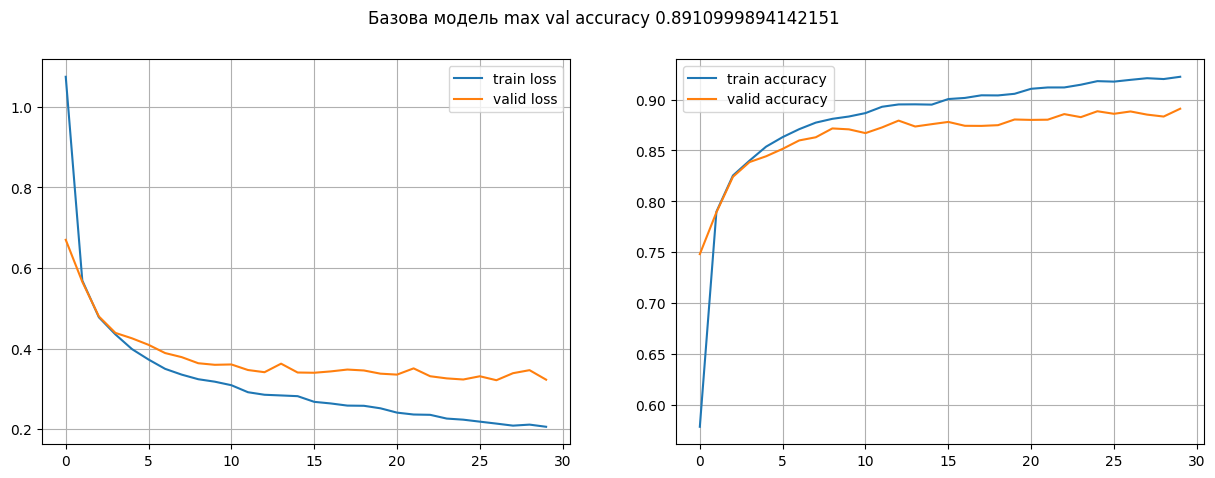

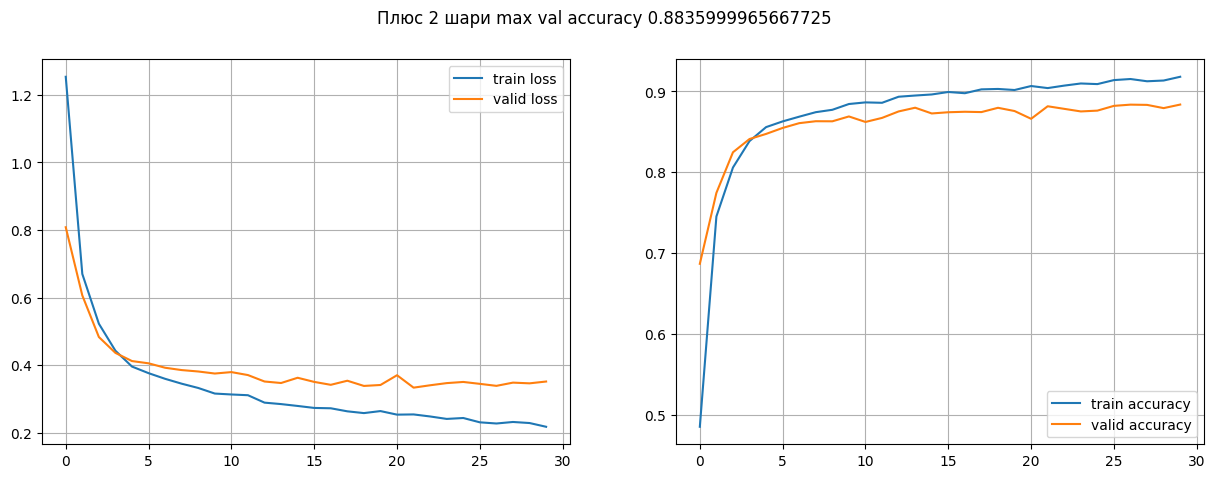

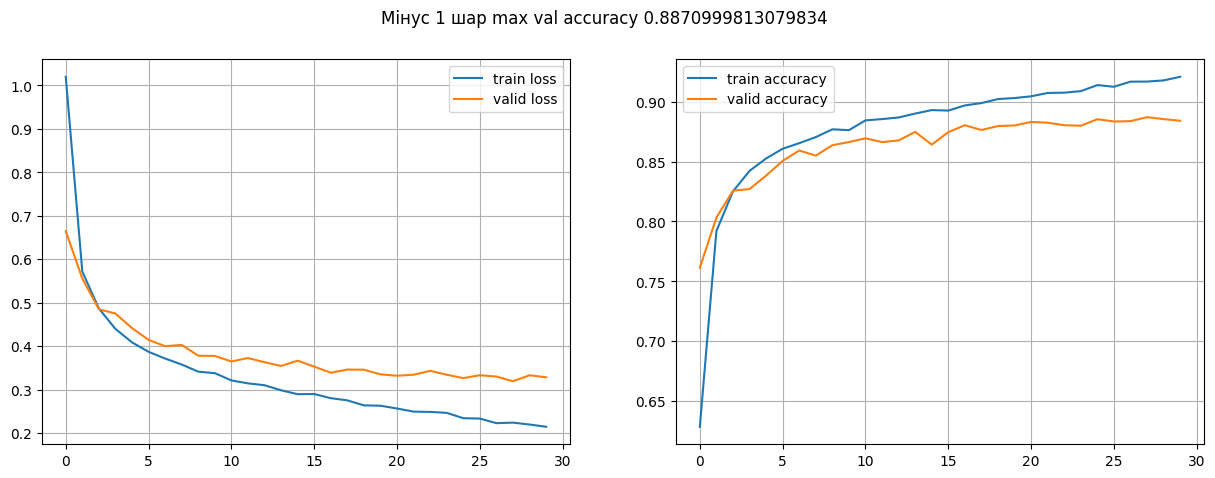

In [39]:
layers_plus_2 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dense(256, "relu"),
    Dense(256, "relu"),
    Dense(128, "relu"),
    Dense(64, "relu")
]

layers_minus_1 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dense(128, "relu")
]

model_plus_2 = create_model(optimizer=Adam, layers=layers_plus_2)
history_plus_2 = fit_model(model_plus_2, base_ds, (test_X, test_Y), verbose=True)

model_minus_1 = create_model(optimizer=Adam, layers=layers_minus_1)
history_minus_1 = fit_model(model_minus_1, base_ds, (test_X, test_Y), verbose=True)

present_histiry("Базова модель", base_history)
present_histiry("Плюс 2 шари", history_plus_2)
present_histiry("Мінус 1 шар", history_minus_1)


На диво, базова модель виявилась найбільш близькою до оптимальної:

1. Зміни в кількості шарів не показали кращих результатів по точності
2. З огляду на криві навчання (валідаційні втрати та валідаційна точність) запропоновані моделі не мають потенціалу до навчання


# Тест 2: зміна кількості нейронів у шарах

1. Збільшимо кількість нейронів вдвічи
2. Зменшимо кількість нейронів

Epoch 1/30
60/60 [==============================] - 5s 71ms/step - loss: 1.0070 - categorical_accuracy: 0.6077 - val_loss: 0.5911 - val_categorical_accuracy: 0.7779
Epoch 2/30
60/60 [==============================] - 4s 66ms/step - loss: 0.5051 - categorical_accuracy: 0.8142 - val_loss: 0.4894 - val_categorical_accuracy: 0.8213
Epoch 3/30
60/60 [==============================] - 5s 85ms/step - loss: 0.4194 - categorical_accuracy: 0.8447 - val_loss: 0.4302 - val_categorical_accuracy: 0.8444
Epoch 4/30
60/60 [==============================] - 5s 85ms/step - loss: 0.3788 - categorical_accuracy: 0.8593 - val_loss: 0.4221 - val_categorical_accuracy: 0.8436
Epoch 5/30
60/60 [==============================] - 5s 88ms/step - loss: 0.3578 - categorical_accuracy: 0.8681 - val_loss: 0.4082 - val_categorical_accuracy: 0.8473
Epoch 6/30
60/60 [==============================] - 5s 84ms/step - loss: 0.3284 - categorical_accuracy: 0.8783 - val_loss: 0.3656 - val_categorical_accuracy: 0.8663
Epoch 7/30

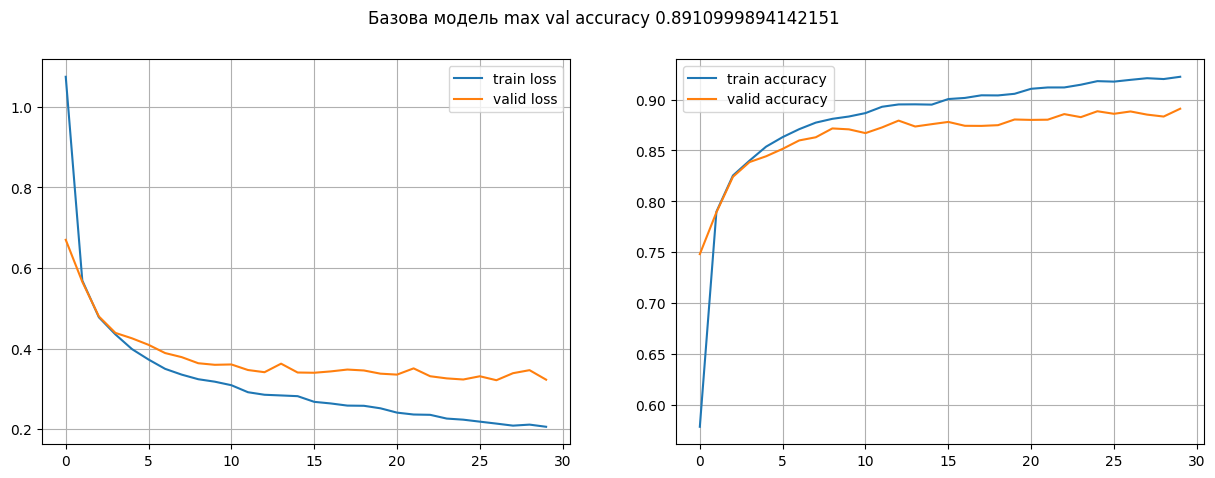

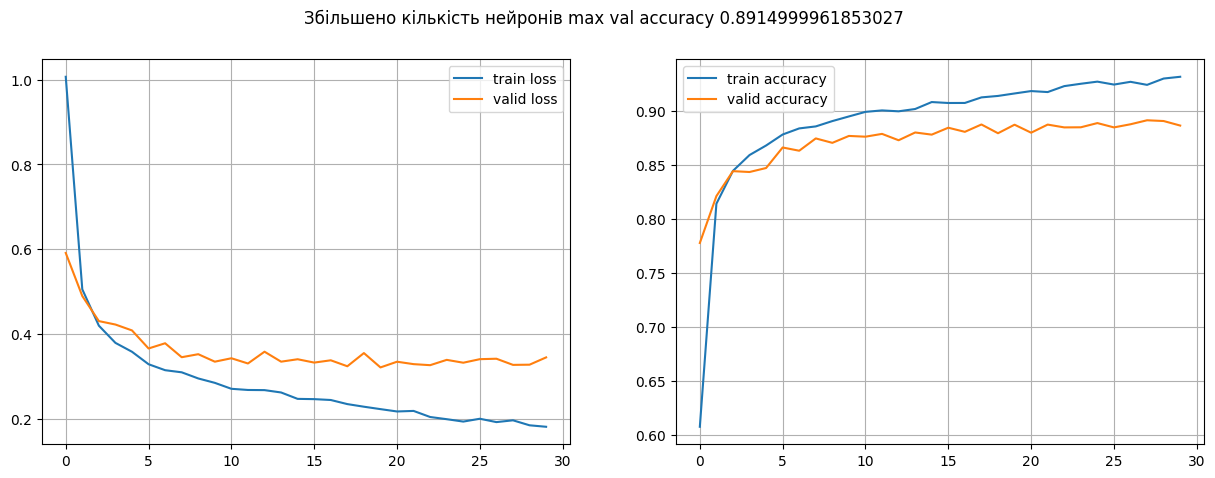

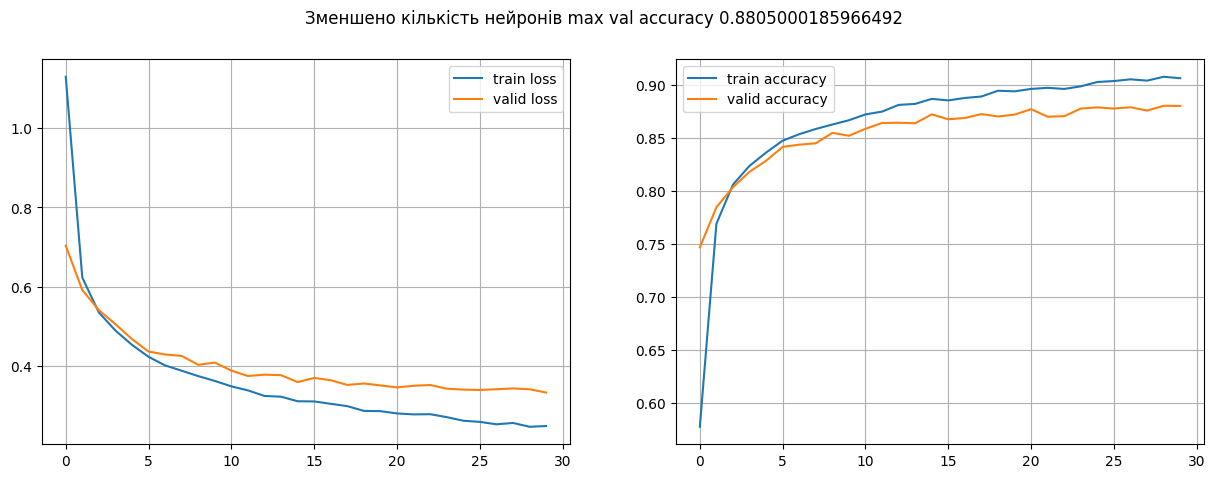

In [41]:
layers_x2 = [
    Dense(1024, "relu", input_shape=(28*28,)),
    Dense(512, "relu"),
    Dense(256, "relu")
]

layers_d2 = [
    Dense(256, "relu", input_shape=(28*28,)),
    Dense(128, "relu"),
    Dense(64, "relu")
]

model_x2 = create_model(optimizer=Adam, layers=layers_x2)
history_x2 = fit_model(model_x2, base_ds, (test_X, test_Y), verbose=True)

model_d2 = create_model(optimizer=Adam, layers=layers_d2)
history_d2 = fit_model(model_d2, base_ds, (test_X, test_Y), verbose=True)

present_histiry("Базова модель", base_history)
present_histiry("Збільшено кількість нейронів", history_x2)
present_histiry("Зменшено кількість нейронів", history_d2)


Модель зі збільшеною кількістю нейронів вииявилась на долі відсотків кращою за базову

# Тест 3: функції активації

1. Сигмоїд
2. Гіперболічний тангенс



Epoch 1/30
60/60 [==============================] - 3s 39ms/step - loss: 2.3510 - categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_categorical_accuracy: 0.1000
Epoch 2/30
60/60 [==============================] - 2s 35ms/step - loss: 2.3024 - categorical_accuracy: 0.1144 - val_loss: 2.3016 - val_categorical_accuracy: 0.1444
Epoch 3/30
60/60 [==============================] - 2s 37ms/step - loss: 2.1606 - categorical_accuracy: 0.1881 - val_loss: 1.7506 - val_categorical_accuracy: 0.2226
Epoch 4/30
60/60 [==============================] - 2s 35ms/step - loss: 1.6122 - categorical_accuracy: 0.2905 - val_loss: 1.5050 - val_categorical_accuracy: 0.3378
Epoch 5/30
60/60 [==============================] - 2s 35ms/step - loss: 1.3458 - categorical_accuracy: 0.4278 - val_loss: 1.1662 - val_categorical_accuracy: 0.5237
Epoch 6/30
60/60 [==============================] - 2s 39ms/step - loss: 1.0604 - categorical_accuracy: 0.5677 - val_loss: 0.9848 - val_categorical_accuracy: 0.5832
Epoch 7/30

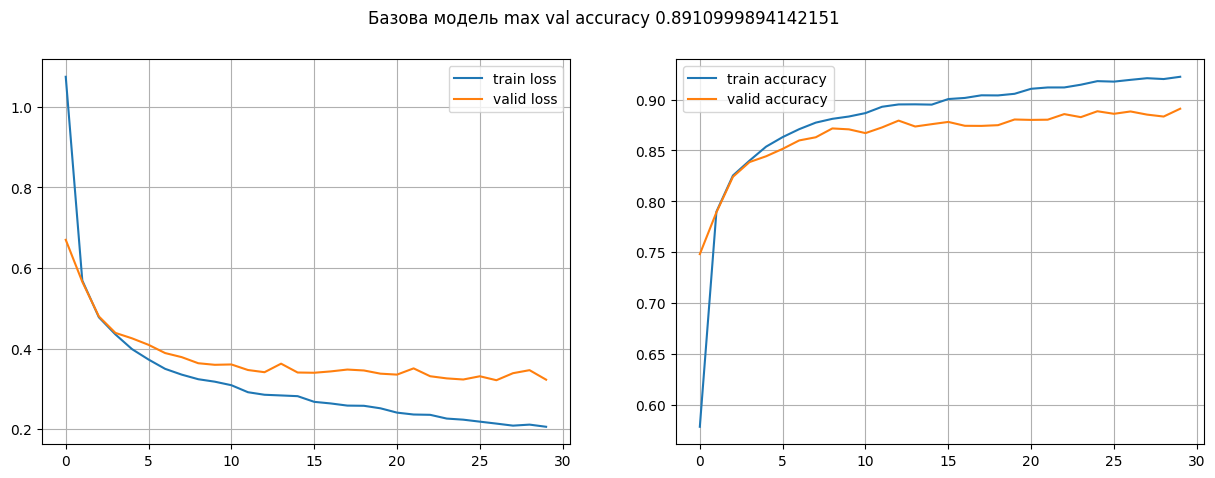

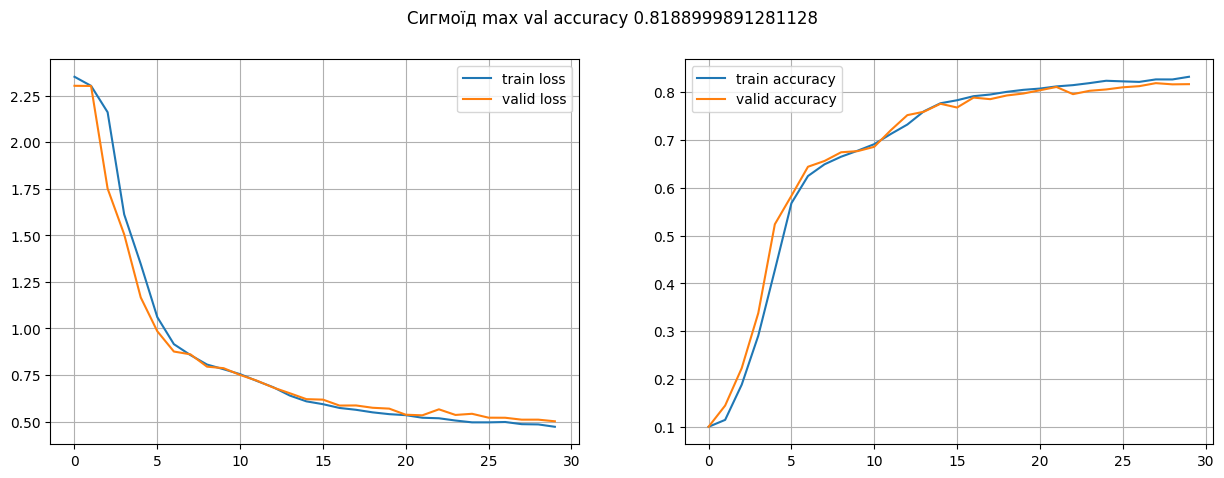

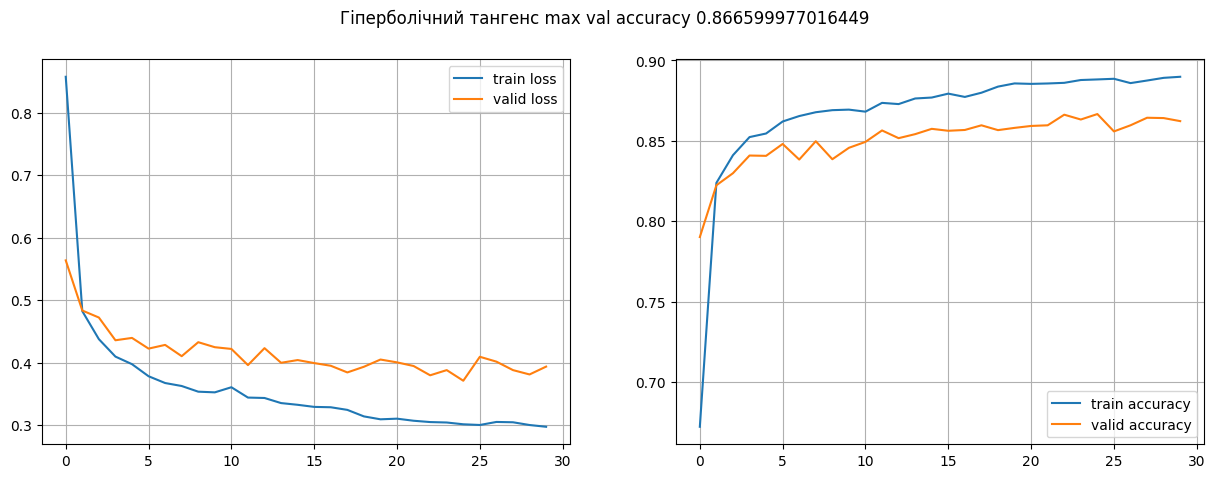

In [42]:
layers_sig = [
    Dense(512, "sigmoid", input_shape=(28*28,)),
    Dense(256, "sigmoid"),
    Dense(128, "sigmoid")
]

layers_tanh = [
    Dense(512, "tanh", input_shape=(28*28,)),
    Dense(256, "tanh"),
    Dense(128, "tanh")
]

model_sig = create_model(optimizer=Adam, layers=layers_sig)
history_sig = fit_model(model_sig, base_ds, (test_X, test_Y), verbose=True)

model_tanh = create_model(optimizer=Adam, layers=layers_tanh)
history_tanh = fit_model(model_tanh, base_ds, (test_X, test_Y), verbose=True)

present_histiry("Базова модель", base_history)
present_histiry("Сигмоїд", history_sig)
present_histiry("Гіперболічний тангенс", history_tanh)


Для вирішення конкретної задачі сигмоїд та гіперболічний тангенс підходять менше, ніж RELU.

Варто зауважити, що в даній задачі модель з сигмоїдом почала вчитись з гірших показників, але вперто покращувалась, і, здавалось, вона зможе показати кращий результат, але 30 епох виявилось досить, щоб навчання досягло межі

# Тест 4: кількість епох

Тут дозволю одразу підійти до висновків на базі попередніх тестів.

Зі збільшенням кількості епох показники втрат і точності по навчальним даним досить стало збільшуються і, не виключено, можуть дійти до ідеальних значень (нуль втрат, 100% точність). Однак по валідаційним даним ці показники в якийсь момент досягають межі і далі погіршуються. Це свідчить про початок перенавчання моделі.

В даній задачі 30 епох достатньо, адже всі попередні моделі проходили межу плато і починали перенавчатись.

Вважаю, що доброю практикою буде задавити кількість епох з запасом і паралельно ставити запобіжник у вигляді раннього зупину у випадку, коли протягом N епох значення метрик не покращуються

# Тест 5: розмір пакету

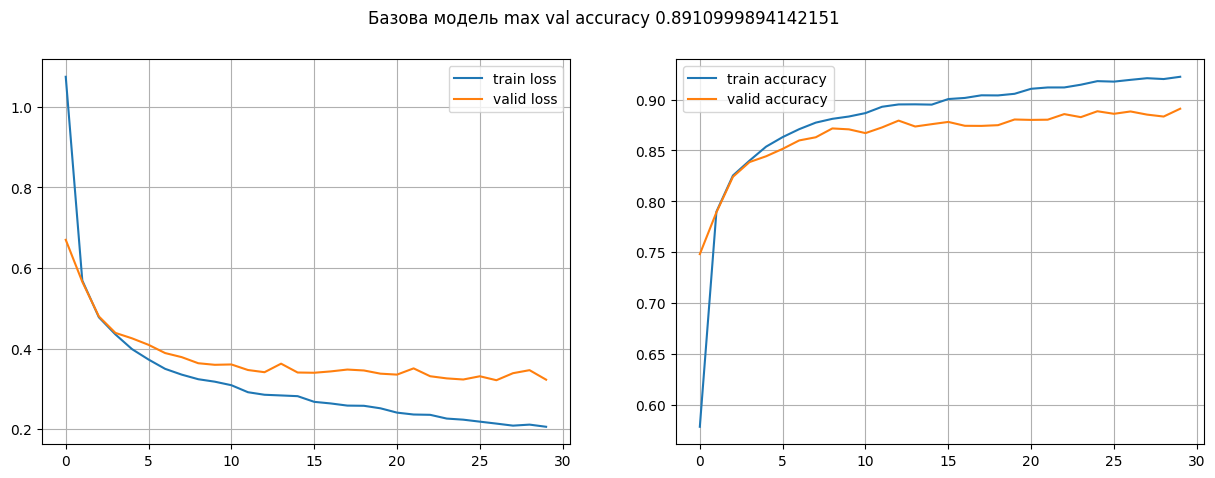

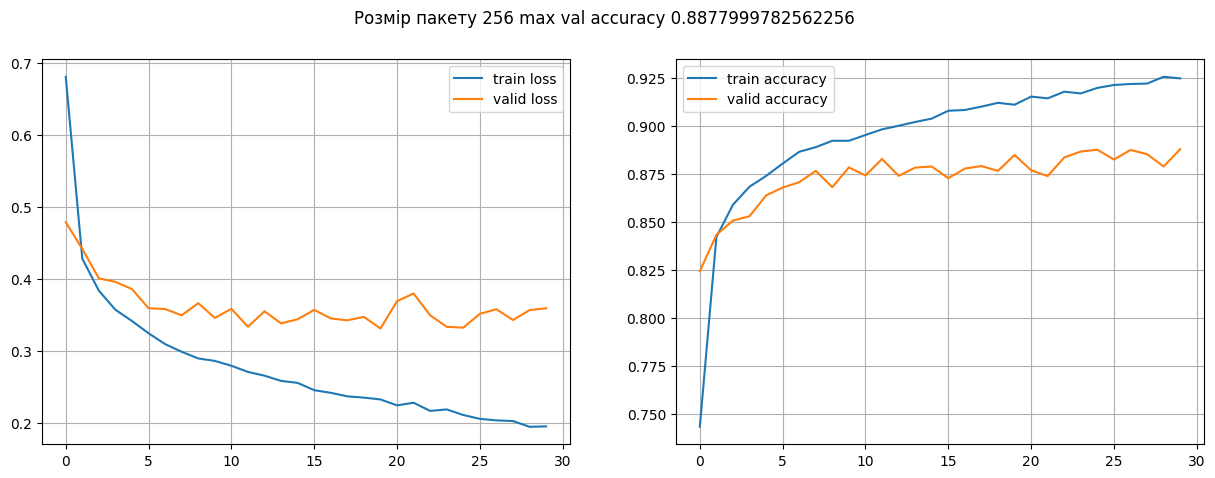

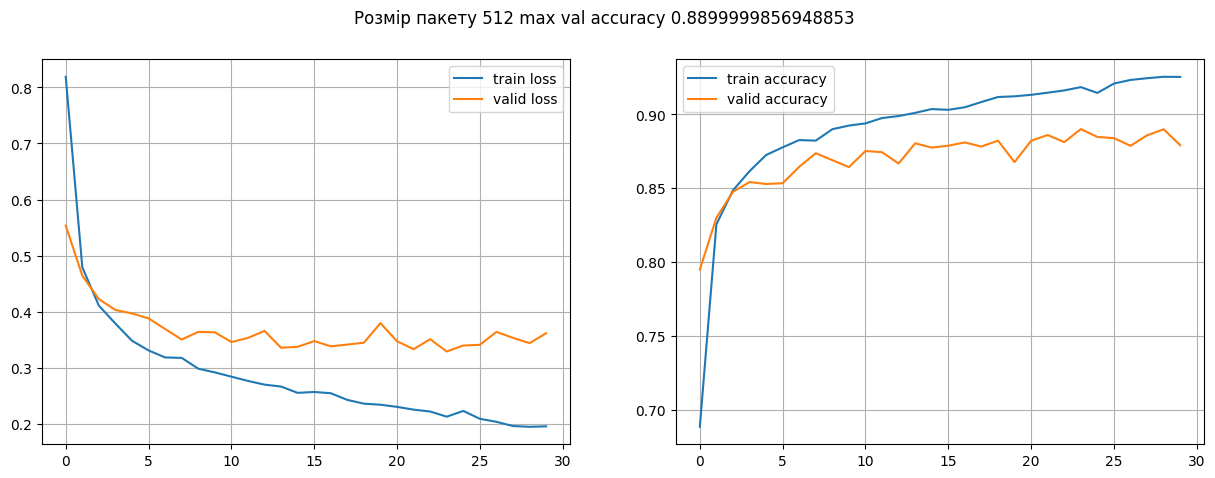

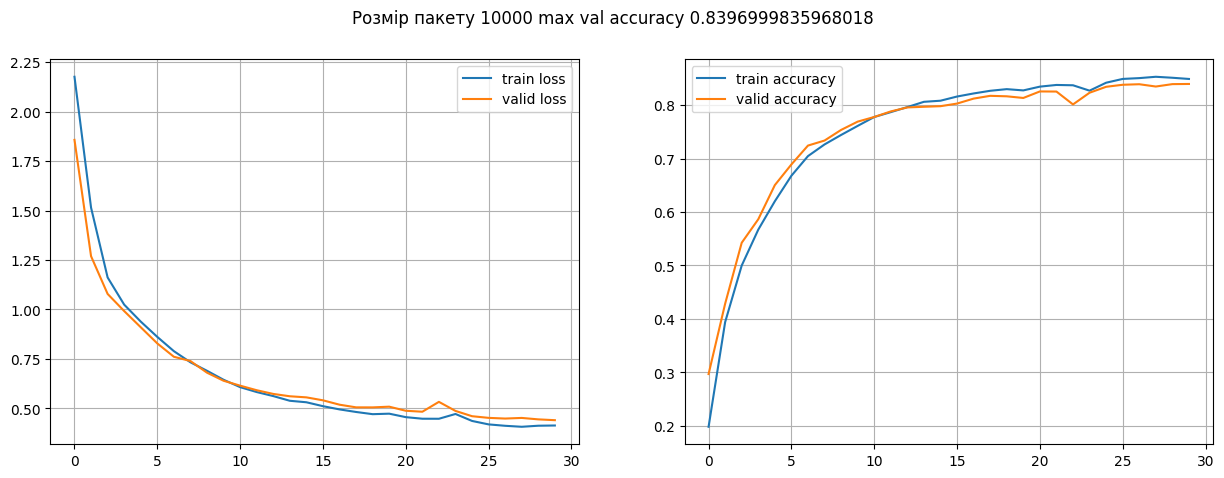

In [44]:
batch_sizes = [256, 512, 10000]

present_histiry("Базова модель", base_history)

for batch_size in batch_sizes:
    cur_model = create_model(optimizer=Adam)
    cur_ds = MyDataset(train_X, train_Y, batch_size, True)
    cur_history = fit_model(cur_model, cur_ds, (test_X, test_Y), verbose=False)
    present_histiry(f"Розмір пакету {batch_size}", cur_history)

Висновки

1. При зменшенні розміру пакету (дані стратифіковані) навчання починається з кращих показників по втратам і точності
2. При зменшенні розміру пакету амплітуда коливань показників навчання на валідаційних даних вища, що змушує засумніватися в достатньості кількості епох
3. Жоден з альтернативних розмірів пакетів не показав кращих результатів, ніж базовий
4. Криві втрат і точності по тренувальним та валідаційним даним ближчі, якщо розмір пакету більший

Даний дослід проводився на стратифікованих даних і поставив під сумнів достатність кількості епох. Трохи змінимо умови екперименту: не будемо стратифікувати дані та збільшимо кількість епох до 60

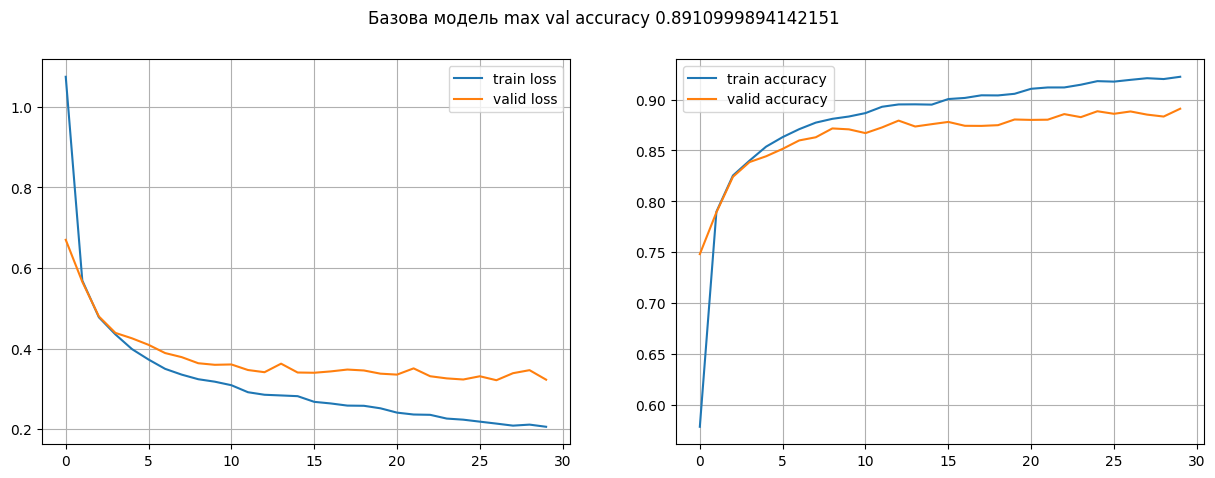

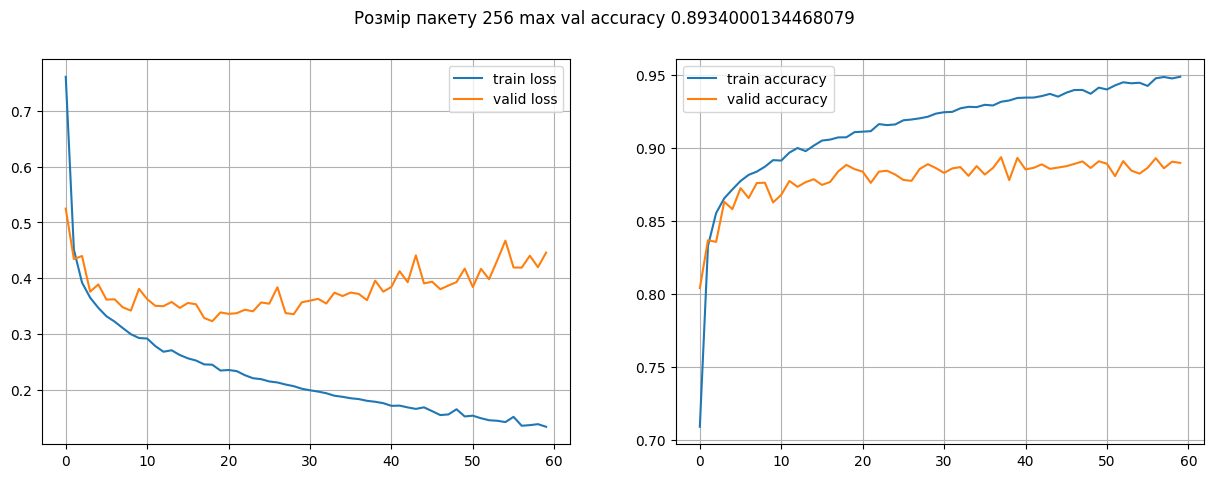

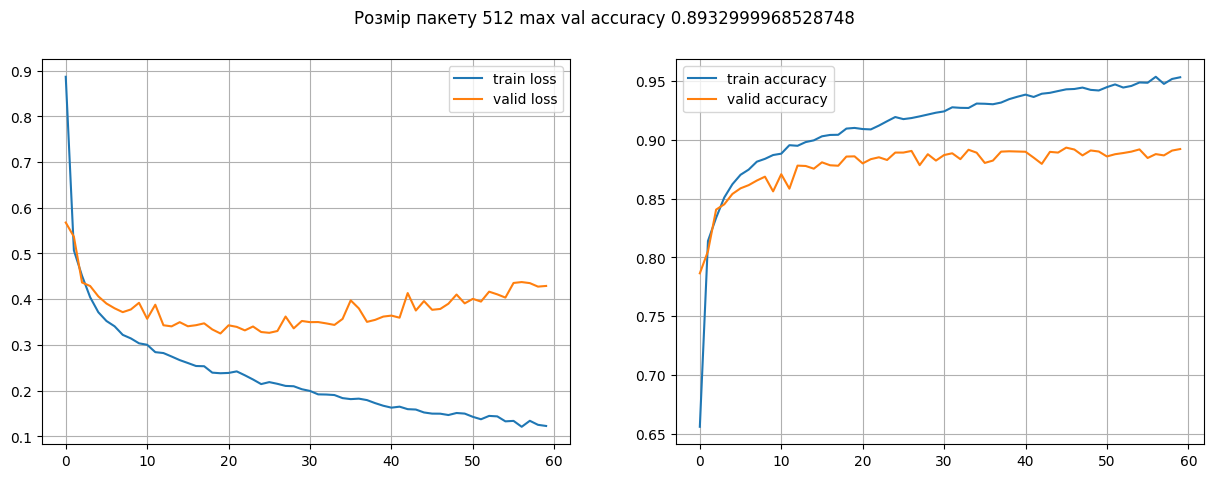

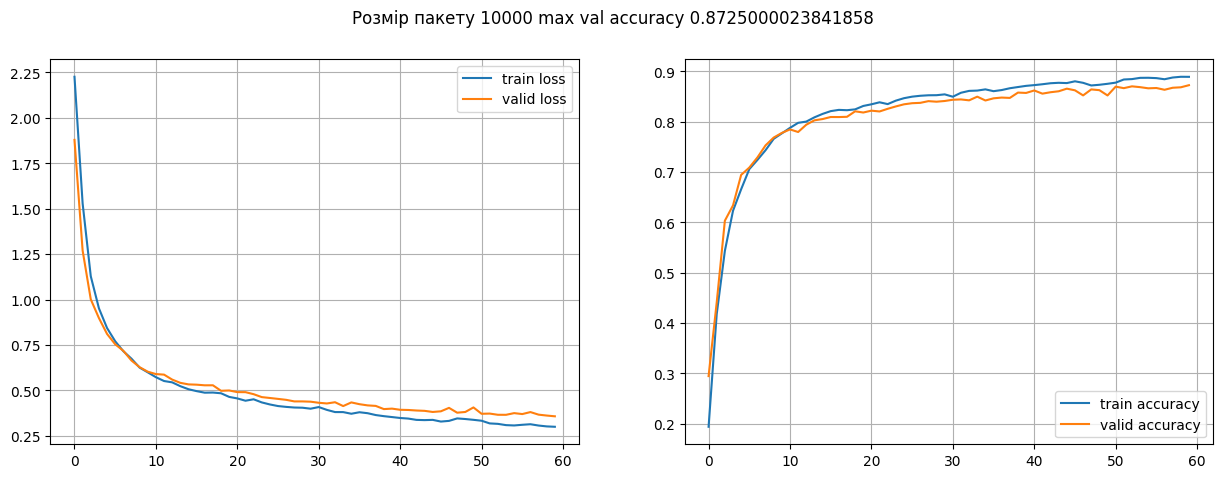

In [48]:
new_seeds = [SEEDS[i] if i < 30 else random.randint(0, 2**32) for i in range(60)]

present_histiry("Базова модель", base_history)

for batch_size in batch_sizes:
    cur_model = create_model(optimizer=Adam)
    cur_ds = MyDataset(train_X, train_Y, batch_size, False, new_seeds)
    cur_history = fit_model(cur_model, cur_ds, (test_X, test_Y), verbose=False, epochs=60)
    present_histiry(f"Розмір пакету {batch_size}", cur_history)

Ще одні проміжні висновки

Моделі з розміром пакету 256 та 512 однозначно пішли в перенавчання, що видно по зростанню втрат та плато точності на валідаційних даних, однак при даній кількості епох вони показали кращий результат ніж базова модель.

Для моделі з пакетом 10000 60 епох було замало, тож продовжимо експеримент з базовою моделлю (1000 на пакет), недонавчаною моделлю з пакетом 10000, та новою екстремальною з пакетом 30000


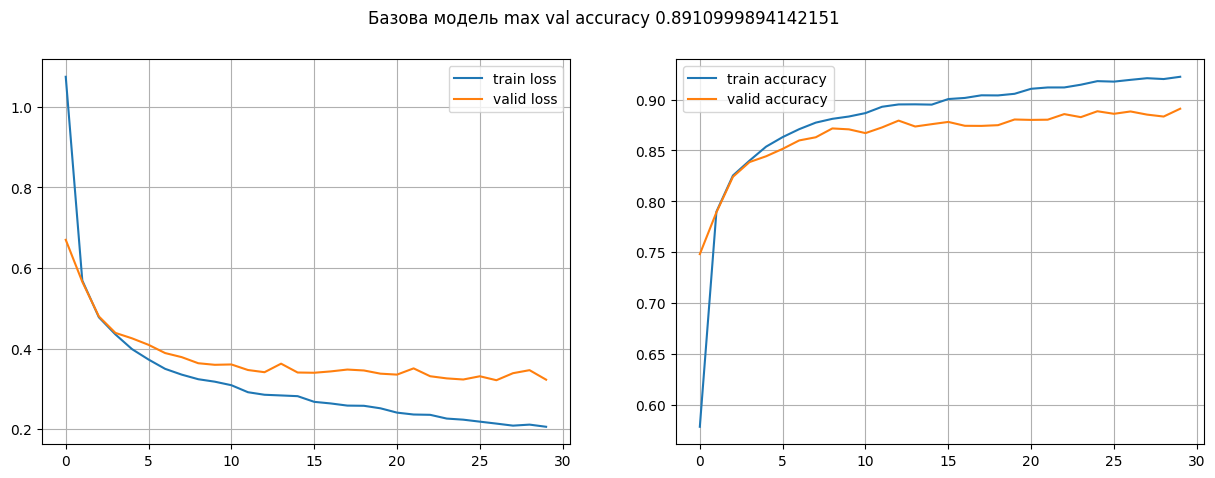

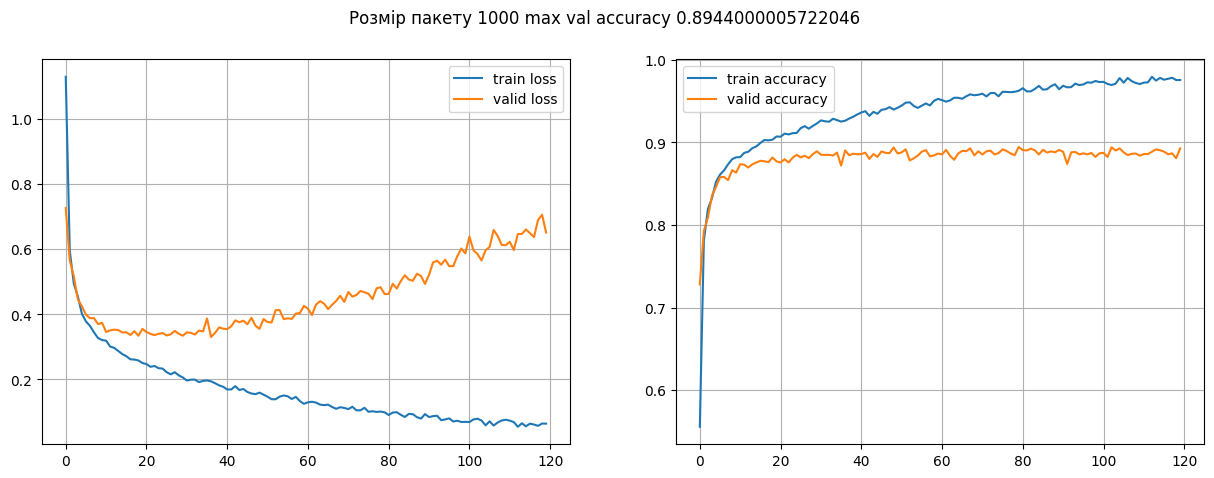

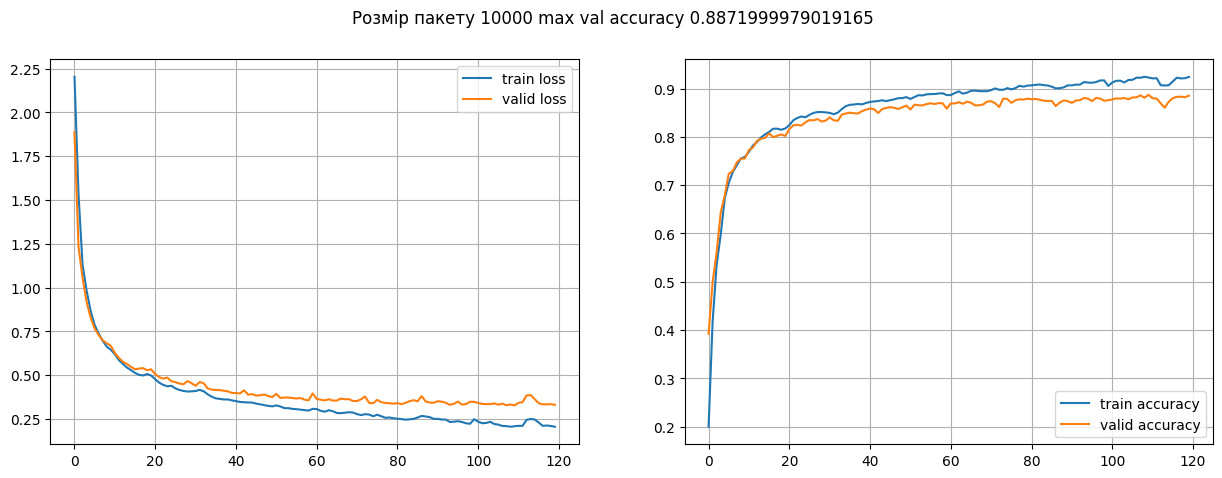

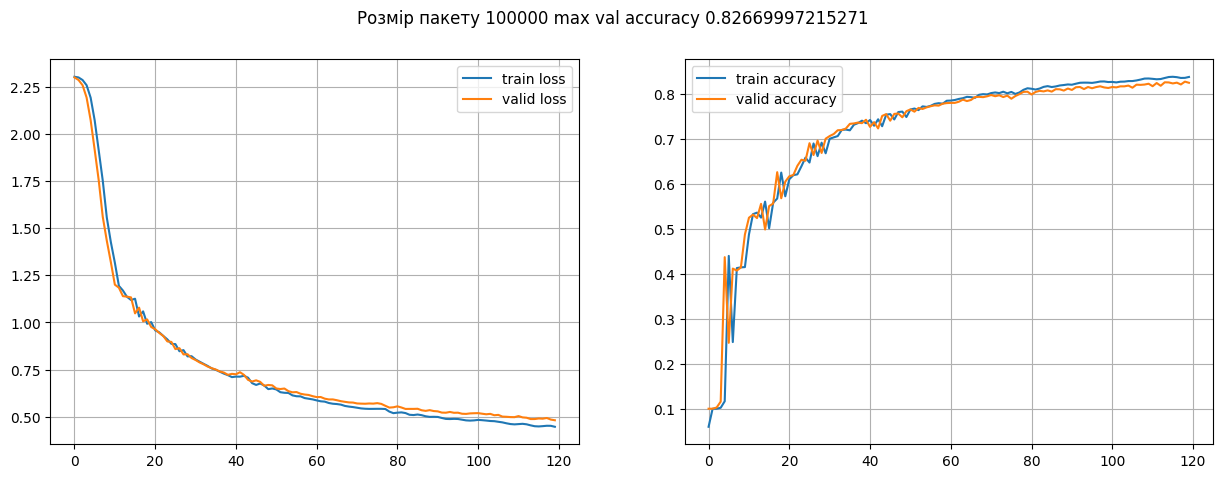

In [50]:
new_seeds = [SEEDS[i] if i < 30 else random.randint(0, 2**32) for i in range(120)]
batch_sizes = [1000, 10000, 100000]

present_histiry("Базова модель", base_history)

for batch_size in batch_sizes:
    cur_model = create_model(optimizer=Adam)
    cur_ds = MyDataset(train_X, train_Y, batch_size, False, new_seeds)
    cur_history = fit_model(cur_model, cur_ds, (test_X, test_Y), verbose=False, epochs=120)
    present_histiry(f"Розмір пакету {batch_size}", cur_history)

І знову висновки

Базова модель, розтягнута на 120 ероепох без стратифікації, показала кращий результат, хоча починаючи приблизно з 40 епохи значення втрат для валідаційної вибірки стабільно зростали.

Більший розмір пакета (10К та 30К) дає повільніше зростання якості моделі, але 120 епох виявилось замало, щоб натренувати модель. Можливо, ці моделі покажуть кращі показники якості на більшій кількості епох, але поки я цей варіант розвивати не буду.

Підтверджується один з попередніх висновків: краще задати більше епох і вставити запобіжник ранньої зупинки. Щоправда, зараз я б збільшив кількість невдалих епох до зупинки з 3 до 5.

Ще один висновок стосовно стратифікації даних.

Стратифіковані пакети дають легший старт (показники втрат і точності на перших двох-трьох епохах кращі), але при кількості епох від 60 (на даній задачі), цей приріст невілюється втратами часу (можливо занадто недолугий механізм).

Щоб оптимізувати час на навчання моделі і зберегти переваги, перепишемо клас датасету за наступними правилами: перші три епохи стратифікуються, далі кожна п'ята та кожна восьма

In [51]:
class MyDataset2(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size = 256, stratyfy = False, seeds = []):
        self.X = X
        self.y = y
        self.batches = []
        self.batch_size = batch_size
        self.stratyfy = stratyfy
        self.current_epoch = -1 # стане нулем при першій підготовці даних для епохи
        self.seeds = SEEDS if len(seeds) == 0 else seeds
        self.n_epochs = len(self.seeds)
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.batches)
    
    def __getitem__(self, index):
        return self.batches[index][0], tf.one_hot(self.batches[index][1], 10)  
    
    def on_epoch_end(self):
        self.current_epoch += 1
        if self.current_epoch == self.n_epochs:
            self.current_epoch = 0
            # Заганяємо в цикл
        curr_seed = self.seeds[self.current_epoch]
        self.batches = []
        
        X_to_split = self.X.copy()
        Y_to_split = self.y.copy()

        while len(X_to_split) > self.batch_size:
            if self.stratyfy and (self.current_epoch < 3 or self.current_epoch % 5 == 0 or self.current_epoch % 8 == 0):
                X_to_split, curr_batch_X, Y_to_split, curr_batch_Y = train_test_split(X_to_split, Y_to_split, test_size=self.batch_size, random_state=curr_seed, shuffle=True, stratify=Y_to_split)
            else:
                X_to_split, curr_batch_X, Y_to_split, curr_batch_Y = train_test_split(X_to_split, Y_to_split, test_size=self.batch_size, random_state=curr_seed, shuffle=True)
            
            self.batches.append((curr_batch_X, curr_batch_Y))
        
        if len(X_to_split) > 0:
            self.batches.append((X_to_split, Y_to_split))

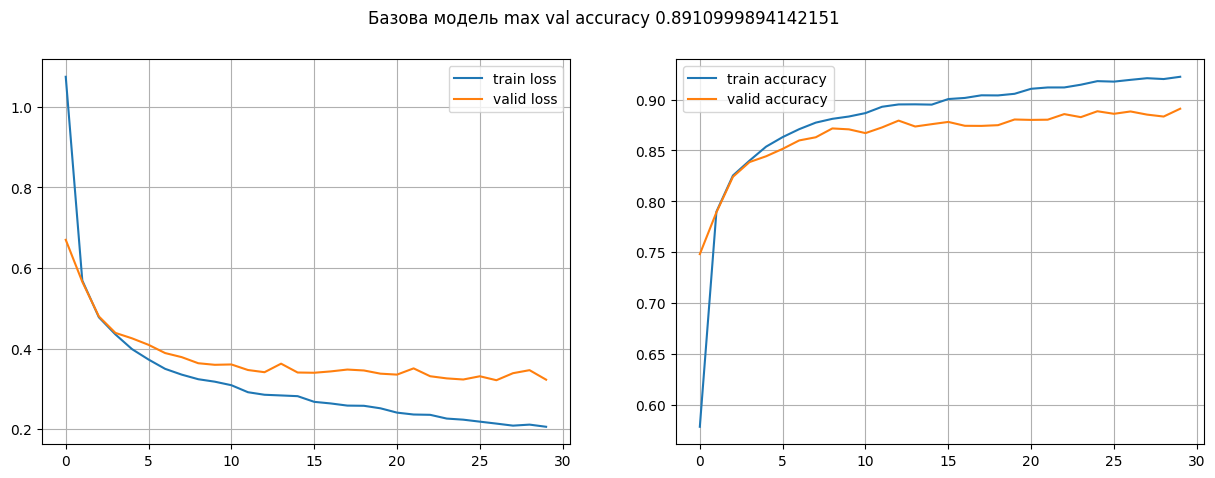

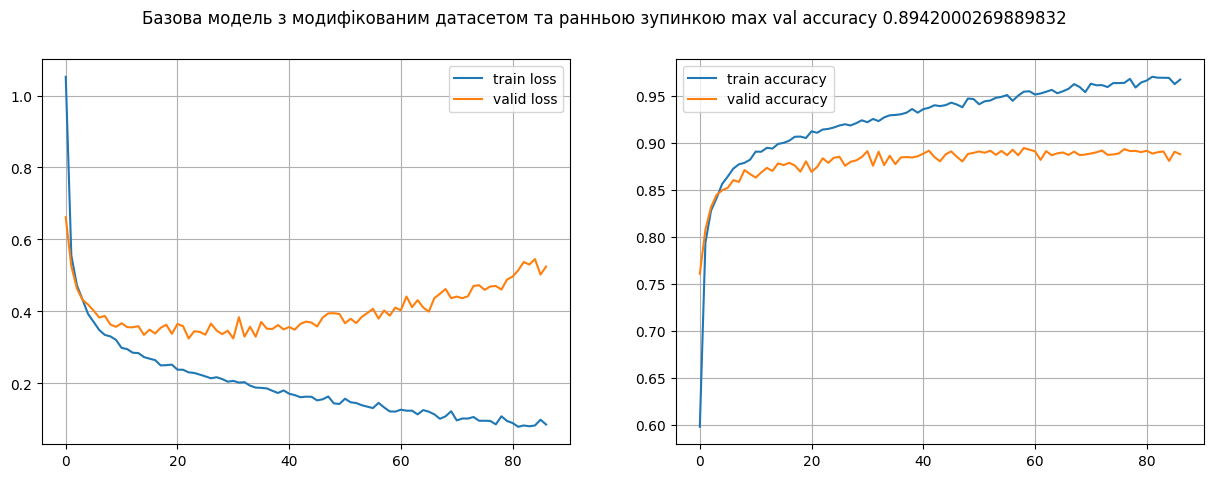

In [54]:
base_ds2 = MyDataset(train_X, train_Y, 1000, True)
base_model2 = create_model(optimizer=Adam)
base_history2 = fit_model(base_model2, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)

present_histiry("Базова модель", base_history)
present_histiry("Базова модель з модифікованим датасетом та ранньою зупинкою", base_history2)

# Тест 6: додавання регуляризації

Додамо шари Dropout зі значеннями 0.2, 0.3 та 0.5

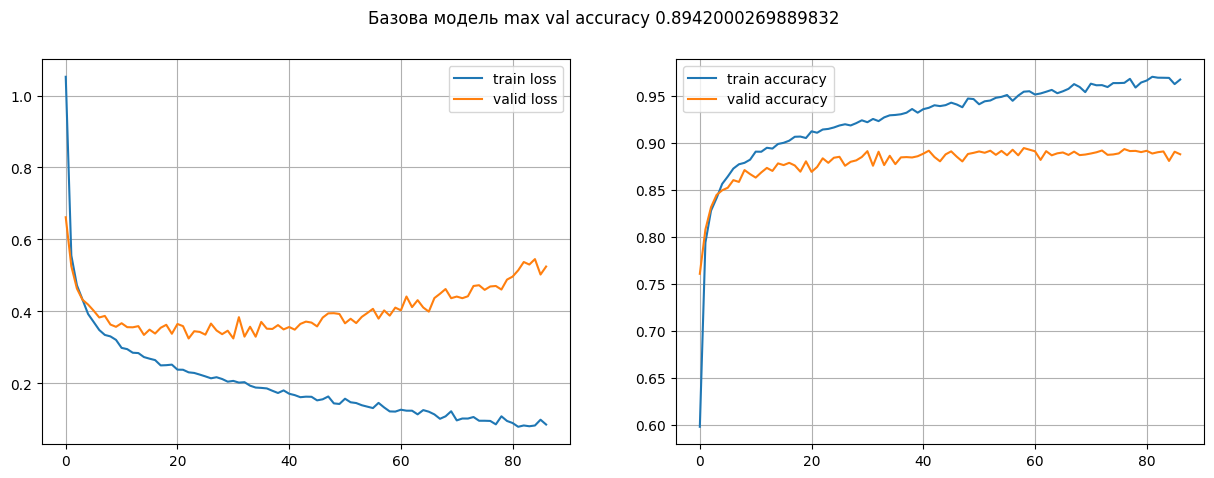

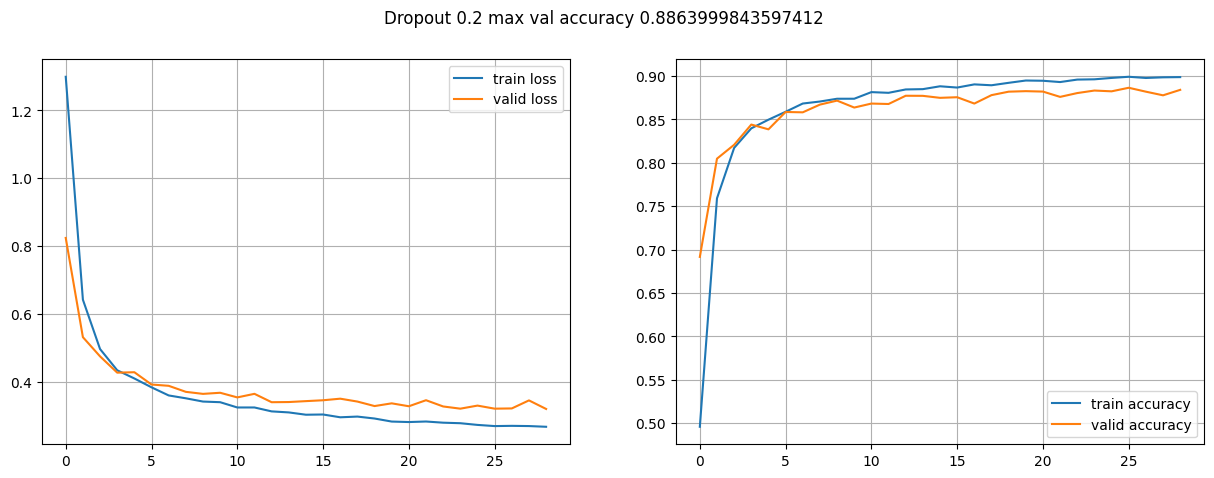

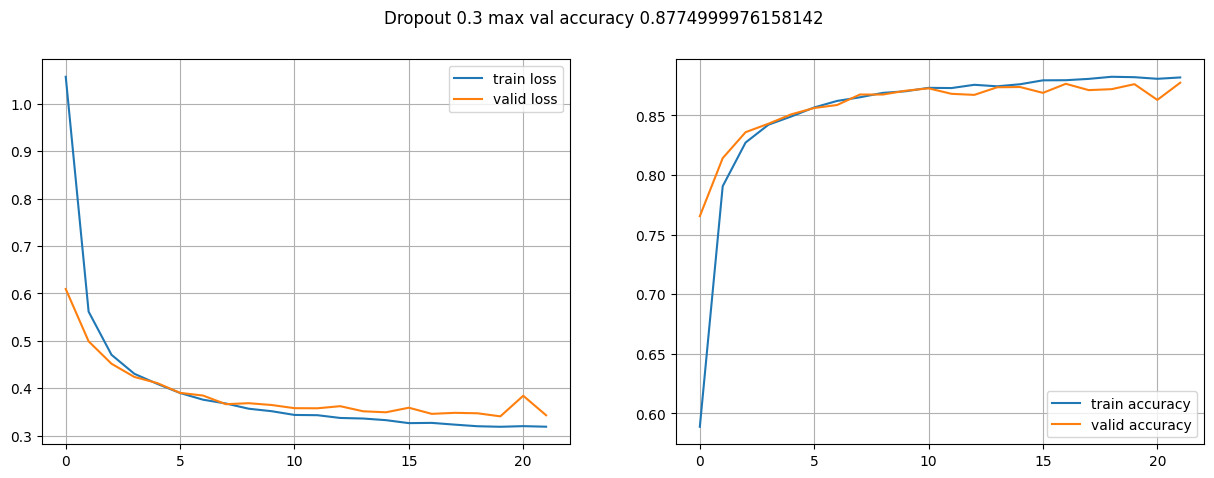

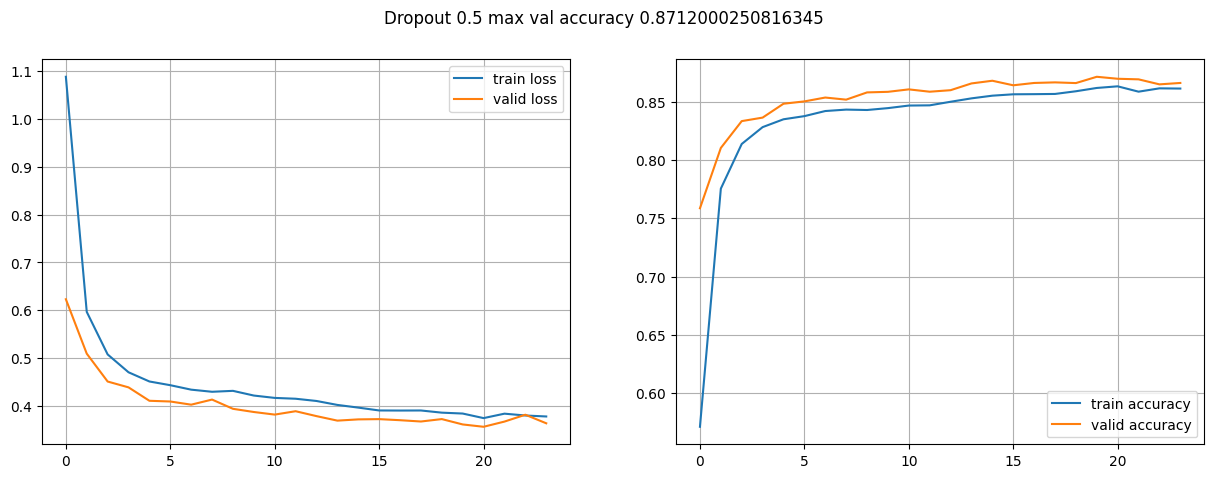

In [57]:
layers_reg2 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dropout(0.2),
    Dense(256, "relu"),
    Dropout(0.2),
    Dense(128, "relu")
]

layers_reg3 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dropout(0.3),
    Dense(256, "relu"),
    Dropout(0.3),
    Dense(128, "relu")
]

layers_reg5 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dropout(0.5),
    Dense(256, "relu"),
    Dropout(0.5),
    Dense(128, "relu")
]

model_reg2 = create_model(layers=layers_reg2, optimizer=Adam)
model_reg3 = create_model(layers=layers_reg3, optimizer=Adam)
model_reg5 = create_model(layers=layers_reg5, optimizer=Adam)

history_reg2 = fit_model(model_reg2, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)
history_reg3 = fit_model(model_reg3, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)
history_reg5 = fit_model(model_reg5, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)

present_histiry("Базова модель", base_history2)
present_histiry("Dropout 0.2", history_reg2)
present_histiry("Dropout 0.3", history_reg3)
present_histiry("Dropout 0.5", history_reg5)


Вельми несподівано, але шари Dropout спровокували ранню зупинку навчання різко погіршивши модель. Спробуемо зменшити параметри заморозки

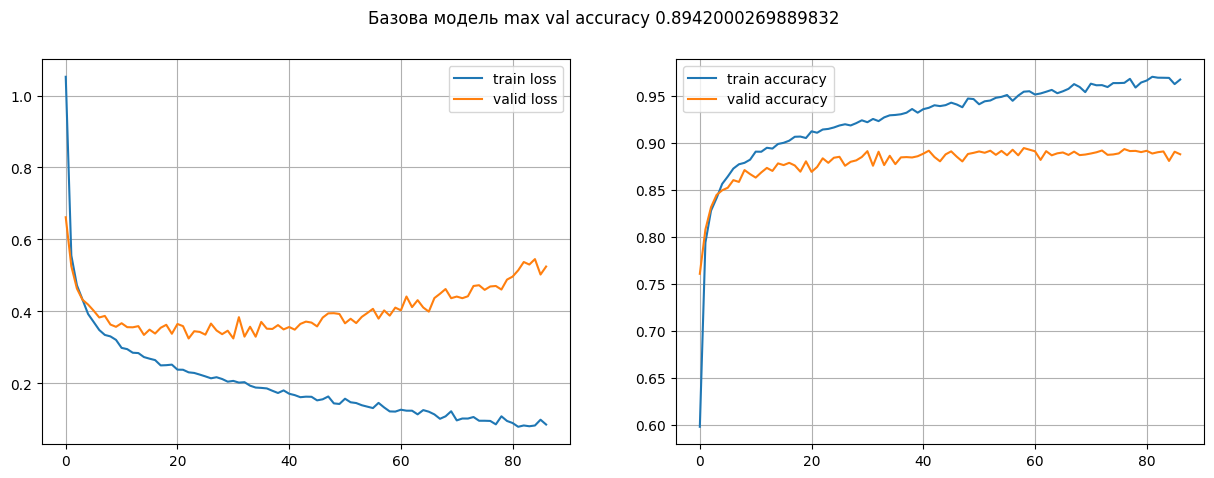

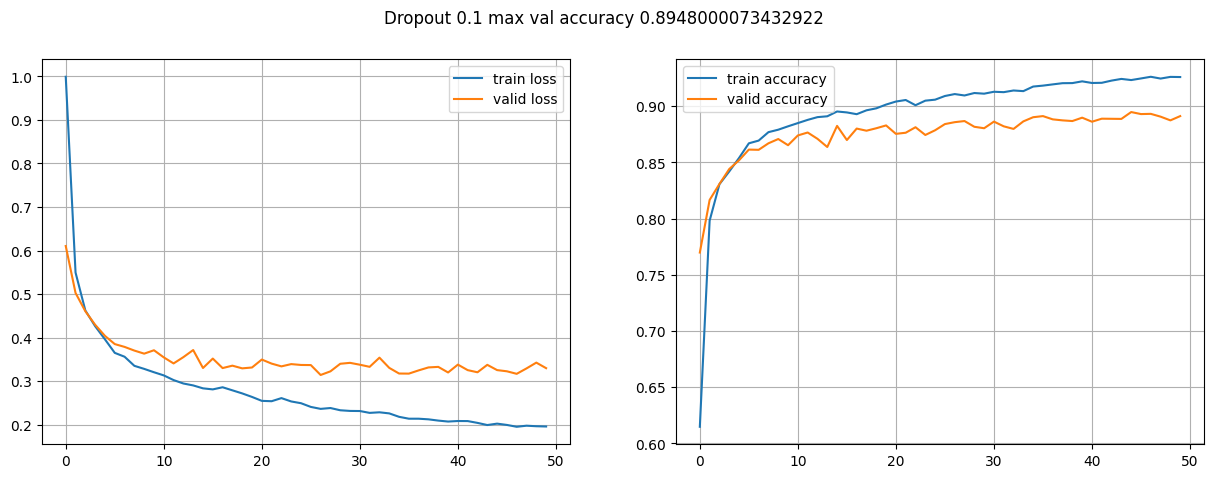

In [58]:
layers_reg1 = [
    Dense(512, "relu", input_shape=(28*28,)),
    Dropout(0.1),
    Dense(256, "relu"),
    Dropout(0.1),
    Dense(128, "relu")
]

model_reg1 = create_model(layers=layers_reg1, optimizer=Adam)

history_reg1 = fit_model(model_reg1, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)

present_histiry("Базова модель", base_history2)
present_histiry("Dropout 0.1", history_reg1)


Краще, але не ідеал.

Спробуємо додати L1L2 регуляризацію в шари Dense

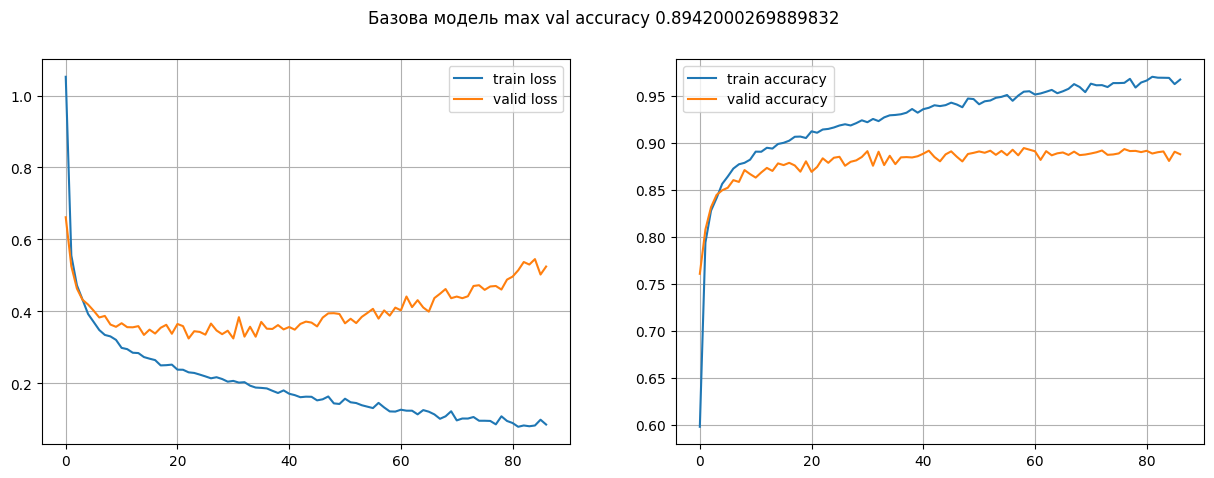

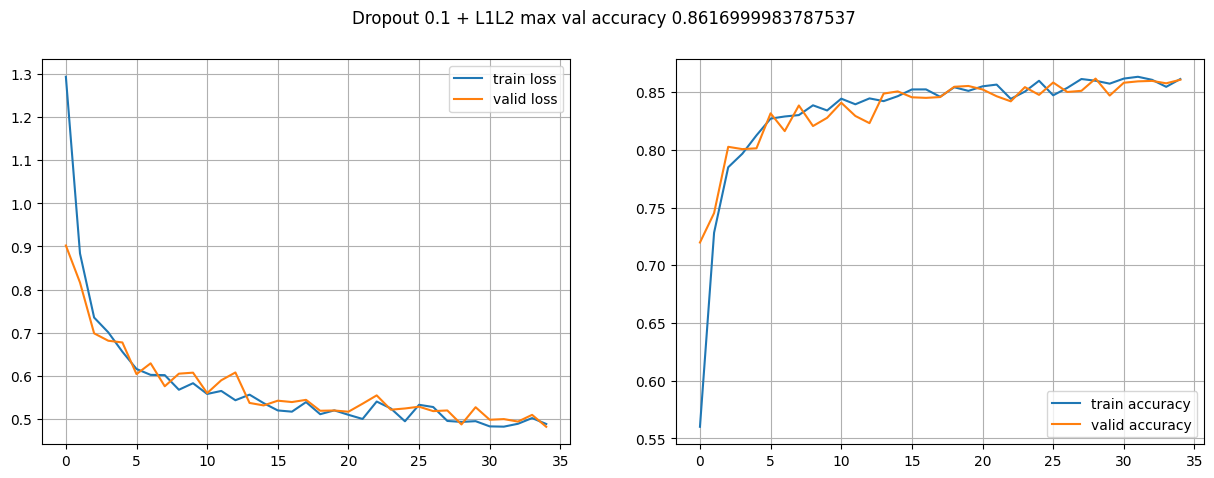

In [62]:
base_ds2 = MyDataset2(train_X, train_Y, 1000, True, seeds=new_seeds)

layers_reg1_L1L2 = [
    Dense(512, "relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.1),
    Dense(256, "relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.1),
    Dense(128, "relu")
]

model_reg1_L1L2 = create_model(layers=layers_reg1_L1L2, optimizer=Adam)

history_reg1_L1L2 = fit_model(model_reg1_L1L2, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=True)

present_histiry("Базова модель", base_history2)
present_histiry("Dropout 0.1 + L1L2", history_reg1_L1L2)


Очікувано, графіки втрат та точності виглядають як нервова кардіограма.

В принципі очікувано, модель зупинила навчання по ранній зупинці.

Неприємно, що результат не досяг базової моделі.

Всиляє оптимізм, що графіки втрат і графіки точності по тестовим даним та валідаційним даним ідуть нога в ногу.

Спробуємо відключити ранню зупинку і дійти той шлях до кінця.

Epoch 1/120
60/60 [==============================] - 4s 51ms/step - loss: 1.3351 - categorical_accuracy: 0.5346 - val_loss: 0.9509 - val_categorical_accuracy: 0.7075
Epoch 2/120
60/60 [==============================] - 3s 45ms/step - loss: 0.8952 - categorical_accuracy: 0.7201 - val_loss: 0.8000 - val_categorical_accuracy: 0.7660
Epoch 3/120
60/60 [==============================] - 3s 44ms/step - loss: 0.7677 - categorical_accuracy: 0.7728 - val_loss: 0.7208 - val_categorical_accuracy: 0.7898
Epoch 4/120
60/60 [==============================] - 3s 55ms/step - loss: 0.7285 - categorical_accuracy: 0.7913 - val_loss: 0.6934 - val_categorical_accuracy: 0.7986
Epoch 5/120
60/60 [==============================] - 3s 55ms/step - loss: 0.6781 - categorical_accuracy: 0.8076 - val_loss: 0.6473 - val_categorical_accuracy: 0.8194
Epoch 6/120
60/60 [==============================] - 3s 58ms/step - loss: 0.6337 - categorical_accuracy: 0.8227 - val_loss: 0.6103 - val_categorical_accuracy: 0.8293
Epoc

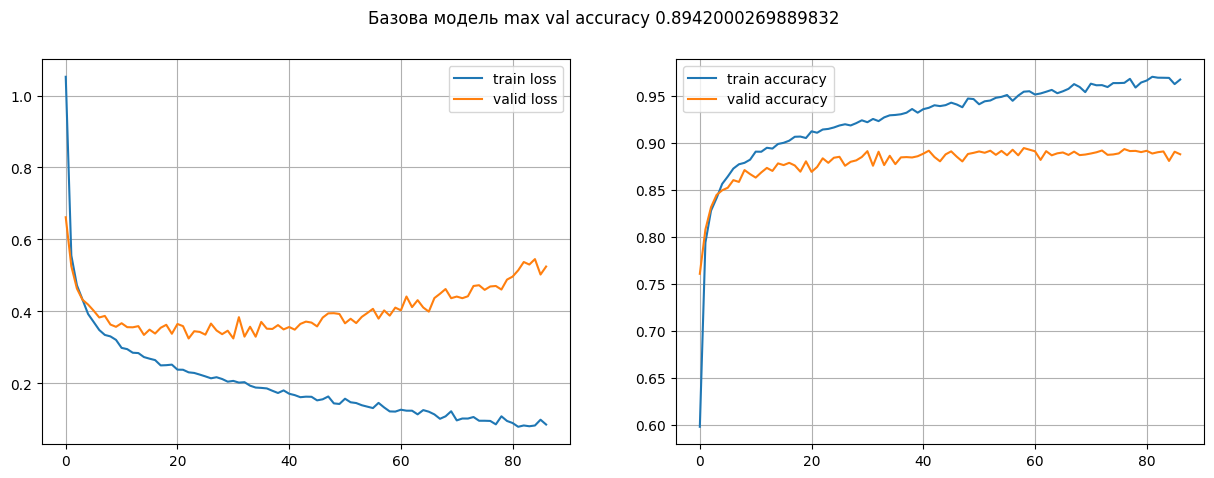

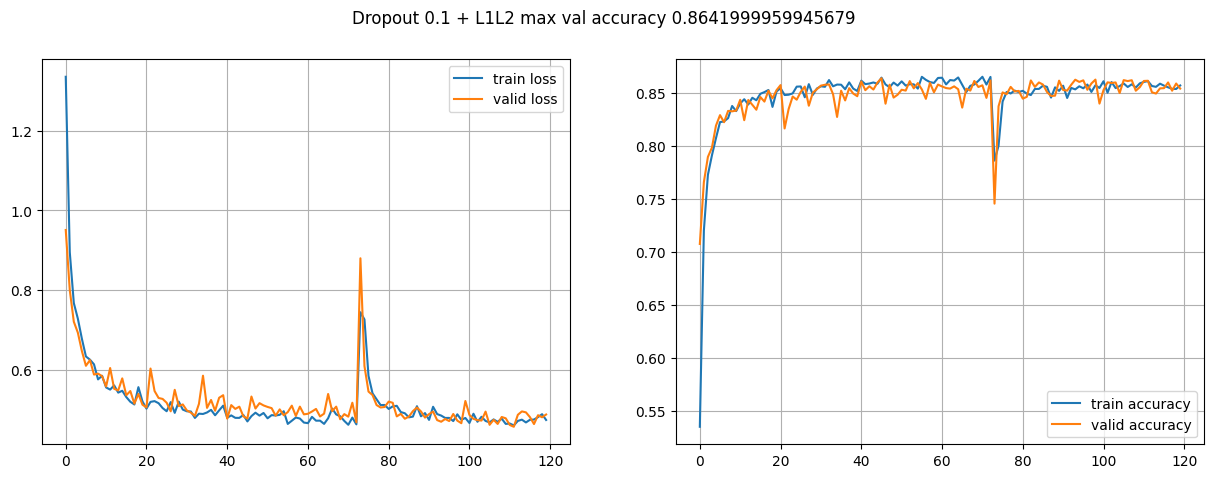

In [63]:
base_ds2 = MyDataset2(train_X, train_Y, 1000, True, seeds=new_seeds)

layers_reg1_L1L2 = [
    Dense(512, "relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.1),
    Dense(256, "relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dropout(0.1),
    Dense(128, "relu")
]

model_reg1_L1L2 = create_model(layers=layers_reg1_L1L2, optimizer=Adam)

history_reg1_L1L2 = fit_model(model_reg1_L1L2, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)

present_histiry("Базова модель", base_history2)
present_histiry("Dropout 0.1 + L1L2", history_reg1_L1L2)

Підсліпкуватість і забудькуватість одночасно працюють зле.

Залишимо тільки підсліпкуватість

Epoch 1/120
60/60 [==============================] - 3s 42ms/step - loss: 1.3264 - categorical_accuracy: 0.5440 - val_loss: 0.9312 - val_categorical_accuracy: 0.7159
Epoch 2/120
60/60 [==============================] - 2s 38ms/step - loss: 0.8536 - categorical_accuracy: 0.7376 - val_loss: 0.8585 - val_categorical_accuracy: 0.7377
Epoch 3/120
60/60 [==============================] - 3s 47ms/step - loss: 0.8212 - categorical_accuracy: 0.7494 - val_loss: 0.7717 - val_categorical_accuracy: 0.7667
Epoch 4/120
60/60 [==============================] - 3s 47ms/step - loss: 0.7369 - categorical_accuracy: 0.7772 - val_loss: 0.7577 - val_categorical_accuracy: 0.7680
Epoch 5/120
60/60 [==============================] - 3s 50ms/step - loss: 0.6921 - categorical_accuracy: 0.7951 - val_loss: 0.6720 - val_categorical_accuracy: 0.8040
Epoch 6/120
60/60 [==============================] - 3s 47ms/step - loss: 0.6391 - categorical_accuracy: 0.8137 - val_loss: 0.6477 - val_categorical_accuracy: 0.8119
Epoc

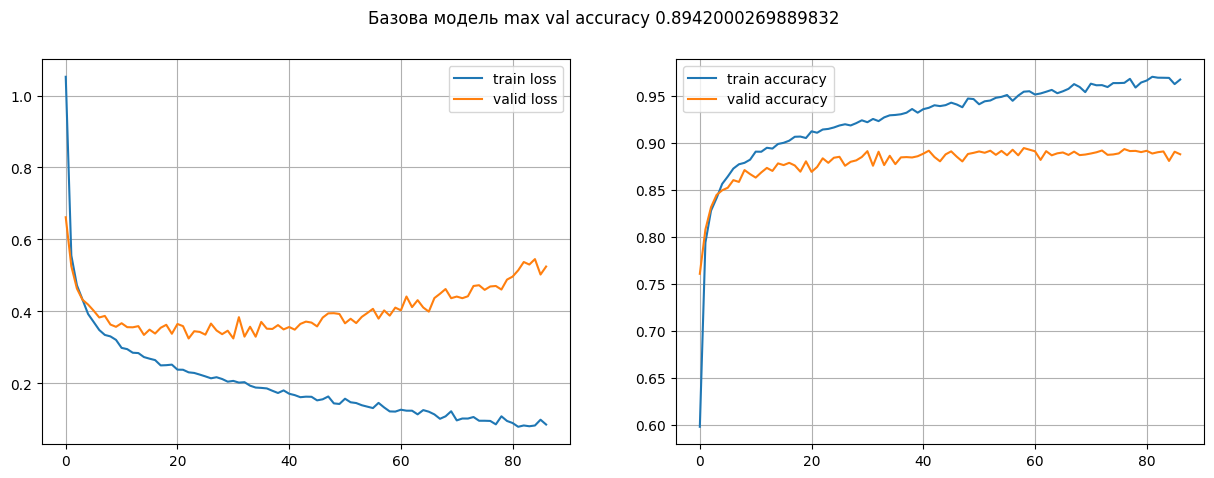

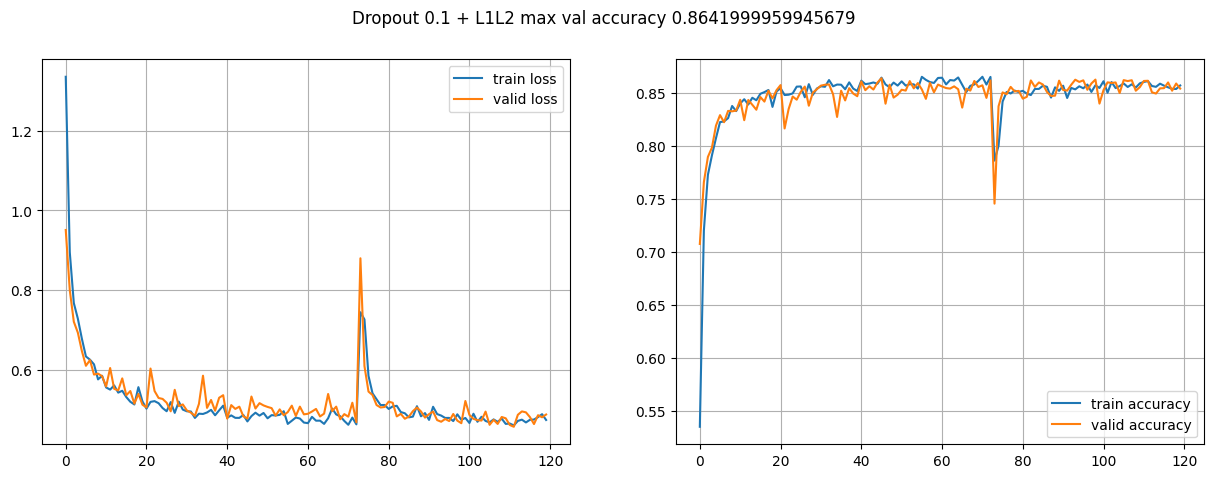

In [65]:
base_ds2 = MyDataset2(train_X, train_Y, 1000, True, seeds=new_seeds)

layers_L1L2 = [
    Dense(512, "relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dense(256, "relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
    Dense(128, "relu")
]

model_L1L2 = create_model(layers=layers_L1L2, optimizer=Adam)

history_L1L2 = fit_model(model_L1L2, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)



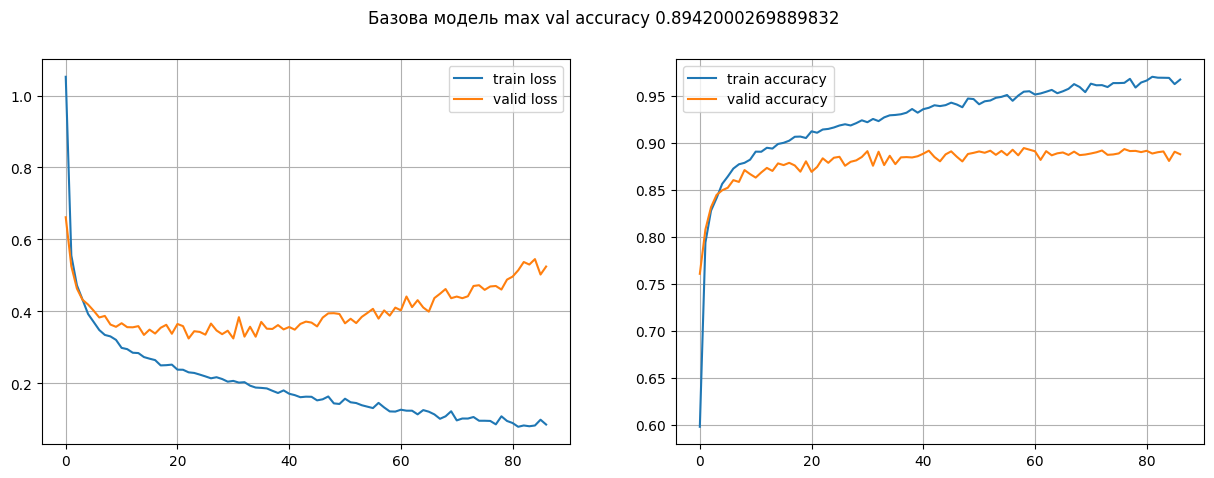

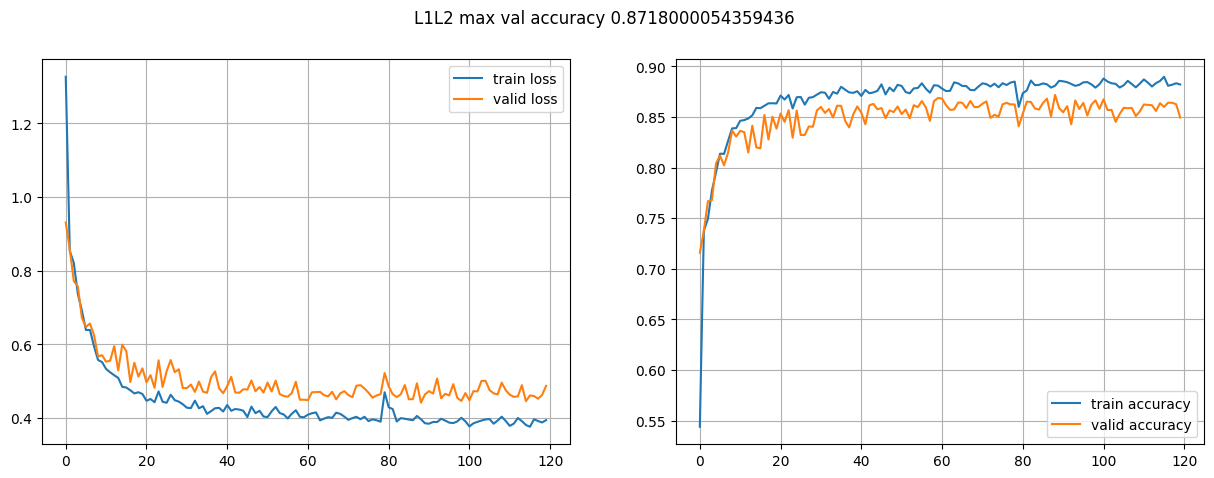

In [66]:
present_histiry("Базова модель", base_history2)
present_histiry("L1L2", history_L1L2)

Регуляризація працює, модель не оверфітиться на великих проміжках епох.

Щоправда і точність по валідаційним даним не зростає.

# Тест 7: заміна оптимізатора, робота з гіперпараметрами оптимізатора

Epoch 1/120
60/60 [==============================] - 3s 39ms/step - loss: 1.0744 - categorical_accuracy: 0.5807 - val_loss: 0.6657 - val_categorical_accuracy: 0.7572
Epoch 2/120
60/60 [==============================] - 2s 34ms/step - loss: 0.5625 - categorical_accuracy: 0.7930 - val_loss: 0.5326 - val_categorical_accuracy: 0.8063
Epoch 3/120
60/60 [==============================] - 2s 36ms/step - loss: 0.4769 - categorical_accuracy: 0.8280 - val_loss: 0.4733 - val_categorical_accuracy: 0.8277
Epoch 4/120
60/60 [==============================] - 2s 35ms/step - loss: 0.4239 - categorical_accuracy: 0.8457 - val_loss: 0.4535 - val_categorical_accuracy: 0.8328
Epoch 5/120
60/60 [==============================] - 3s 43ms/step - loss: 0.3943 - categorical_accuracy: 0.8571 - val_loss: 0.4143 - val_categorical_accuracy: 0.8507
Epoch 6/120
60/60 [==============================] - 3s 43ms/step - loss: 0.3723 - categorical_accuracy: 0.8632 - val_loss: 0.4092 - val_categorical_accuracy: 0.8517
Epoc

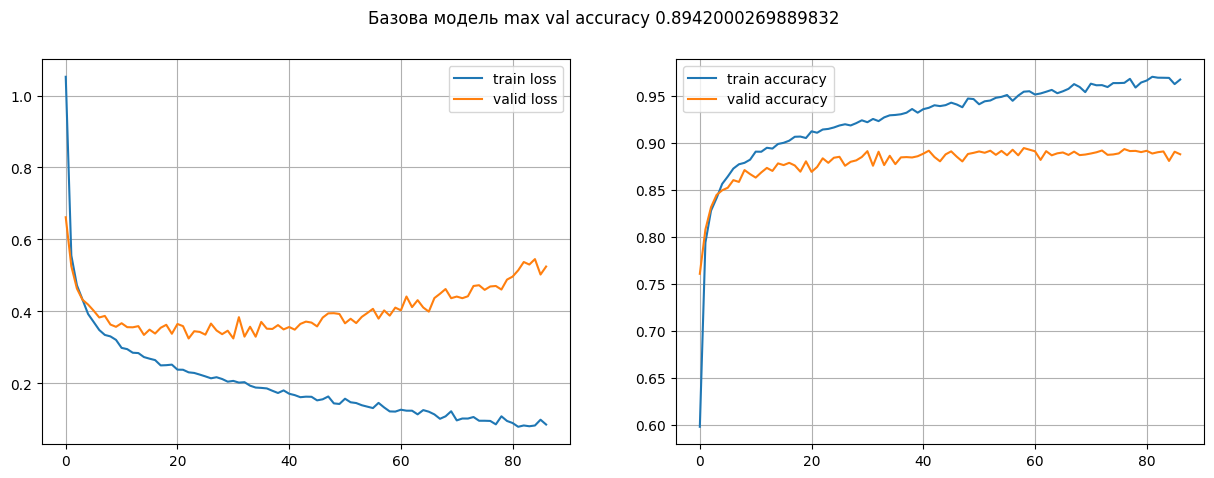

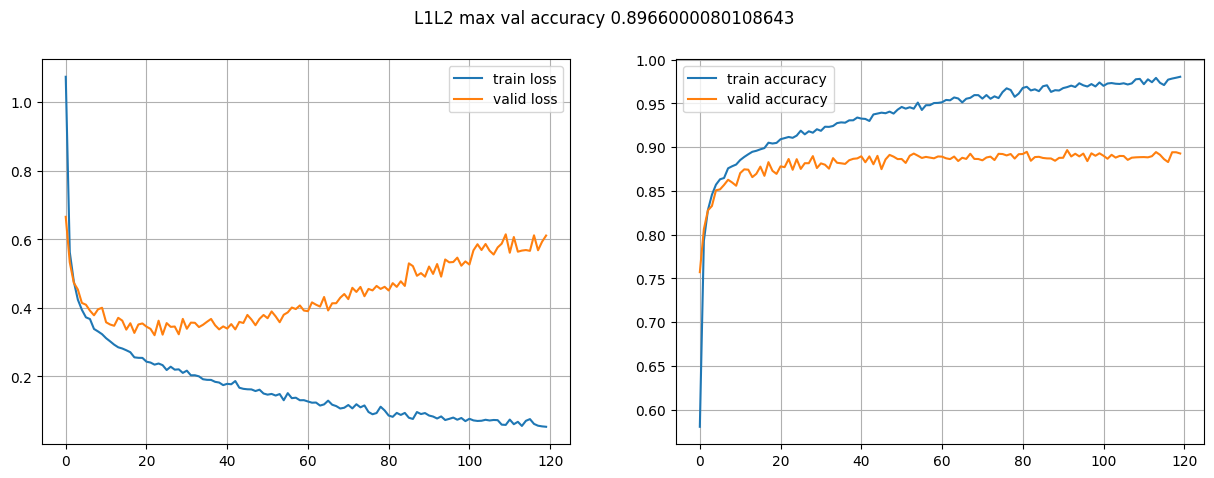

In [67]:
base_ds2 = MyDataset(train_X, train_Y, 1000, True, seeds=new_seeds)
model_AdamW = create_model(optimizer=AdamW)
history_AdamW = fit_model(model_AdamW, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)

present_histiry("Базова модель", base_history2)
present_histiry("AdamW", history_AdamW)


AdamW показав кращий результат, тож спробуємо підібрати learning_rate.


Epoch 1/120
60/60 [==============================] - 3s 40ms/step - loss: 1.6931 - categorical_accuracy: 0.4451 - val_loss: 0.9535 - val_categorical_accuracy: 0.6424
Epoch 2/120
60/60 [==============================] - 2s 35ms/step - loss: 0.8019 - categorical_accuracy: 0.7035 - val_loss: 0.7485 - val_categorical_accuracy: 0.7344
Epoch 3/120
60/60 [==============================] - 2s 35ms/step - loss: 0.6900 - categorical_accuracy: 0.7482 - val_loss: 0.6851 - val_categorical_accuracy: 0.7539
Epoch 4/120
60/60 [==============================] - 2s 36ms/step - loss: 0.6357 - categorical_accuracy: 0.7688 - val_loss: 0.6334 - val_categorical_accuracy: 0.7708
Epoch 5/120
60/60 [==============================] - 2s 37ms/step - loss: 0.5903 - categorical_accuracy: 0.7860 - val_loss: 0.5952 - val_categorical_accuracy: 0.7886
Epoch 6/120
60/60 [==============================] - 3s 44ms/step - loss: 0.5567 - categorical_accuracy: 0.7995 - val_loss: 0.5656 - val_categorical_accuracy: 0.7976
Epoc

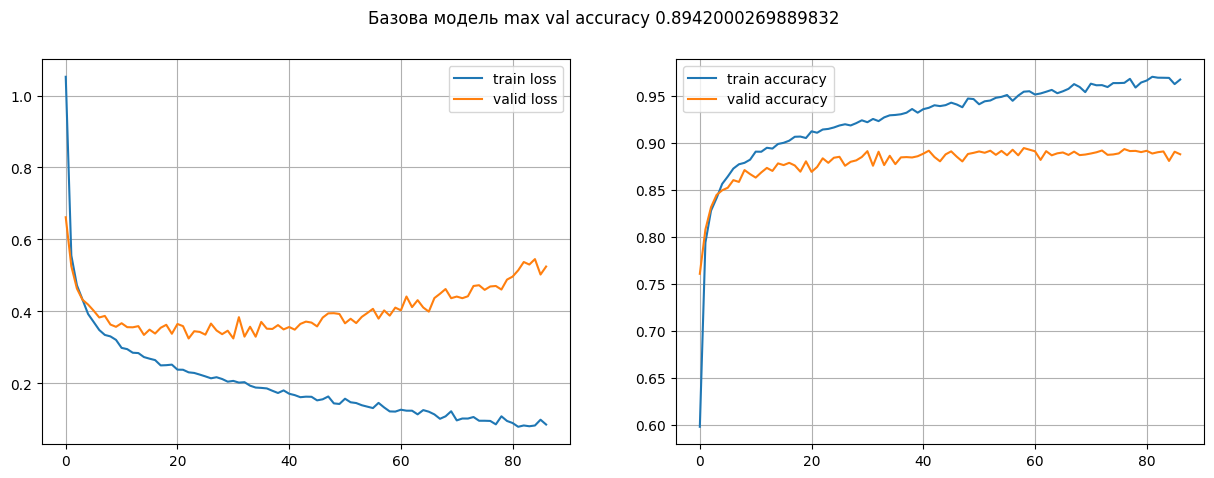

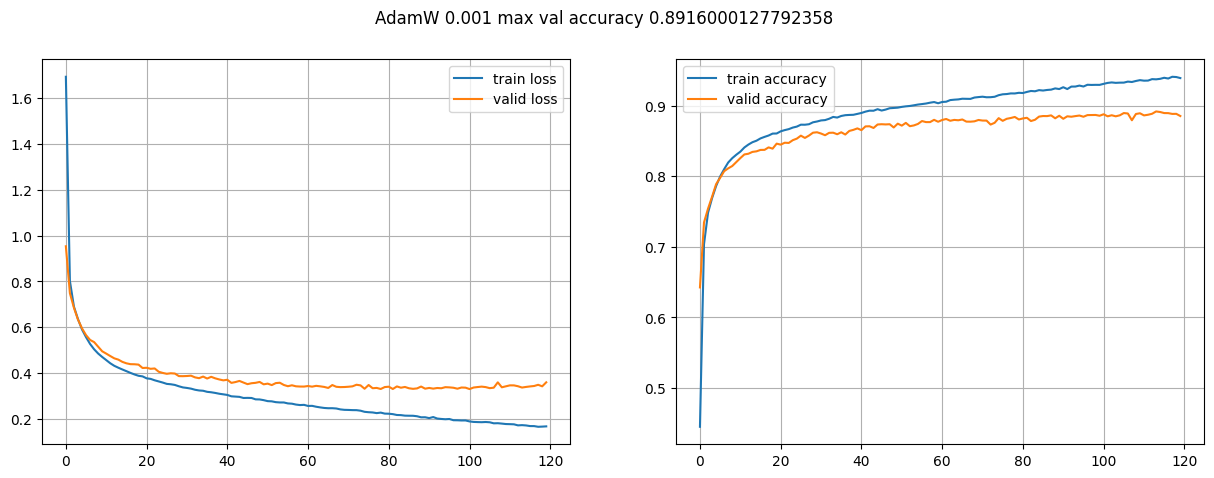

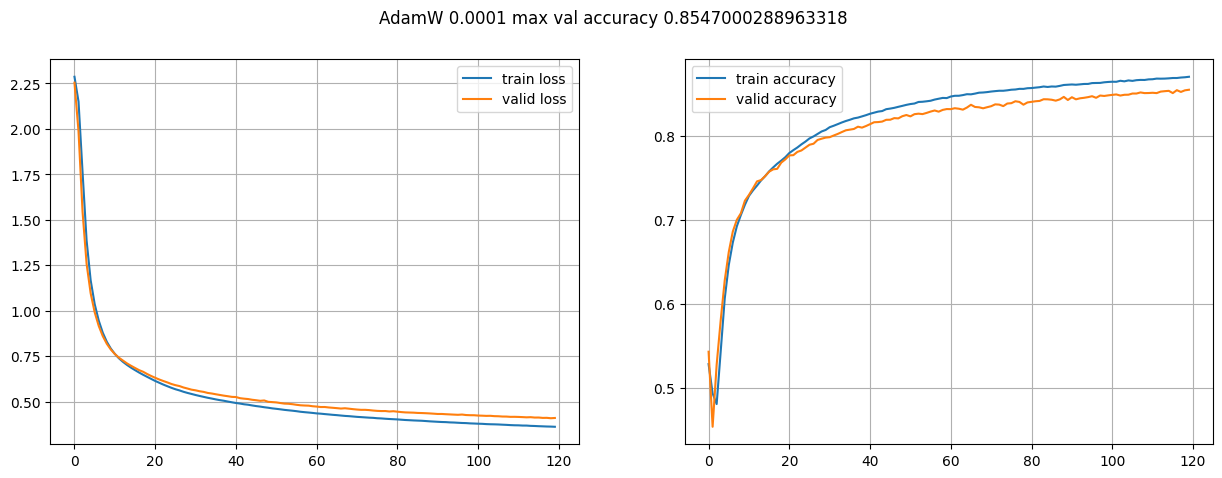

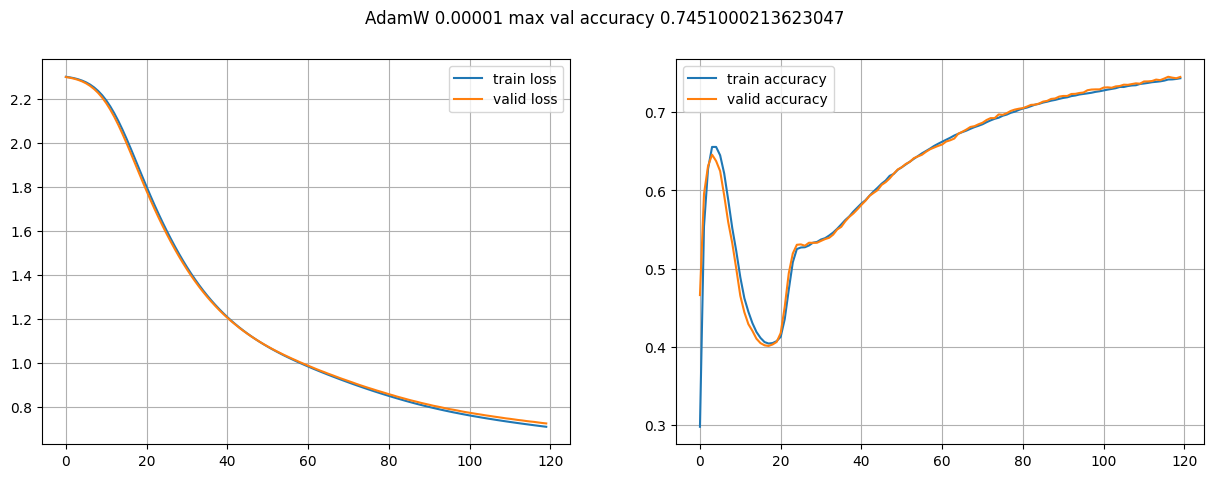

In [69]:
base_ds2 = MyDataset(train_X, train_Y, 1000, True, seeds=new_seeds)
model_AdamW_001 = create_model(optimizer=AdamW, lr=0.001)
history_AdamW_001 = fit_model(model_AdamW_001, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)

base_ds2.current_epoch = 0
model_AdamW_0001 = create_model(optimizer=AdamW, lr=0.0001)
history_AdamW_0001 = fit_model(model_AdamW_0001, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)

base_ds2.current_epoch = 0
model_AdamW_00001 = create_model(optimizer=AdamW, lr=0.00001)
history_AdamW_00001 = fit_model(model_AdamW_00001, base_ds2, (test_X, test_Y), epochs=120, add_early_stopping=False, verbose=1)

present_histiry("Базова модель", base_history2)
present_histiry("AdamW 0.001", history_AdamW_001)
present_histiry("AdamW 0.0001", history_AdamW_0001)
present_histiry("AdamW 0.00001",  history_AdamW_00001)


Результати тестування показали, що для такого набору шарів lr=0.001 ледь встигає виходити на плато, а при менших рейтингах модель просто не встигає навчитись.

За результатами тестів спробуєм зібрати модельку з найкращими параметрами

1. Об'єкт Датасет - модифікований зі стратифікацією
2. Розмір пакета - 512
3. Для регулярізації будемо використовувати Dropout(0.1)
4. Решта шарів - з базової моделі
5. Оптимізатор AdamW, lr=0.01
6. Рандомні сіди на 180 епох
7. По колбекам - збереження найкращої моделі без раннього зупину
8. Віримо в рандом

Epoch 1/180
118/118 [==============================] - ETA: 0s - loss: 0.3612 - categorical_accuracy: 0.8738
Epoch 1: val_loss improved from inf to 0.32543, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


118/118 [==============================] - 6s 40ms/step - loss: 0.3612 - categorical_accuracy: 0.8738 - val_loss: 0.3254 - val_categorical_accuracy: 0.8847
Epoch 2/180
116/118 [============================>.] - ETA: 0s - loss: 0.2179 - categorical_accuracy: 0.9175
Epoch 2: val_loss did not improve from 0.32543
118/118 [==============================] - 3s 26ms/step - loss: 0.2178 - categorical_accuracy: 0.9175 - val_loss: 0.3368 - val_categorical_accuracy: 0.8847
Epoch 3/180
116/118 [============================>.] - ETA: 0s - loss: 0.2169 - categorical_accuracy: 0.9173
Epoch 3: val_loss improved from 0.32543 to 0.31984, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


118/118 [==============================] - 4s 35ms/step - loss: 0.2168 - categorical_accuracy: 0.9173 - val_loss: 0.3198 - val_categorical_accuracy: 0.8926
Epoch 4/180
118/118 [==============================] - ETA: 0s - loss: 0.2172 - categorical_accuracy: 0.9188
Epoch 4: val_loss did not improve from 0.31984
118/118 [==============================] - 4s 31ms/step - loss: 0.2172 - categorical_accuracy: 0.9188 - val_loss: 0.3285 - val_categorical_accuracy: 0.8886
Epoch 5/180
118/118 [==============================] - ETA: 0s - loss: 0.2064 - categorical_accuracy: 0.9216
Epoch 5: val_loss did not improve from 0.31984
118/118 [==============================] - 4s 34ms/step - loss: 0.2064 - categorical_accuracy: 0.9216 - val_loss: 0.3367 - val_categorical_accuracy: 0.8907
Epoch 6/180
117/118 [============================>.] - ETA: 0s - loss: 0.2070 - categorical_accuracy: 0.9214
Epoch 6: val_loss did not improve from 0.31984
118/118 [==============================] - 4s 32ms/step - loss: 

INFO:tensorflow:Assets written to: best_model\assets


118/118 [==============================] - 5s 46ms/step - loss: 0.2004 - categorical_accuracy: 0.9242 - val_loss: 0.3194 - val_categorical_accuracy: 0.8921
Epoch 13/180
117/118 [============================>.] - ETA: 0s - loss: 0.1968 - categorical_accuracy: 0.9256
Epoch 13: val_loss did not improve from 0.31943
118/118 [==============================] - 4s 33ms/step - loss: 0.1972 - categorical_accuracy: 0.9254 - val_loss: 0.3532 - val_categorical_accuracy: 0.8915
Epoch 14/180
117/118 [============================>.] - ETA: 0s - loss: 0.2020 - categorical_accuracy: 0.9244
Epoch 14: val_loss did not improve from 0.31943
118/118 [==============================] - 4s 34ms/step - loss: 0.2018 - categorical_accuracy: 0.9245 - val_loss: 0.3511 - val_categorical_accuracy: 0.8836
Epoch 15/180
117/118 [============================>.] - ETA: 0s - loss: 0.1958 - categorical_accuracy: 0.9270
Epoch 15: val_loss did not improve from 0.31943
118/118 [==============================] - 4s 34ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


118/118 [==============================] - 5s 45ms/step - loss: 0.1892 - categorical_accuracy: 0.9276 - val_loss: 0.3165 - val_categorical_accuracy: 0.8948
Epoch 22/180
118/118 [==============================] - ETA: 0s - loss: 0.1816 - categorical_accuracy: 0.9314
Epoch 22: val_loss did not improve from 0.31647
118/118 [==============================] - 4s 34ms/step - loss: 0.1816 - categorical_accuracy: 0.9314 - val_loss: 0.3258 - val_categorical_accuracy: 0.8960
Epoch 23/180
118/118 [==============================] - ETA: 0s - loss: 0.1842 - categorical_accuracy: 0.9301
Epoch 23: val_loss did not improve from 0.31647
118/118 [==============================] - 4s 32ms/step - loss: 0.1842 - categorical_accuracy: 0.9301 - val_loss: 0.3380 - val_categorical_accuracy: 0.8915
Epoch 24/180
118/118 [==============================] - ETA: 0s - loss: 0.1857 - categorical_accuracy: 0.9299
Epoch 24: val_loss did not improve from 0.31647
118/118 [==============================] - 4s 33ms/step - 

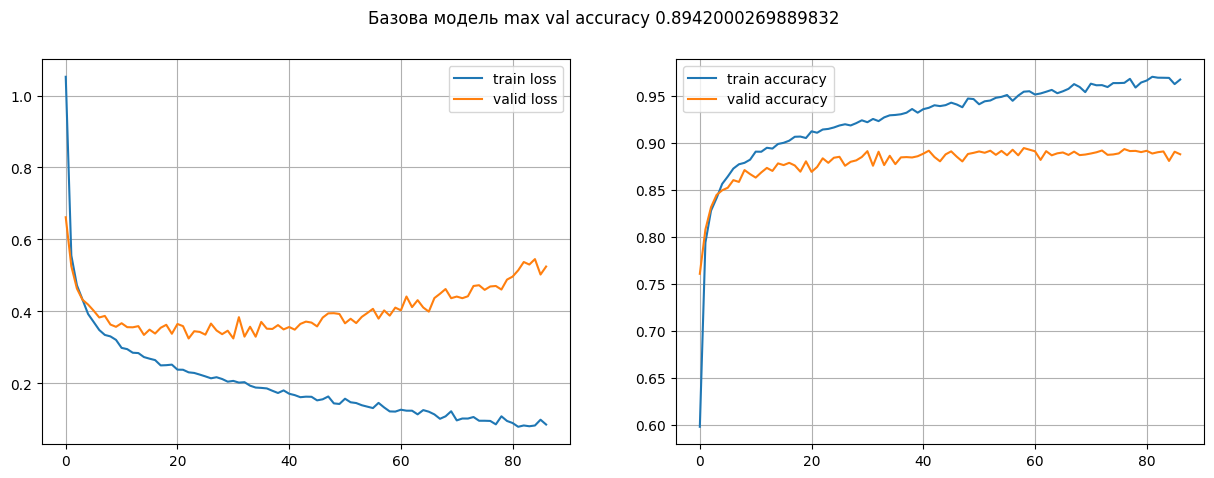

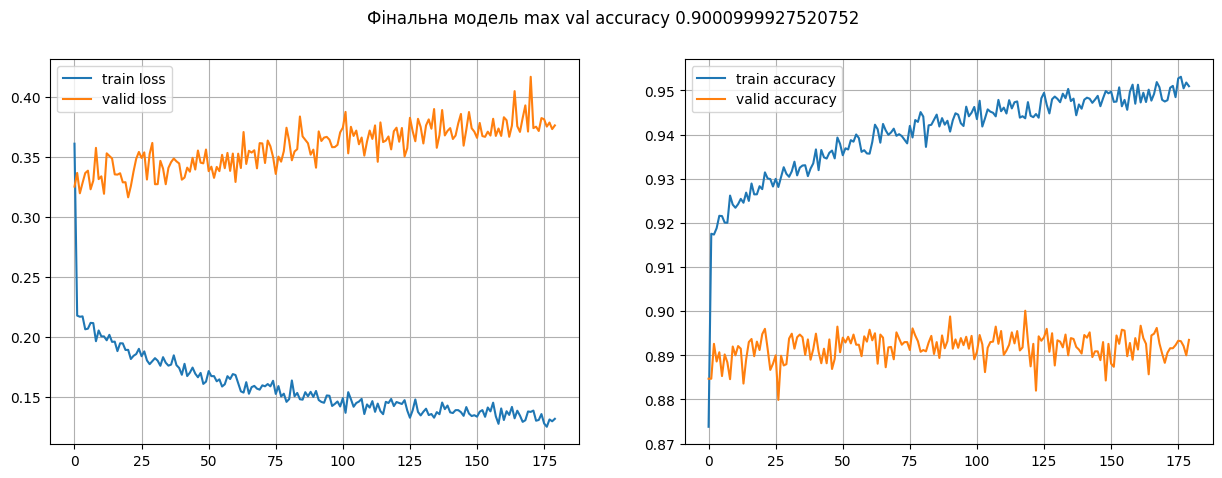

In [73]:
final_seeds = [random.randint(0, 2**32-1) for i in range(180)]
ds_final = MyDataset2(train_X, train_Y, 512, True, seeds=final_seeds)
model_final = create_model(layers=layers_reg1, optimizer=AdamW, lr=0.01)
history_final = fit_model(model_final, ds_final, (test_X, test_Y), epochs=180, add_early_stopping=False, verbose=1, add_save=True)

present_histiry("Базова модель", base_history2)
present_histiry("Фінальна модель", history_final)


З огляду на графіки і логи, складається враження, що середовище python замість того, щоб створювати нову модель, знайшло купі щось схоже і почало його донавчати.

Варіант, що датасет підсунув дані, які з першого проходу вивели на майже граничну точність, теж можна розглядати.

Ладно, запам'ятаємо і спробуємо створити нову модель з трохи іншою архітектурою

Epoch 1/180
120/120 [==============================] - ETA: 0s - loss: 0.8674 - categorical_accuracy: 0.6878
Epoch 1: val_loss improved from inf to 0.62637, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.8674 - categorical_accuracy: 0.6878 - val_loss: 0.6264 - val_categorical_accuracy: 0.7866
Epoch 2/180
120/120 [==============================] - ETA: 0s - loss: 0.5535 - categorical_accuracy: 0.8174
Epoch 2: val_loss improved from 0.62637 to 0.56917, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.5535 - categorical_accuracy: 0.8174 - val_loss: 0.5692 - val_categorical_accuracy: 0.8161
Epoch 3/180
120/120 [==============================] - ETA: 0s - loss: 0.5035 - categorical_accuracy: 0.8403
Epoch 3: val_loss improved from 0.56917 to 0.49454, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.5035 - categorical_accuracy: 0.8403 - val_loss: 0.4945 - val_categorical_accuracy: 0.8496
Epoch 4/180
119/120 [============================>.] - ETA: 0s - loss: 0.4906 - categorical_accuracy: 0.8458
Epoch 4: val_loss did not improve from 0.49454
120/120 [==============================] - 4s 37ms/step - loss: 0.4906 - categorical_accuracy: 0.8458 - val_loss: 0.5007 - val_categorical_accuracy: 0.8405
Epoch 5/180
120/120 [==============================] - ETA: 0s - loss: 0.4719 - categorical_accuracy: 0.8530
Epoch 5: val_loss improved from 0.49454 to 0.48090, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.4719 - categorical_accuracy: 0.8530 - val_loss: 0.4809 - val_categorical_accuracy: 0.8541
Epoch 6/180
120/120 [==============================] - ETA: 0s - loss: 0.4578 - categorical_accuracy: 0.8581
Epoch 6: val_loss did not improve from 0.48090
120/120 [==============================] - 4s 36ms/step - loss: 0.4578 - categorical_accuracy: 0.8581 - val_loss: 0.4916 - val_categorical_accuracy: 0.8505
Epoch 7/180
120/120 [==============================] - ETA: 0s - loss: 0.4509 - categorical_accuracy: 0.8600
Epoch 7: val_loss did not improve from 0.48090
120/120 [==============================] - 4s 37ms/step - loss: 0.4509 - categorical_accuracy: 0.8600 - val_loss: 0.4888 - val_categorical_accuracy: 0.8477
Epoch 8/180
120/120 [==============================] - ETA: 0s - loss: 0.4471 - categorical_accuracy: 0.8602
Epoch 8: val_loss improved from 0.48090 to 0.47588, saving model to best_model
INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 51ms/step - loss: 0.4471 - categorical_accuracy: 0.8602 - val_loss: 0.4759 - val_categorical_accuracy: 0.8547
Epoch 9/180
120/120 [==============================] - ETA: 0s - loss: 0.4281 - categorical_accuracy: 0.8687
Epoch 9: val_loss improved from 0.47588 to 0.44423, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.4281 - categorical_accuracy: 0.8687 - val_loss: 0.4442 - val_categorical_accuracy: 0.8649
Epoch 10/180
119/120 [============================>.] - ETA: 0s - loss: 0.4268 - categorical_accuracy: 0.8682
Epoch 10: val_loss did not improve from 0.44423
120/120 [==============================] - 4s 36ms/step - loss: 0.4275 - categorical_accuracy: 0.8678 - val_loss: 0.4767 - val_categorical_accuracy: 0.8491
Epoch 11/180
119/120 [============================>.] - ETA: 0s - loss: 0.4231 - categorical_accuracy: 0.8700
Epoch 11: val_loss did not improve from 0.44423
120/120 [==============================] - 4s 35ms/step - loss: 0.4227 - categorical_accuracy: 0.8701 - val_loss: 0.4454 - val_categorical_accuracy: 0.8594
Epoch 12/180
119/120 [============================>.] - ETA: 0s - loss: 0.4227 - categorical_accuracy: 0.8696
Epoch 12: val_loss did not improve from 0.44423
120/120 [==============================] - 4s 35ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.4129 - categorical_accuracy: 0.8720 - val_loss: 0.4194 - val_categorical_accuracy: 0.8715
Epoch 16/180
119/120 [============================>.] - ETA: 0s - loss: 0.4054 - categorical_accuracy: 0.8765
Epoch 16: val_loss did not improve from 0.41938
120/120 [==============================] - 4s 35ms/step - loss: 0.4051 - categorical_accuracy: 0.8766 - val_loss: 0.4373 - val_categorical_accuracy: 0.8664
Epoch 17/180
120/120 [==============================] - ETA: 0s - loss: 0.3965 - categorical_accuracy: 0.8778
Epoch 17: val_loss did not improve from 0.41938
120/120 [==============================] - 4s 34ms/step - loss: 0.3965 - categorical_accuracy: 0.8778 - val_loss: 0.4246 - val_categorical_accuracy: 0.8674
Epoch 18/180
119/120 [============================>.] - ETA: 0s - loss: 0.4074 - categorical_accuracy: 0.8738
Epoch 18: val_loss did not improve from 0.41938
120/120 [==============================] - 4s 34ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.4040 - categorical_accuracy: 0.8748 - val_loss: 0.4191 - val_categorical_accuracy: 0.8705
Epoch 20: early stopping


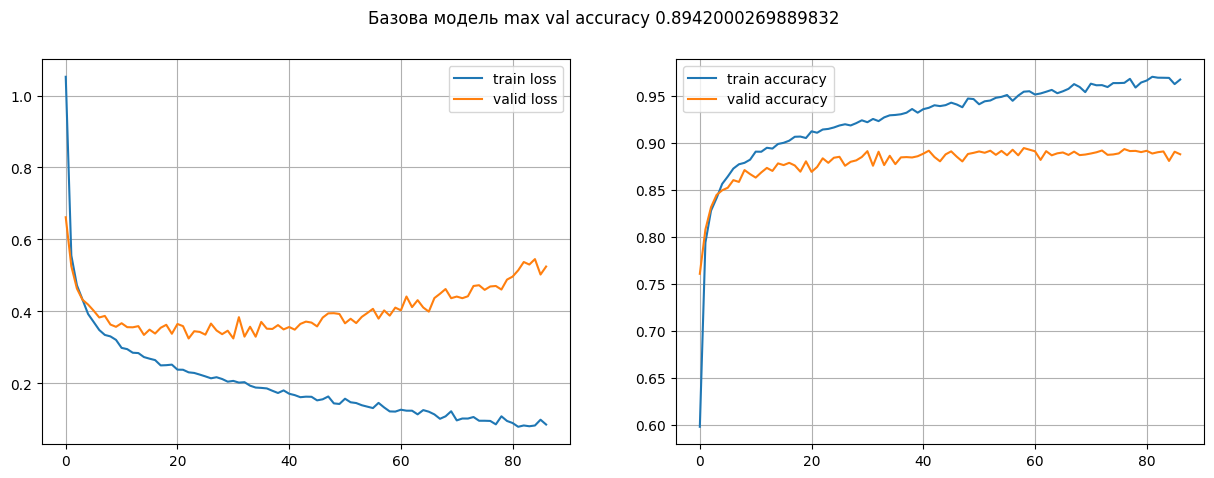

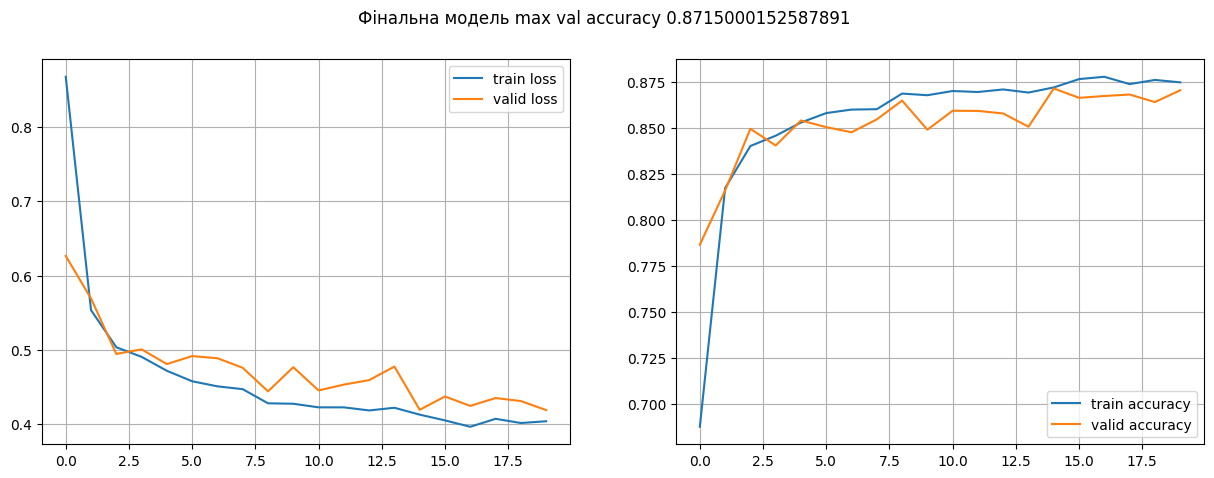

In [81]:
layers_dl1l2 = [
    Dense(500, "relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-5)),
    Dropout(0.1),
    Dense(250, "relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-5)),
    Dropout(0.1),
    Dense(100, "relu")
]

final_seeds = [random.randint(0, 2**32-1) for i in range(180)]
ds_final = MyDataset2(train_X, train_Y, 500, True, seeds=final_seeds)
model_final = create_model(layers=layers_dl1l2, optimizer=AdamW, lr=0.01)
history_final = fit_model(model_final, ds_final, (test_X, test_Y), epochs=180, add_early_stopping=True, verbose=1, add_save=True)

present_histiry("Базова модель", base_history2)
present_histiry("Фінальна модель", history_final)



Датасет направду дає старт з вельми адекватних показників якості моделі. Може в тому і є проблема і модель десь падає в локальну яму, з якої не може вилізти.

Збільшимо дропаут, зменшимо L1L2, проженемо без ранньї зупинки

Epoch 1/180
118/120 [============================>.] - ETA: 0s - loss: 0.9574 - categorical_accuracy: 0.6303
Epoch 1: val_loss improved from inf to 0.63531, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 40ms/step - loss: 0.9514 - categorical_accuracy: 0.6326 - val_loss: 0.6353 - val_categorical_accuracy: 0.7683
Epoch 2/180
118/120 [============================>.] - ETA: 0s - loss: 0.5629 - categorical_accuracy: 0.8062
Epoch 2: val_loss improved from 0.63531 to 0.51861, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 5s 38ms/step - loss: 0.5617 - categorical_accuracy: 0.8067 - val_loss: 0.5186 - val_categorical_accuracy: 0.8175
Epoch 3/180
119/120 [============================>.] - ETA: 0s - loss: 0.4947 - categorical_accuracy: 0.8328
Epoch 3: val_loss improved from 0.51861 to 0.51627, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.4946 - categorical_accuracy: 0.8329 - val_loss: 0.5163 - val_categorical_accuracy: 0.8248
Epoch 4/180
119/120 [============================>.] - ETA: 0s - loss: 0.4635 - categorical_accuracy: 0.8454
Epoch 4: val_loss improved from 0.51627 to 0.48584, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.4635 - categorical_accuracy: 0.8454 - val_loss: 0.4858 - val_categorical_accuracy: 0.8377
Epoch 5/180
119/120 [============================>.] - ETA: 0s - loss: 0.4463 - categorical_accuracy: 0.8524
Epoch 5: val_loss improved from 0.48584 to 0.43818, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.4462 - categorical_accuracy: 0.8524 - val_loss: 0.4382 - val_categorical_accuracy: 0.8572
Epoch 6/180
119/120 [============================>.] - ETA: 0s - loss: 0.4317 - categorical_accuracy: 0.8596
Epoch 6: val_loss did not improve from 0.43818
120/120 [==============================] - 4s 37ms/step - loss: 0.4315 - categorical_accuracy: 0.8596 - val_loss: 0.4451 - val_categorical_accuracy: 0.8515
Epoch 7/180
119/120 [============================>.] - ETA: 0s - loss: 0.4248 - categorical_accuracy: 0.8621
Epoch 7: val_loss did not improve from 0.43818
120/120 [==============================] - 4s 36ms/step - loss: 0.4245 - categorical_accuracy: 0.8622 - val_loss: 0.4487 - val_categorical_accuracy: 0.8534
Epoch 8/180
119/120 [============================>.] - ETA: 0s - loss: 0.4223 - categorical_accuracy: 0.8638
Epoch 8: val_loss improved from 0.43818 to 0.42427, saving model to best_model
INFO:tensorflow:Assets written t

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 51ms/step - loss: 0.4225 - categorical_accuracy: 0.8637 - val_loss: 0.4243 - val_categorical_accuracy: 0.8619
Epoch 9/180
120/120 [==============================] - ETA: 0s - loss: 0.4150 - categorical_accuracy: 0.8650
Epoch 9: val_loss improved from 0.42427 to 0.42184, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.4150 - categorical_accuracy: 0.8650 - val_loss: 0.4218 - val_categorical_accuracy: 0.8644
Epoch 10/180
120/120 [==============================] - ETA: 0s - loss: 0.4096 - categorical_accuracy: 0.8680
Epoch 10: val_loss did not improve from 0.42184
120/120 [==============================] - 4s 36ms/step - loss: 0.4096 - categorical_accuracy: 0.8680 - val_loss: 0.4268 - val_categorical_accuracy: 0.8637
Epoch 11/180
120/120 [==============================] - ETA: 0s - loss: 0.4086 - categorical_accuracy: 0.8692
Epoch 11: val_loss did not improve from 0.42184
120/120 [==============================] - 4s 36ms/step - loss: 0.4086 - categorical_accuracy: 0.8692 - val_loss: 0.4249 - val_categorical_accuracy: 0.8648
Epoch 12/180
120/120 [==============================] - ETA: 0s - loss: 0.4051 - categorical_accuracy: 0.8702
Epoch 12: val_loss improved from 0.42184 to 0.41529, saving model to best_model
INFO:tensorflow:Assets wri

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.4051 - categorical_accuracy: 0.8702 - val_loss: 0.4153 - val_categorical_accuracy: 0.8678
Epoch 13/180
120/120 [==============================] - ETA: 0s - loss: 0.3981 - categorical_accuracy: 0.8709
Epoch 13: val_loss did not improve from 0.41529
120/120 [==============================] - 4s 36ms/step - loss: 0.3981 - categorical_accuracy: 0.8709 - val_loss: 0.4226 - val_categorical_accuracy: 0.8658
Epoch 14/180
119/120 [============================>.] - ETA: 0s - loss: 0.3912 - categorical_accuracy: 0.8743
Epoch 14: val_loss improved from 0.41529 to 0.40325, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.3908 - categorical_accuracy: 0.8745 - val_loss: 0.4033 - val_categorical_accuracy: 0.8714
Epoch 15/180
119/120 [============================>.] - ETA: 0s - loss: 0.3843 - categorical_accuracy: 0.8777
Epoch 15: val_loss did not improve from 0.40325
120/120 [==============================] - 4s 35ms/step - loss: 0.3845 - categorical_accuracy: 0.8777 - val_loss: 0.4372 - val_categorical_accuracy: 0.8559
Epoch 16/180
119/120 [============================>.] - ETA: 0s - loss: 0.3897 - categorical_accuracy: 0.8735
Epoch 16: val_loss did not improve from 0.40325
120/120 [==============================] - 4s 35ms/step - loss: 0.3898 - categorical_accuracy: 0.8734 - val_loss: 0.4097 - val_categorical_accuracy: 0.8716
Epoch 17/180
120/120 [==============================] - ETA: 0s - loss: 0.3841 - categorical_accuracy: 0.8774
Epoch 17: val_loss did not improve from 0.40325
120/120 [==============================] - 4s 34ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.3840 - categorical_accuracy: 0.8773 - val_loss: 0.4027 - val_categorical_accuracy: 0.8737
Epoch 19/180
119/120 [============================>.] - ETA: 0s - loss: 0.3922 - categorical_accuracy: 0.8744
Epoch 19: val_loss did not improve from 0.40275
120/120 [==============================] - 4s 34ms/step - loss: 0.3923 - categorical_accuracy: 0.8744 - val_loss: 0.4034 - val_categorical_accuracy: 0.8697
Epoch 20/180
120/120 [==============================] - ETA: 0s - loss: 0.3843 - categorical_accuracy: 0.8769
Epoch 20: val_loss improved from 0.40275 to 0.39334, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 5s 45ms/step - loss: 0.3843 - categorical_accuracy: 0.8769 - val_loss: 0.3933 - val_categorical_accuracy: 0.8747
Epoch 21/180
119/120 [============================>.] - ETA: 0s - loss: 0.3798 - categorical_accuracy: 0.8784
Epoch 21: val_loss did not improve from 0.39334
120/120 [==============================] - 4s 33ms/step - loss: 0.3800 - categorical_accuracy: 0.8783 - val_loss: 0.4042 - val_categorical_accuracy: 0.8719
Epoch 22/180
119/120 [============================>.] - ETA: 0s - loss: 0.3807 - categorical_accuracy: 0.8778
Epoch 22: val_loss did not improve from 0.39334
120/120 [==============================] - 4s 33ms/step - loss: 0.3809 - categorical_accuracy: 0.8778 - val_loss: 0.4027 - val_categorical_accuracy: 0.8722
Epoch 23/180
120/120 [==============================] - ETA: 0s - loss: 0.3814 - categorical_accuracy: 0.8773
Epoch 23: val_loss did not improve from 0.39334
120/120 [==============================] - 4s 33ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.3690 - categorical_accuracy: 0.8807 - val_loss: 0.3866 - val_categorical_accuracy: 0.8762
Epoch 31/180
119/120 [============================>.] - ETA: 0s - loss: 0.3654 - categorical_accuracy: 0.8835
Epoch 31: val_loss did not improve from 0.38664
120/120 [==============================] - 4s 32ms/step - loss: 0.3649 - categorical_accuracy: 0.8838 - val_loss: 0.4013 - val_categorical_accuracy: 0.8745
Epoch 32/180
120/120 [==============================] - ETA: 0s - loss: 0.3620 - categorical_accuracy: 0.8837
Epoch 32: val_loss improved from 0.38664 to 0.38075, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 5s 44ms/step - loss: 0.3620 - categorical_accuracy: 0.8837 - val_loss: 0.3807 - val_categorical_accuracy: 0.8805
Epoch 33/180
119/120 [============================>.] - ETA: 0s - loss: 0.3661 - categorical_accuracy: 0.8831
Epoch 33: val_loss did not improve from 0.38075
120/120 [==============================] - 4s 33ms/step - loss: 0.3660 - categorical_accuracy: 0.8833 - val_loss: 0.3822 - val_categorical_accuracy: 0.8758
Epoch 34/180
120/120 [==============================] - ETA: 0s - loss: 0.3675 - categorical_accuracy: 0.8823
Epoch 34: val_loss did not improve from 0.38075
120/120 [==============================] - 4s 33ms/step - loss: 0.3675 - categorical_accuracy: 0.8823 - val_loss: 0.4004 - val_categorical_accuracy: 0.8714
Epoch 35/180
119/120 [============================>.] - ETA: 0s - loss: 0.3677 - categorical_accuracy: 0.8820
Epoch 35: val_loss did not improve from 0.38075
120/120 [==============================] - 4s 34ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 48ms/step - loss: 0.3553 - categorical_accuracy: 0.8856 - val_loss: 0.3785 - val_categorical_accuracy: 0.8805
Epoch 39/180
120/120 [==============================] - ETA: 0s - loss: 0.3551 - categorical_accuracy: 0.8854
Epoch 39: val_loss did not improve from 0.37850
120/120 [==============================] - 4s 33ms/step - loss: 0.3551 - categorical_accuracy: 0.8854 - val_loss: 0.3804 - val_categorical_accuracy: 0.8776
Epoch 40/180
120/120 [==============================] - ETA: 0s - loss: 0.3589 - categorical_accuracy: 0.8832
Epoch 40: val_loss did not improve from 0.37850
120/120 [==============================] - 4s 33ms/step - loss: 0.3589 - categorical_accuracy: 0.8832 - val_loss: 0.4064 - val_categorical_accuracy: 0.8701
Epoch 41/180
120/120 [==============================] - ETA: 0s - loss: 0.3594 - categorical_accuracy: 0.8842
Epoch 41: val_loss did not improve from 0.37850
120/120 [==============================] - 4s 33ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 46ms/step - loss: 0.3514 - categorical_accuracy: 0.8880 - val_loss: 0.3760 - val_categorical_accuracy: 0.8812
Epoch 48/180
120/120 [==============================] - ETA: 0s - loss: 0.3544 - categorical_accuracy: 0.8860
Epoch 48: val_loss did not improve from 0.37604
120/120 [==============================] - 4s 33ms/step - loss: 0.3544 - categorical_accuracy: 0.8860 - val_loss: 0.3895 - val_categorical_accuracy: 0.8749
Epoch 49/180
120/120 [==============================] - ETA: 0s - loss: 0.3577 - categorical_accuracy: 0.8856
Epoch 49: val_loss did not improve from 0.37604
120/120 [==============================] - 4s 33ms/step - loss: 0.3577 - categorical_accuracy: 0.8856 - val_loss: 0.3863 - val_categorical_accuracy: 0.8763
Epoch 50/180
120/120 [==============================] - ETA: 0s - loss: 0.3496 - categorical_accuracy: 0.8885
Epoch 50: val_loss did not improve from 0.37604
120/120 [==============================] - 4s 35ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 51ms/step - loss: 0.3497 - categorical_accuracy: 0.8868 - val_loss: 0.3753 - val_categorical_accuracy: 0.8808
Epoch 60/180
119/120 [============================>.] - ETA: 0s - loss: 0.3431 - categorical_accuracy: 0.8910
Epoch 60: val_loss did not improve from 0.37528
120/120 [==============================] - 4s 37ms/step - loss: 0.3430 - categorical_accuracy: 0.8911 - val_loss: 0.3855 - val_categorical_accuracy: 0.8807
Epoch 61/180
120/120 [==============================] - ETA: 0s - loss: 0.3445 - categorical_accuracy: 0.8901
Epoch 61: val_loss did not improve from 0.37528
120/120 [==============================] - 4s 36ms/step - loss: 0.3445 - categorical_accuracy: 0.8901 - val_loss: 0.3898 - val_categorical_accuracy: 0.8772
Epoch 62/180
119/120 [============================>.] - ETA: 0s - loss: 0.3520 - categorical_accuracy: 0.8874
Epoch 62: val_loss did not improve from 0.37528
120/120 [==============================] - 4s 36ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.3361 - categorical_accuracy: 0.8944 - val_loss: 0.3722 - val_categorical_accuracy: 0.8825
Epoch 77/180
120/120 [==============================] - ETA: 0s - loss: 0.3385 - categorical_accuracy: 0.8923
Epoch 77: val_loss did not improve from 0.37221
120/120 [==============================] - 4s 35ms/step - loss: 0.3385 - categorical_accuracy: 0.8923 - val_loss: 0.3830 - val_categorical_accuracy: 0.8814
Epoch 78/180
120/120 [==============================] - ETA: 0s - loss: 0.3365 - categorical_accuracy: 0.8935
Epoch 78: val_loss did not improve from 0.37221
120/120 [==============================] - 4s 33ms/step - loss: 0.3365 - categorical_accuracy: 0.8935 - val_loss: 0.3855 - val_categorical_accuracy: 0.8785
Epoch 79/180
120/120 [==============================] - ETA: 0s - loss: 0.3414 - categorical_accuracy: 0.8927
Epoch 79: val_loss did not improve from 0.37221
120/120 [==============================] - 4s 33ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.3373 - categorical_accuracy: 0.8931 - val_loss: 0.3691 - val_categorical_accuracy: 0.8850
Epoch 81/180
120/120 [==============================] - ETA: 0s - loss: 0.3351 - categorical_accuracy: 0.8943
Epoch 81: val_loss did not improve from 0.36907
120/120 [==============================] - 4s 33ms/step - loss: 0.3351 - categorical_accuracy: 0.8943 - val_loss: 0.3779 - val_categorical_accuracy: 0.8821
Epoch 82/180
120/120 [==============================] - ETA: 0s - loss: 0.3360 - categorical_accuracy: 0.8932
Epoch 82: val_loss did not improve from 0.36907
120/120 [==============================] - 4s 34ms/step - loss: 0.3360 - categorical_accuracy: 0.8932 - val_loss: 0.3734 - val_categorical_accuracy: 0.8843
Epoch 83/180
119/120 [============================>.] - ETA: 0s - loss: 0.3435 - categorical_accuracy: 0.8908
Epoch 83: val_loss did not improve from 0.36907
120/120 [==============================] - 4s 34ms/step - 

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 47ms/step - loss: 0.3358 - categorical_accuracy: 0.8940 - val_loss: 0.3666 - val_categorical_accuracy: 0.8878
Epoch 122/180
120/120 [==============================] - ETA: 0s - loss: 0.3301 - categorical_accuracy: 0.8958
Epoch 122: val_loss did not improve from 0.36661
120/120 [==============================] - 4s 33ms/step - loss: 0.3301 - categorical_accuracy: 0.8958 - val_loss: 0.3887 - val_categorical_accuracy: 0.8791
Epoch 123/180
120/120 [==============================] - ETA: 0s - loss: 0.3360 - categorical_accuracy: 0.8934
Epoch 123: val_loss did not improve from 0.36661
120/120 [==============================] - 4s 33ms/step - loss: 0.3360 - categorical_accuracy: 0.8934 - val_loss: 0.3742 - val_categorical_accuracy: 0.8821
Epoch 124/180
120/120 [==============================] - ETA: 0s - loss: 0.3338 - categorical_accuracy: 0.8938
Epoch 124: val_loss did not improve from 0.36661
120/120 [==============================] - 4s 34ms/s

INFO:tensorflow:Assets written to: best_model\assets


120/120 [==============================] - 6s 49ms/step - loss: 0.3353 - categorical_accuracy: 0.8943 - val_loss: 0.3654 - val_categorical_accuracy: 0.8852
Epoch 180/180
120/120 [==============================] - ETA: 0s - loss: 0.3285 - categorical_accuracy: 0.8973
Epoch 180: val_loss did not improve from 0.36537
120/120 [==============================] - 5s 38ms/step - loss: 0.3285 - categorical_accuracy: 0.8973 - val_loss: 0.3768 - val_categorical_accuracy: 0.8819


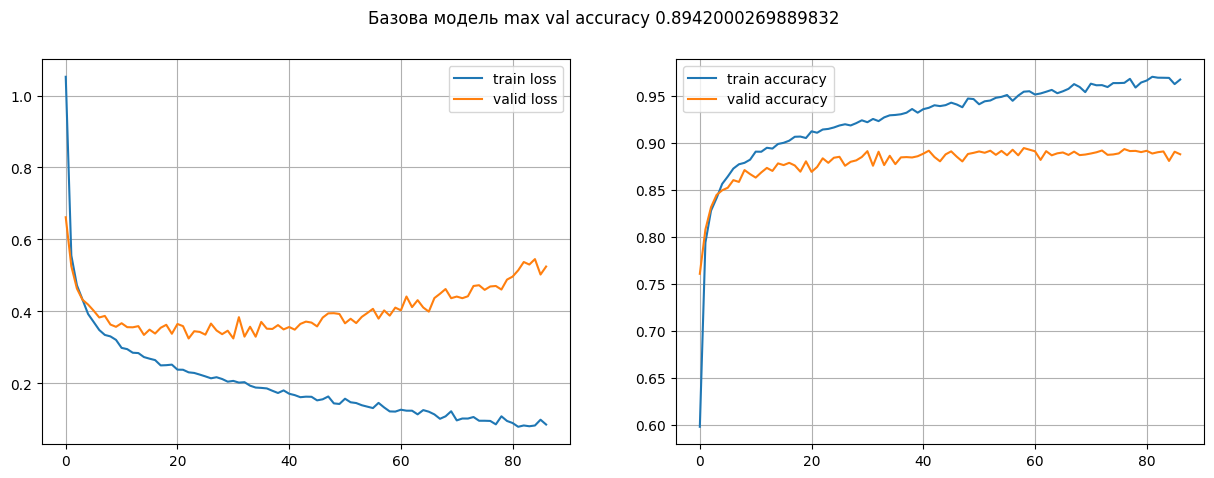

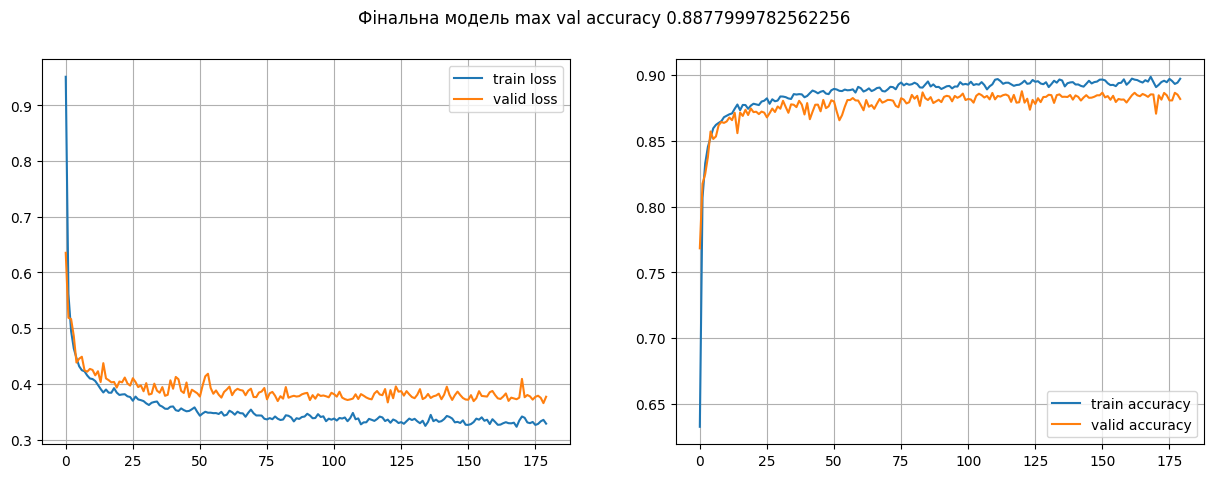

In [83]:
layers_dl1l2 = [
    Dense(500, "relu", input_shape=(28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6)),
    Dropout(0.2),
    Dense(250, "relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6)),
    Dropout(0.2),
    Dense(100, "relu")
]

final_seeds = [random.randint(0, 2**32-1) for i in range(180)]
ds_final = MyDataset2(train_X, train_Y, 500, False, seeds=final_seeds)
model_final = create_model(layers=layers_dl1l2, optimizer=AdamW, lr=0.01)
history_final = fit_model(model_final, ds_final, (test_X, test_Y), epochs=180, add_early_stopping=False, verbose=1, add_save=True)

present_histiry("Базова модель", base_history2)
present_histiry("Фінальна модель", history_final)


Чуда не сталось.

Спрощуємо модель, відмовляємось від цілеспрямованого впливу на перемішування, брутфорсимо

INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


INFO:tensorflow:Assets written to: best_model_0\assets


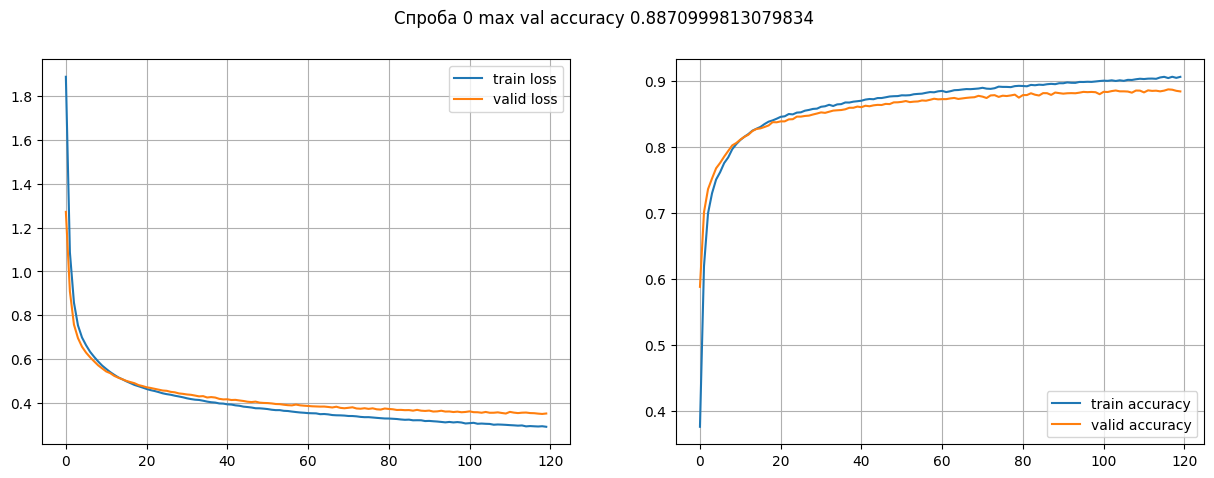

INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


INFO:tensorflow:Assets written to: best_model_1\assets


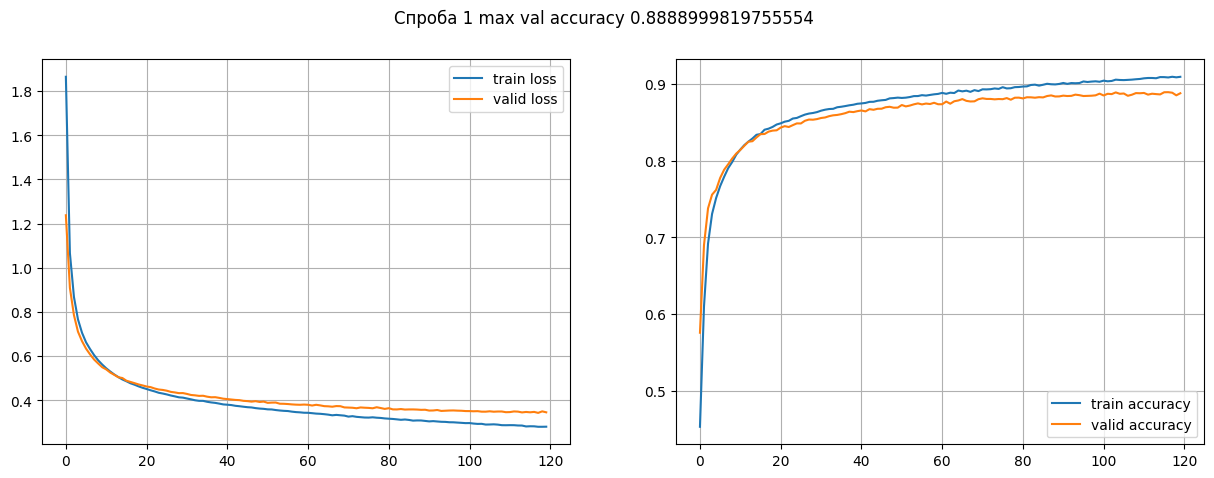

INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


INFO:tensorflow:Assets written to: best_model_2\assets


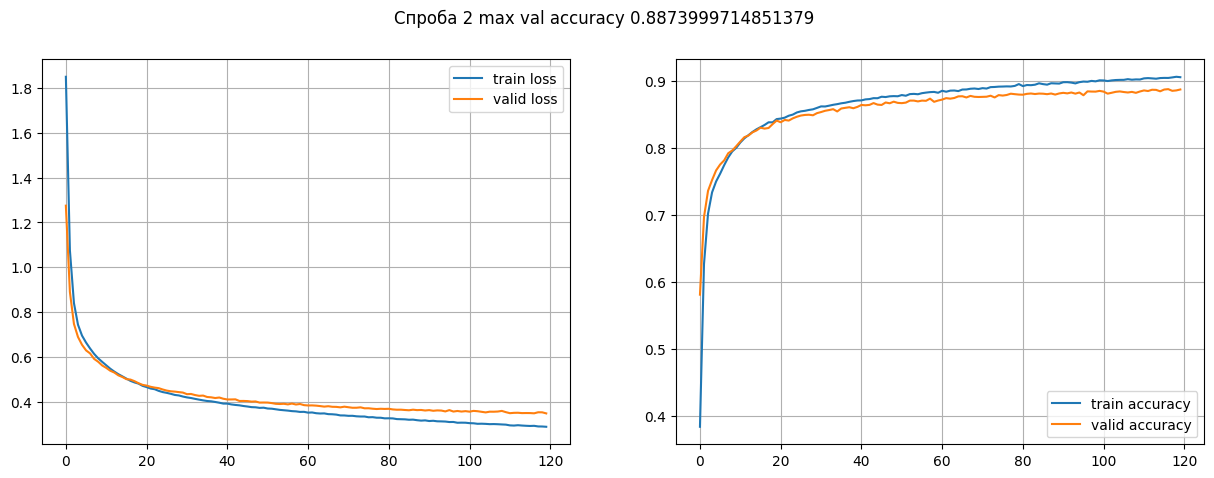

INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


INFO:tensorflow:Assets written to: best_model_3\assets


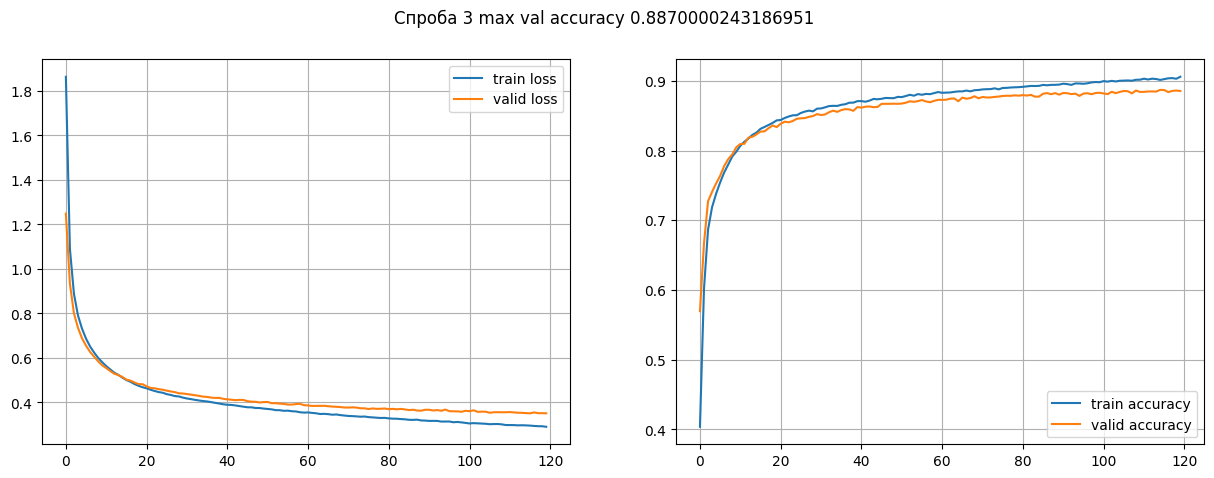

INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


INFO:tensorflow:Assets written to: best_model_4\assets


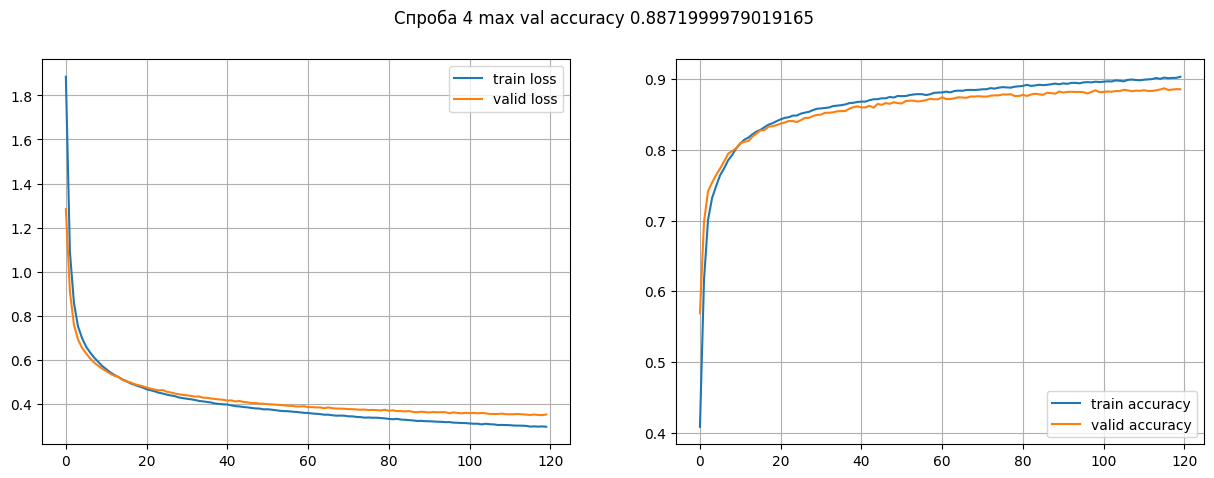

INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


INFO:tensorflow:Assets written to: best_model_5\assets


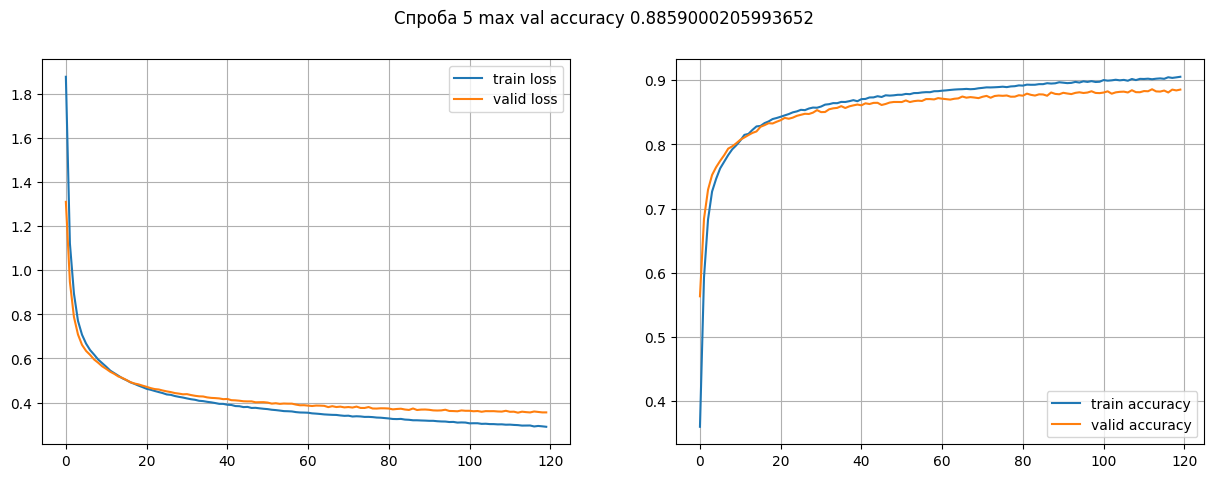

INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


INFO:tensorflow:Assets written to: best_model_6\assets


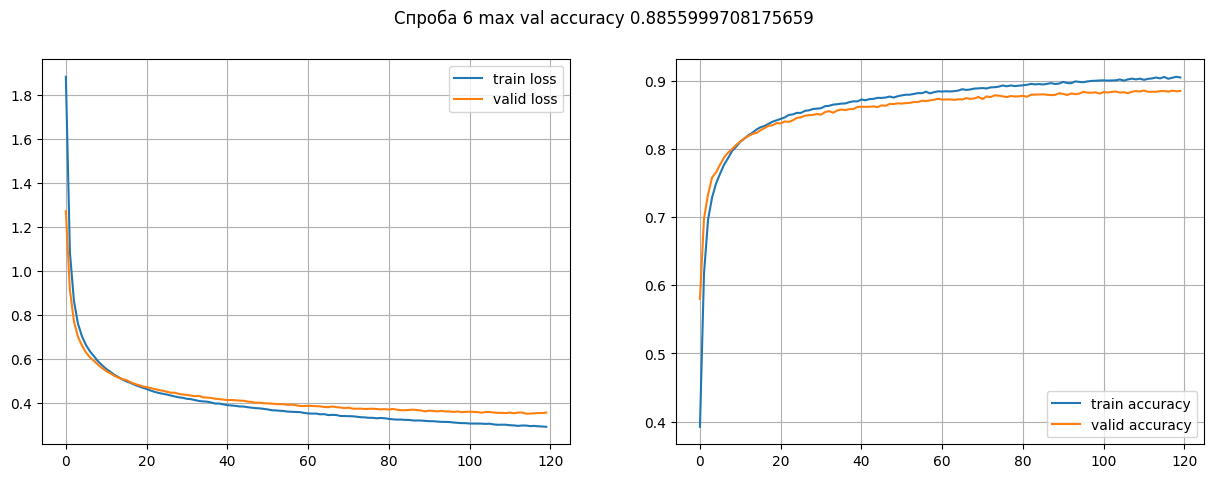

INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


INFO:tensorflow:Assets written to: best_model_7\assets


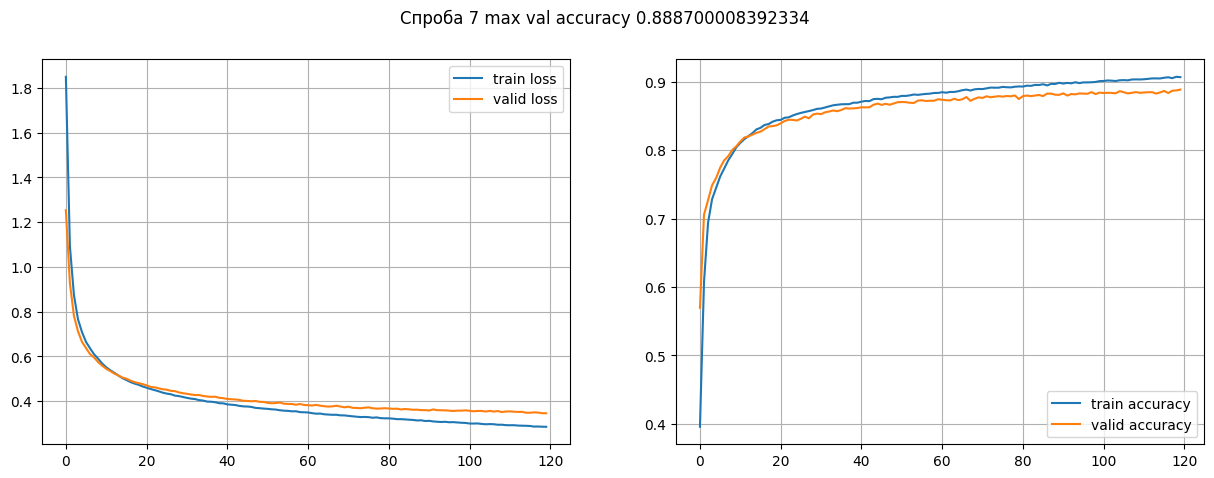

INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


INFO:tensorflow:Assets written to: best_model_8\assets


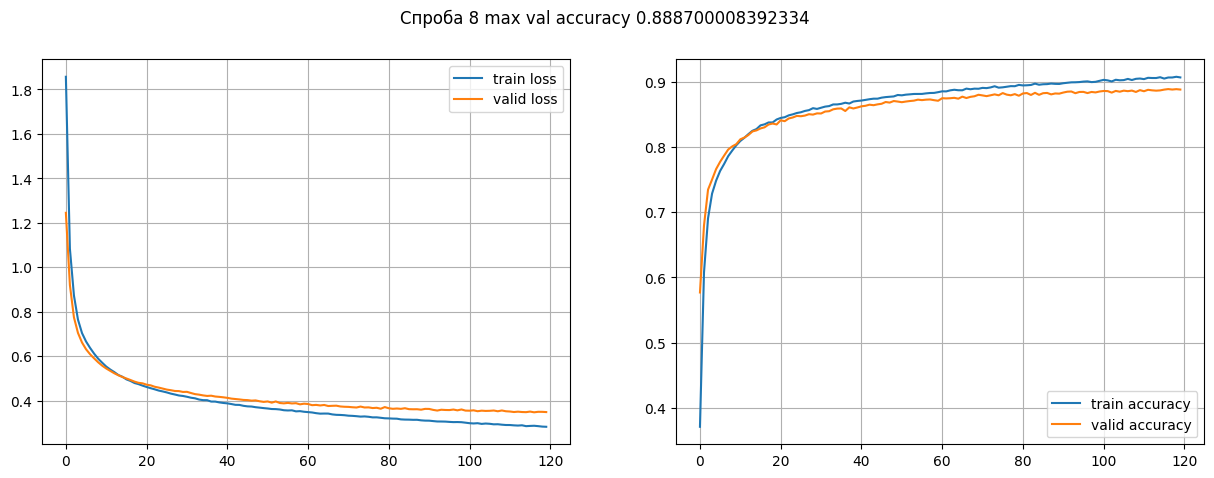

INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


INFO:tensorflow:Assets written to: best_model_9\assets


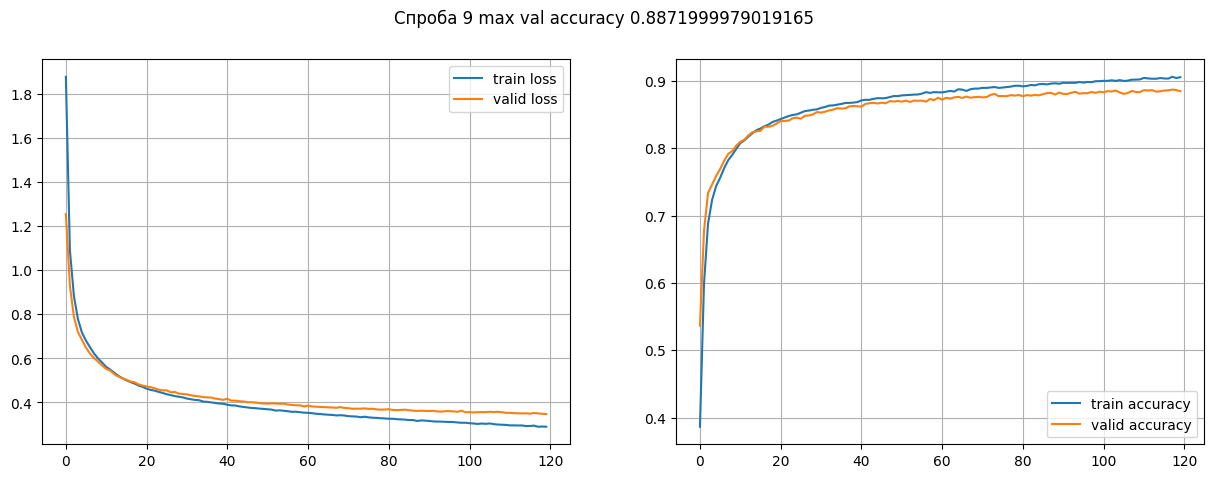

INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


INFO:tensorflow:Assets written to: best_model_10\assets


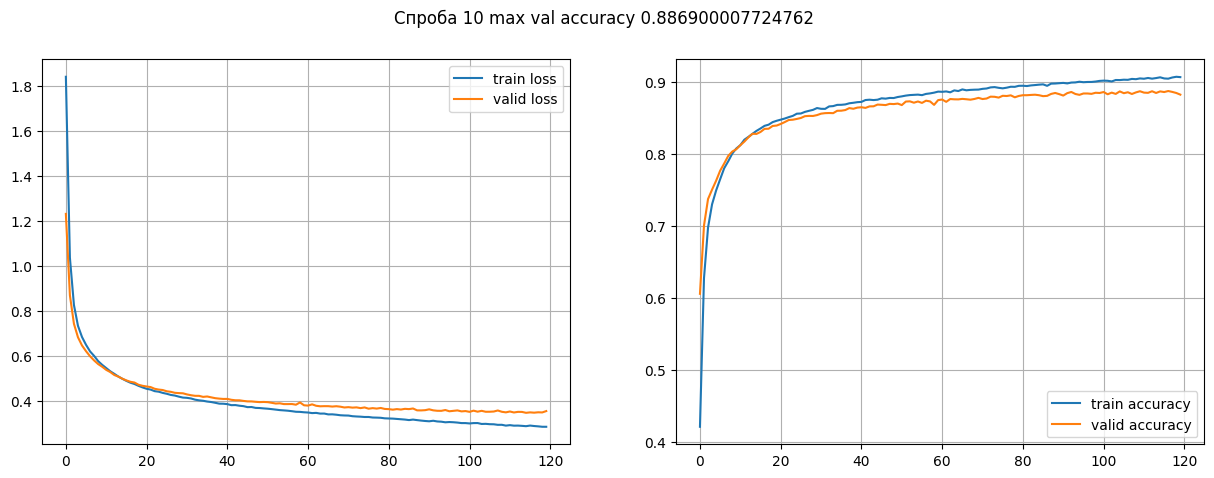

INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


INFO:tensorflow:Assets written to: best_model_11\assets


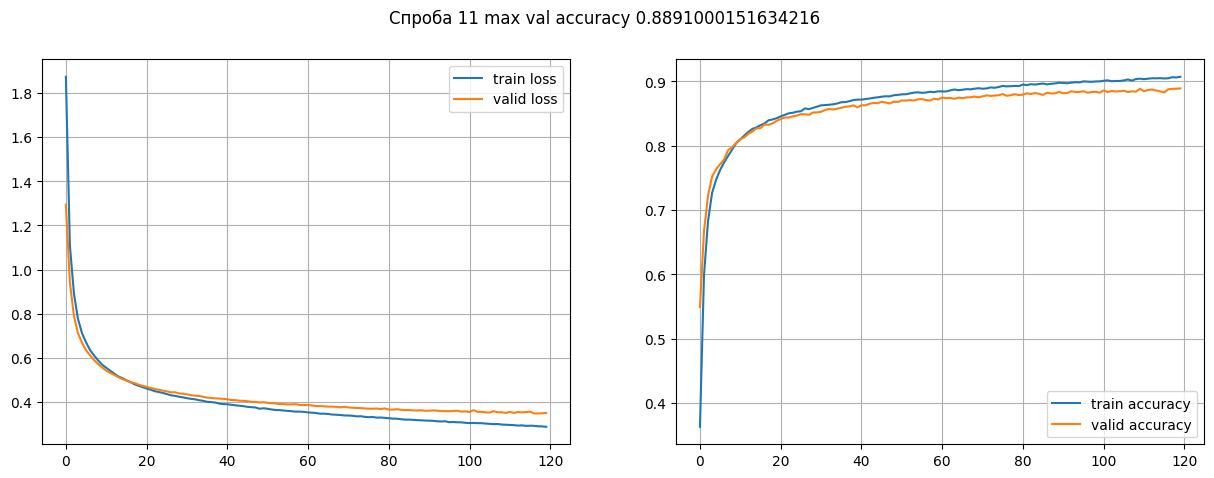

INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


INFO:tensorflow:Assets written to: best_model_12\assets


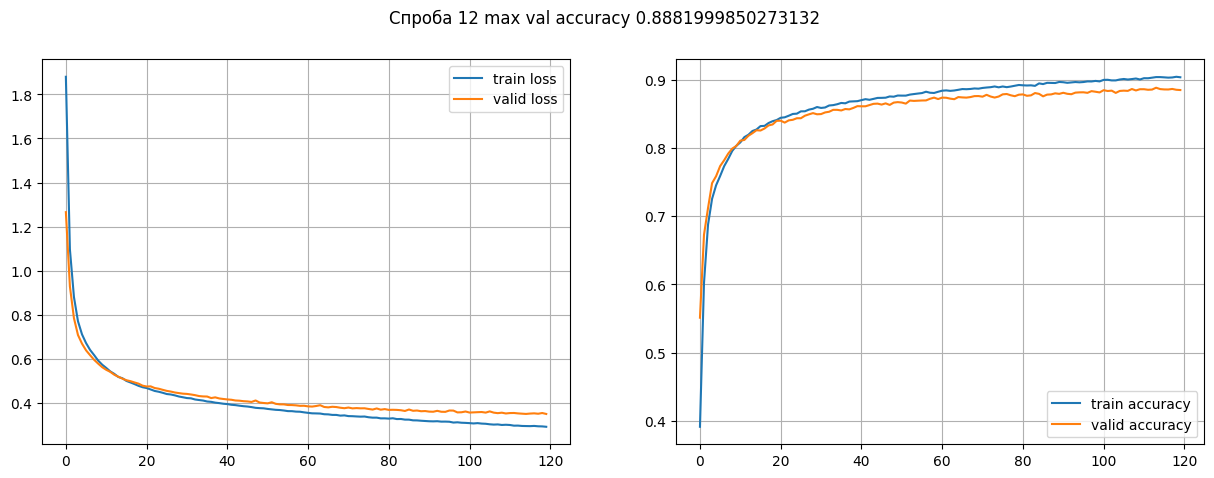

INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


INFO:tensorflow:Assets written to: best_model_13\assets


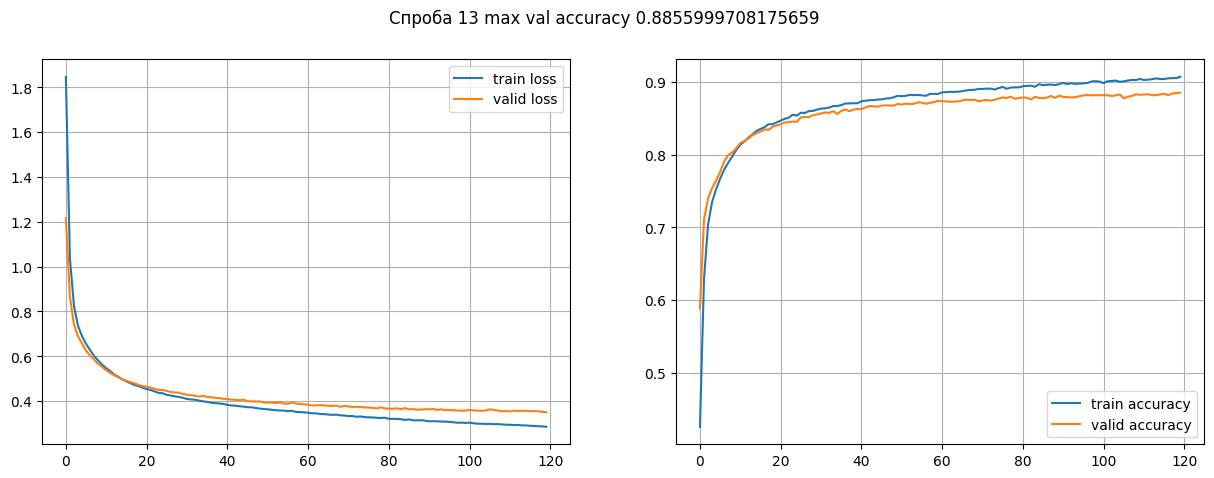

INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


INFO:tensorflow:Assets written to: best_model_14\assets


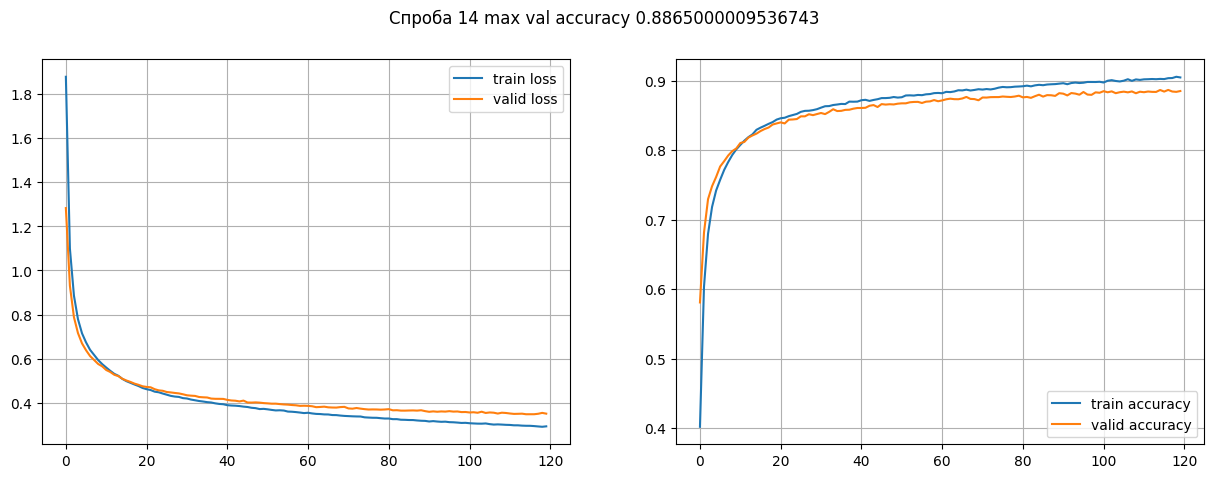

INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


INFO:tensorflow:Assets written to: best_model_15\assets


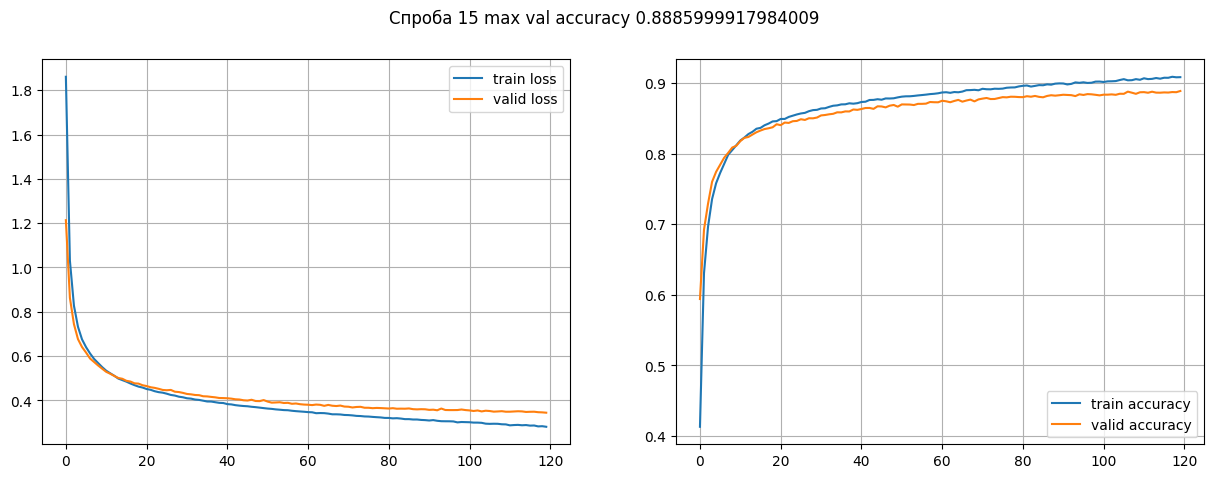

INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


INFO:tensorflow:Assets written to: best_model_16\assets


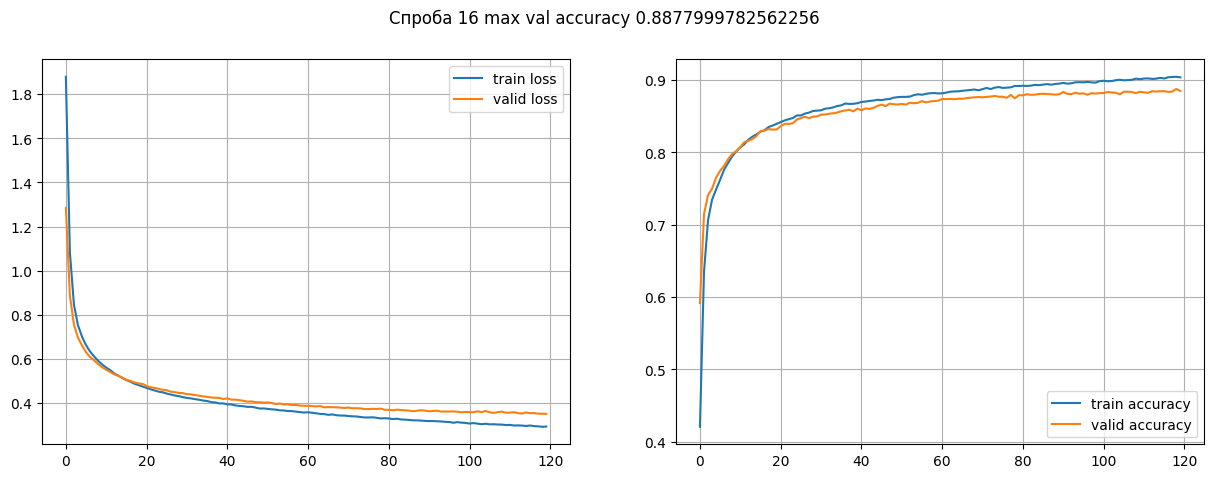

INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


INFO:tensorflow:Assets written to: best_model_17\assets


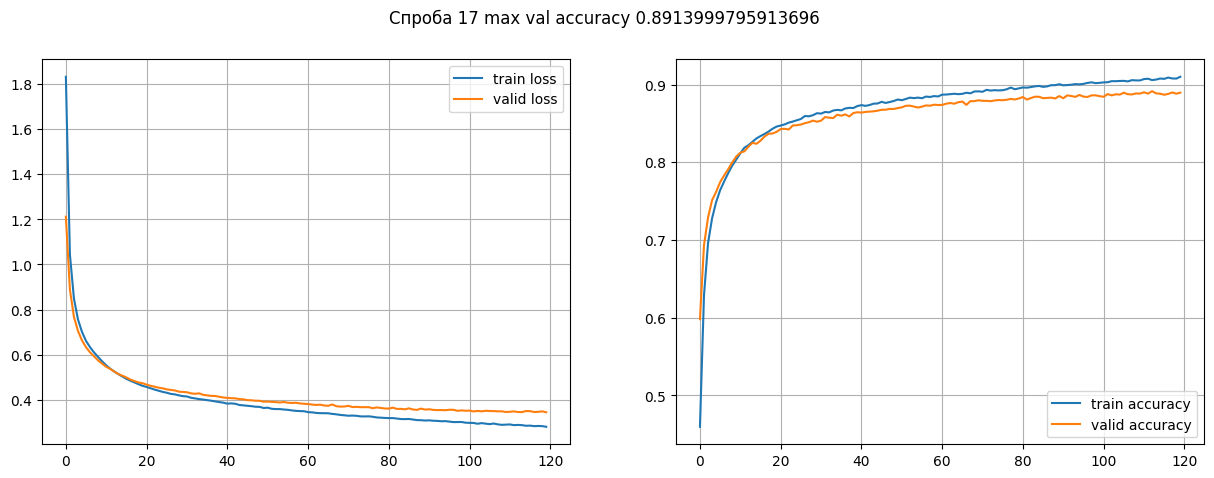

INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


INFO:tensorflow:Assets written to: best_model_18\assets


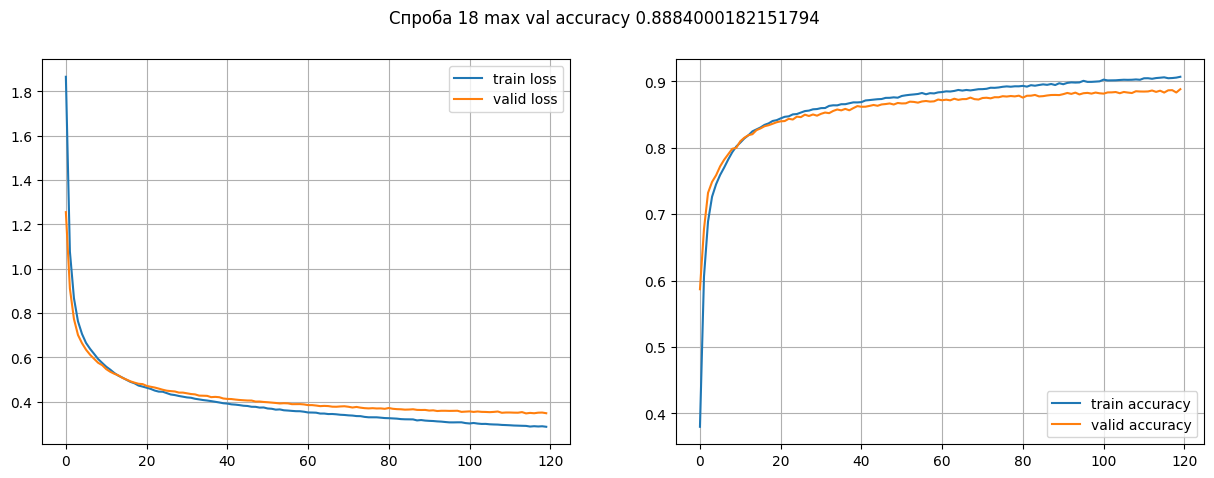

INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


INFO:tensorflow:Assets written to: best_model_19\assets


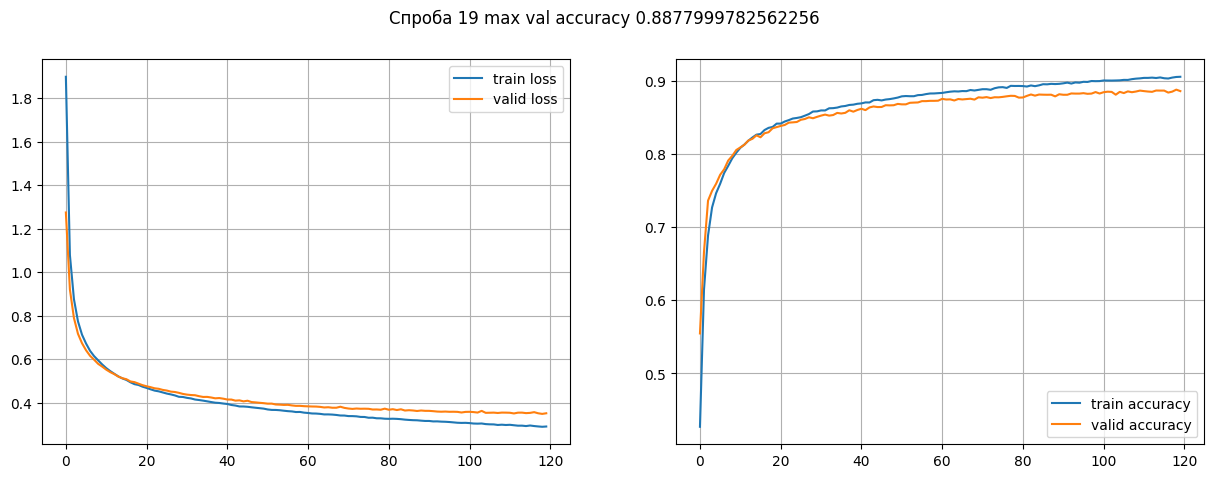

INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


INFO:tensorflow:Assets written to: best_model_20\assets


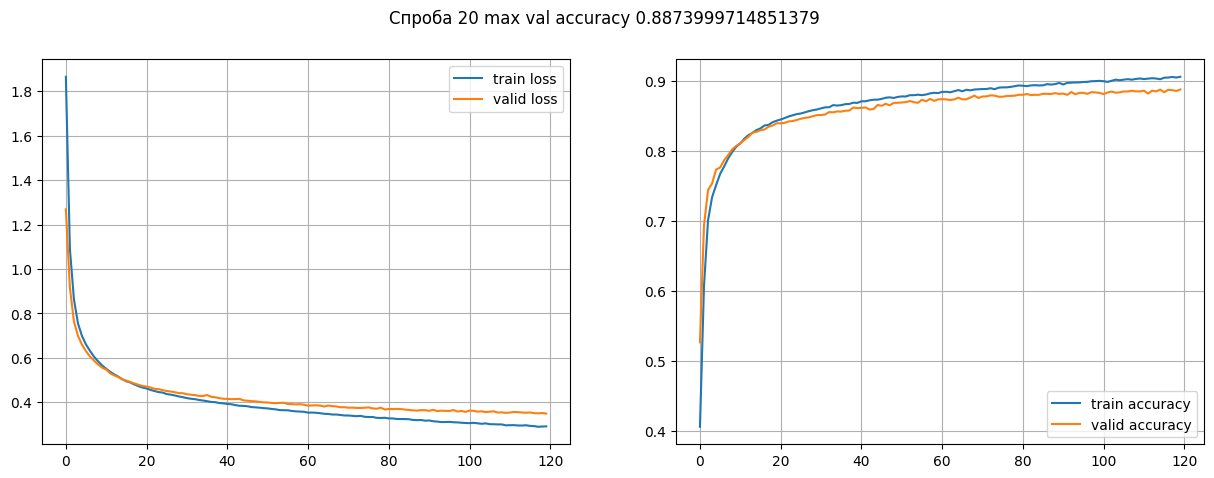

INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


INFO:tensorflow:Assets written to: best_model_21\assets


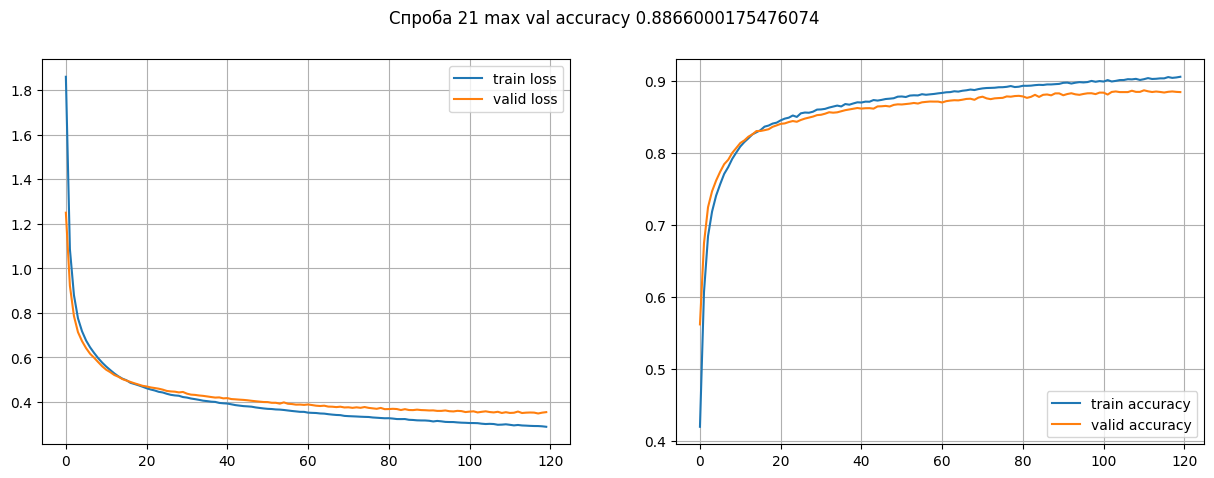

INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


INFO:tensorflow:Assets written to: best_model_22\assets


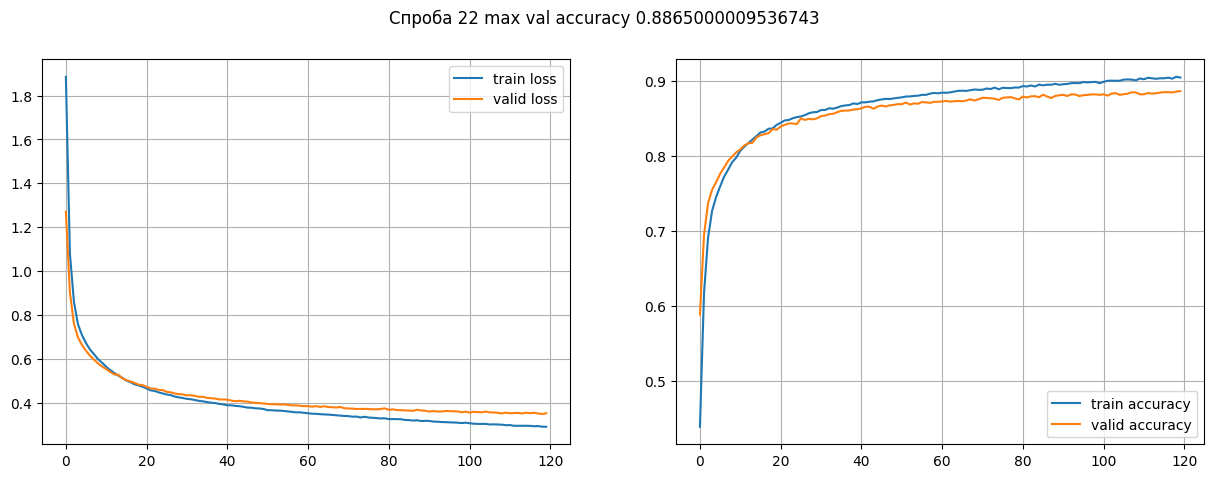

INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


INFO:tensorflow:Assets written to: best_model_23\assets


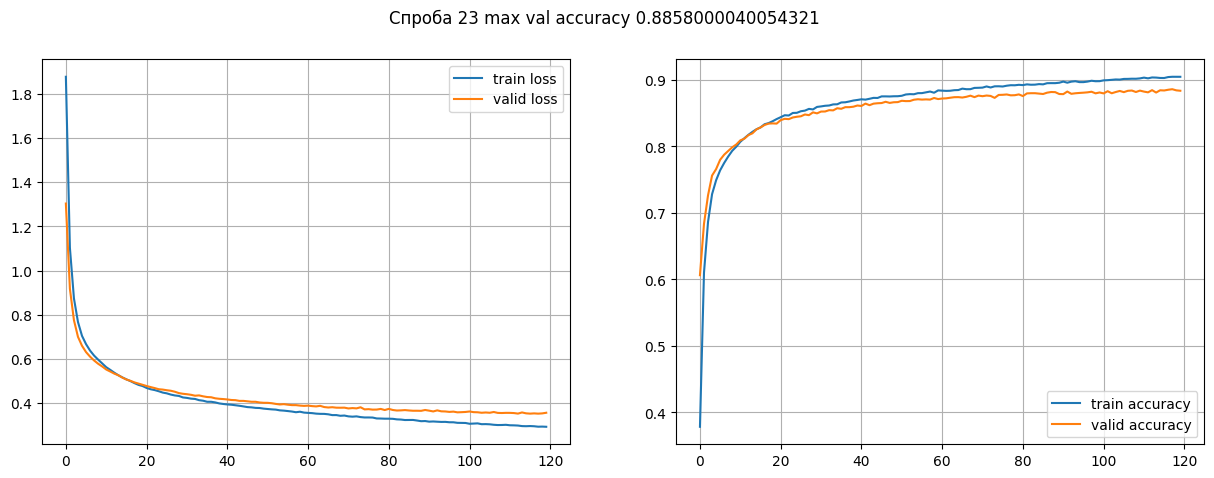

INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


INFO:tensorflow:Assets written to: best_model_24\assets


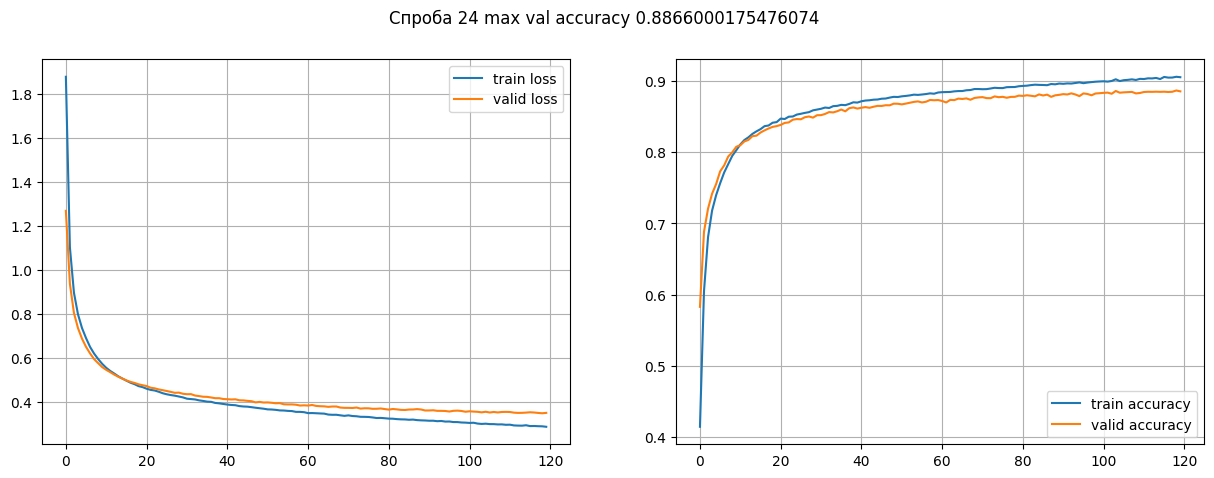

INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


INFO:tensorflow:Assets written to: best_model_25\assets


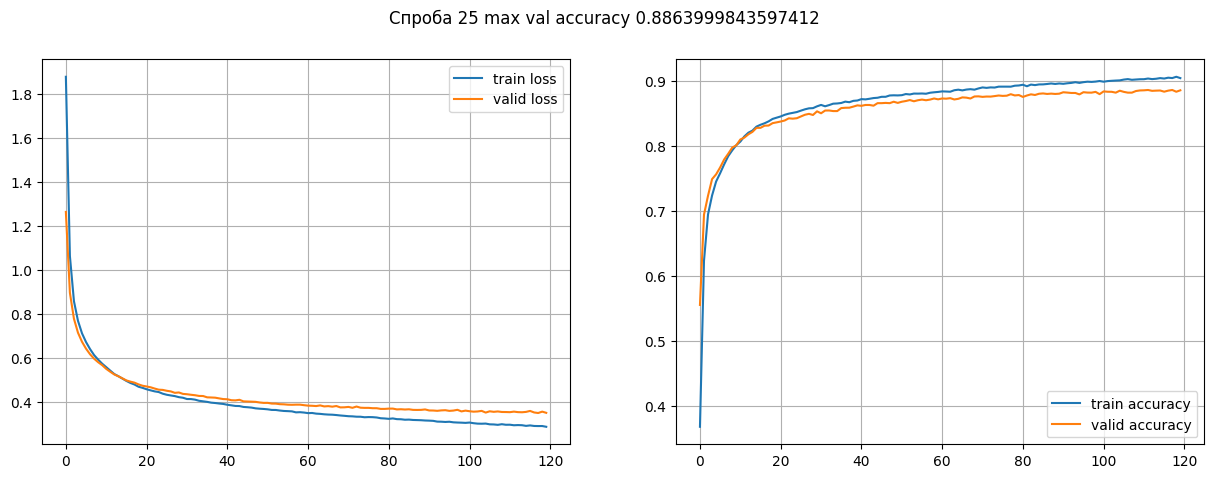

INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


INFO:tensorflow:Assets written to: best_model_26\assets


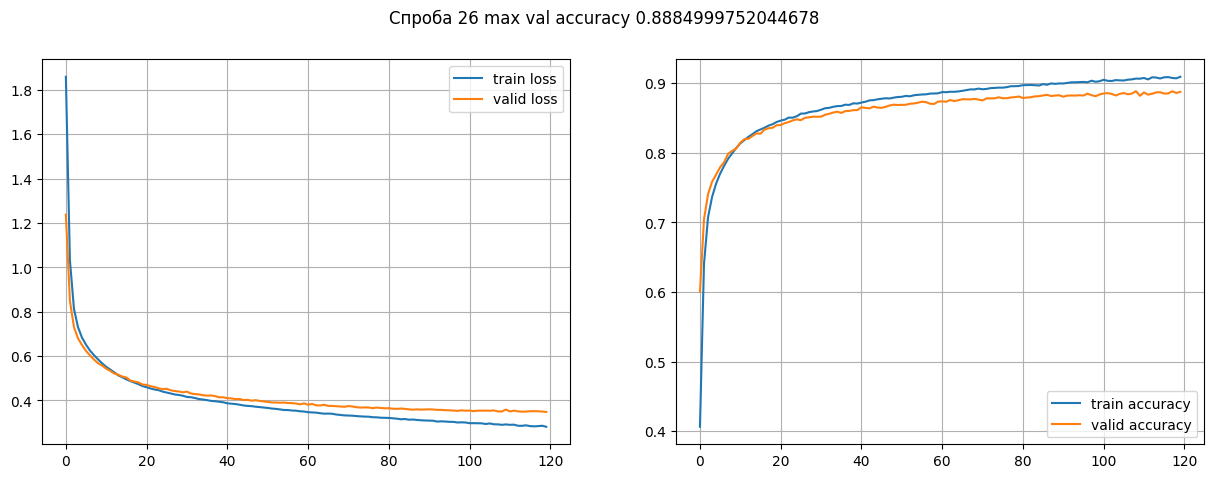

INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


INFO:tensorflow:Assets written to: best_model_27\assets


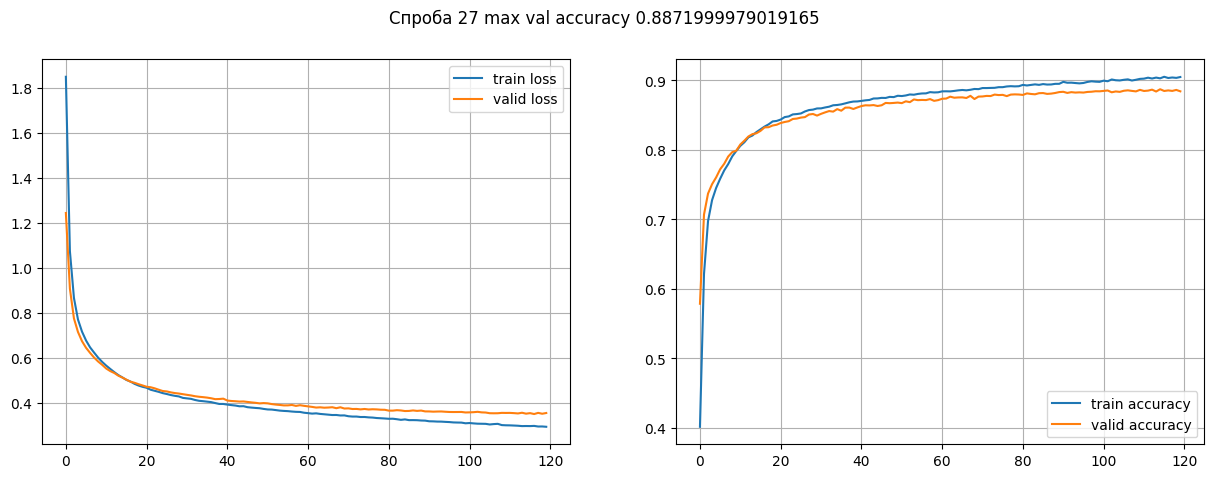

INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


INFO:tensorflow:Assets written to: best_model_28\assets


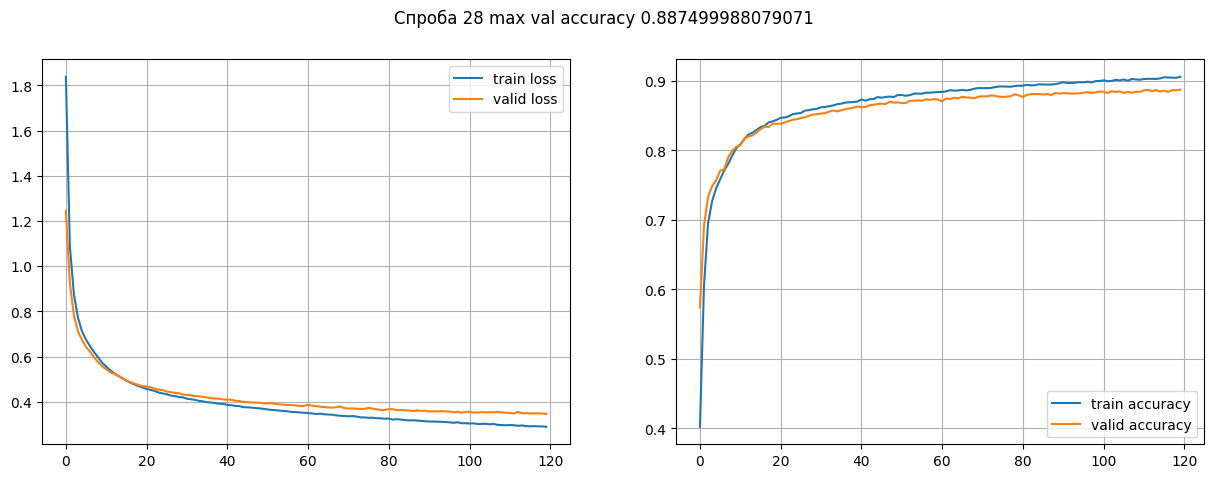

INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


INFO:tensorflow:Assets written to: best_model_29\assets


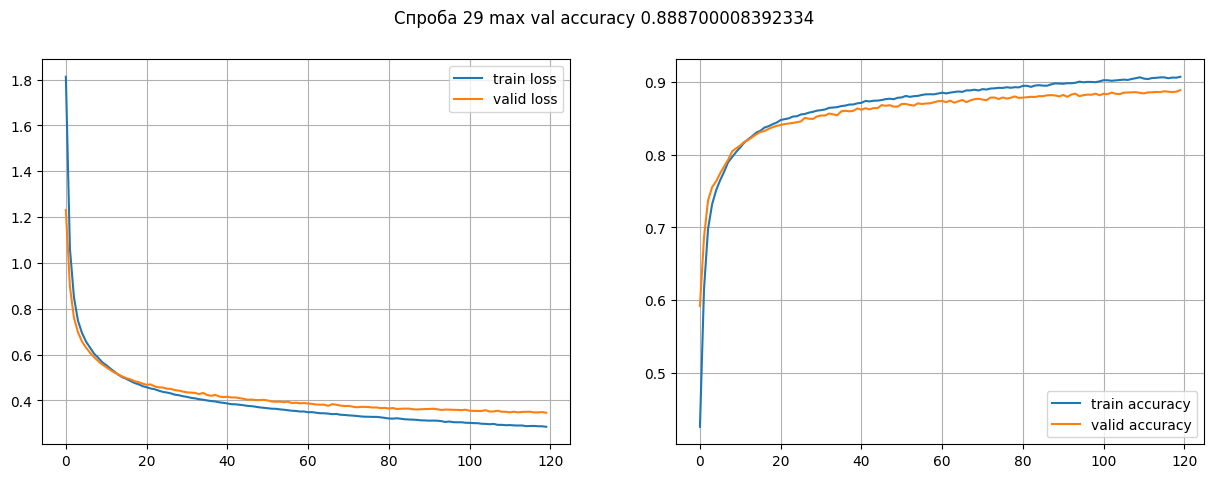

INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


INFO:tensorflow:Assets written to: best_model_30\assets


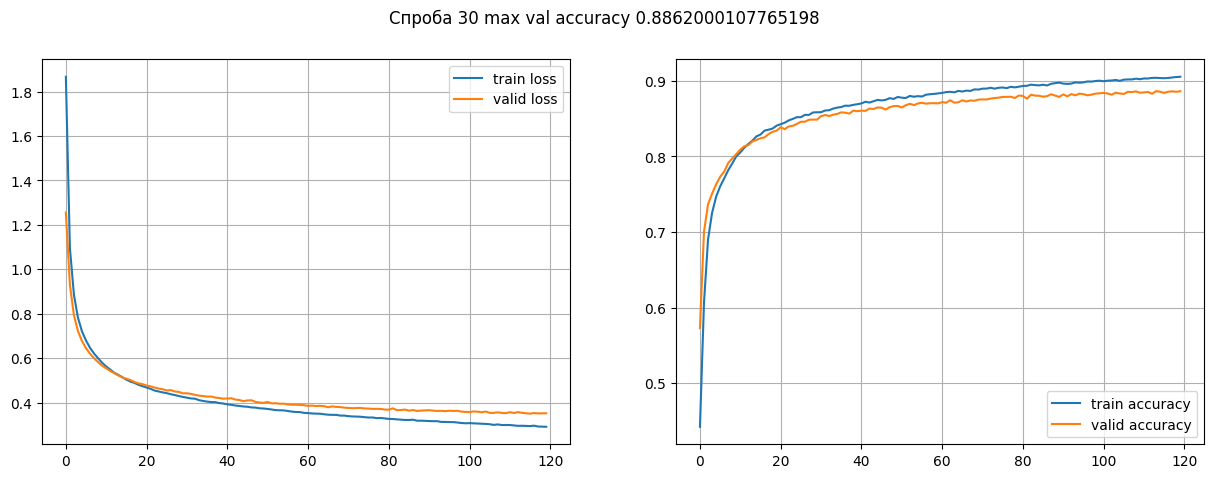

INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


INFO:tensorflow:Assets written to: best_model_31\assets


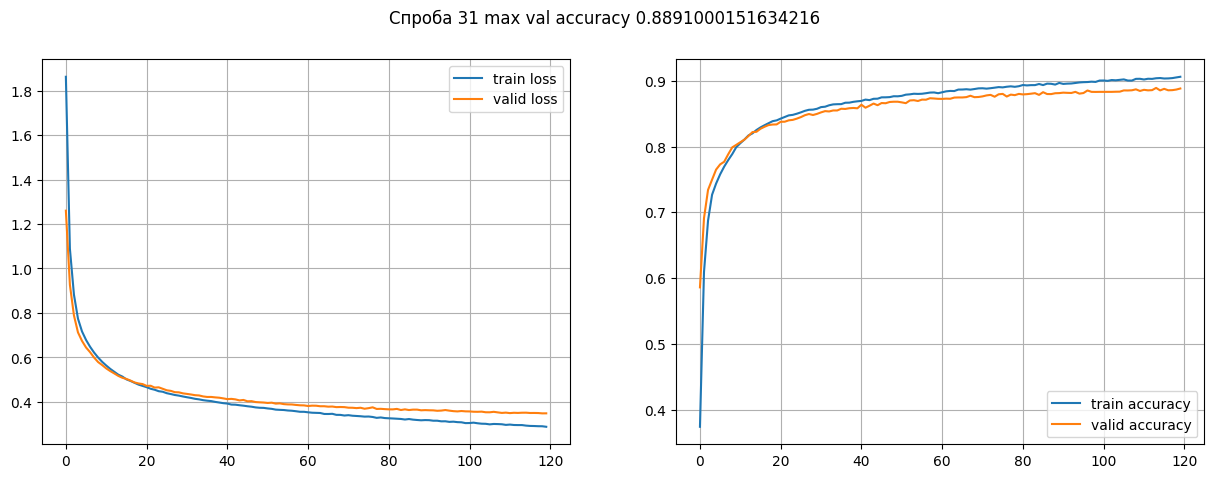

INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


INFO:tensorflow:Assets written to: best_model_32\assets


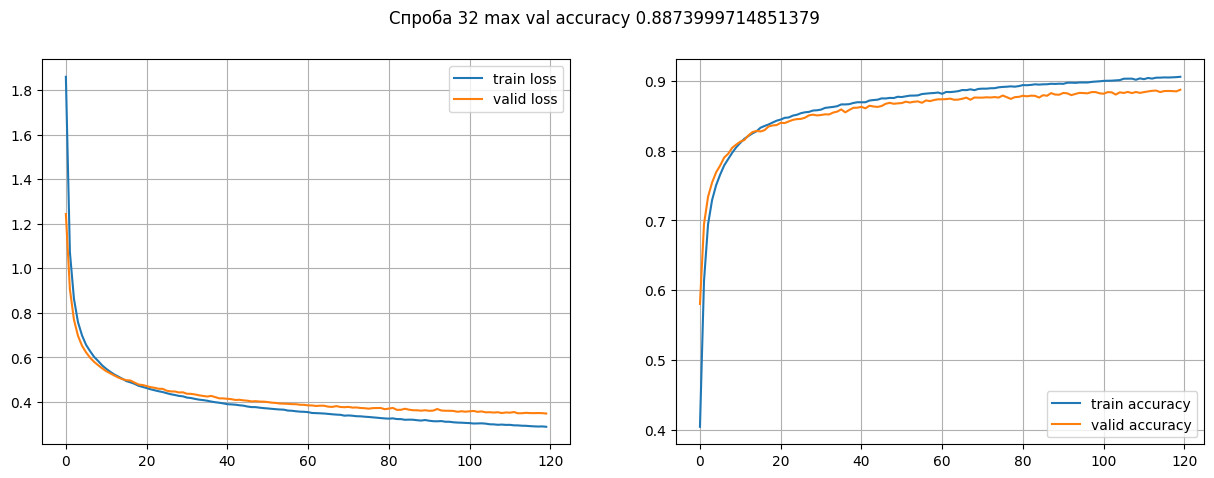

INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


INFO:tensorflow:Assets written to: best_model_33\assets


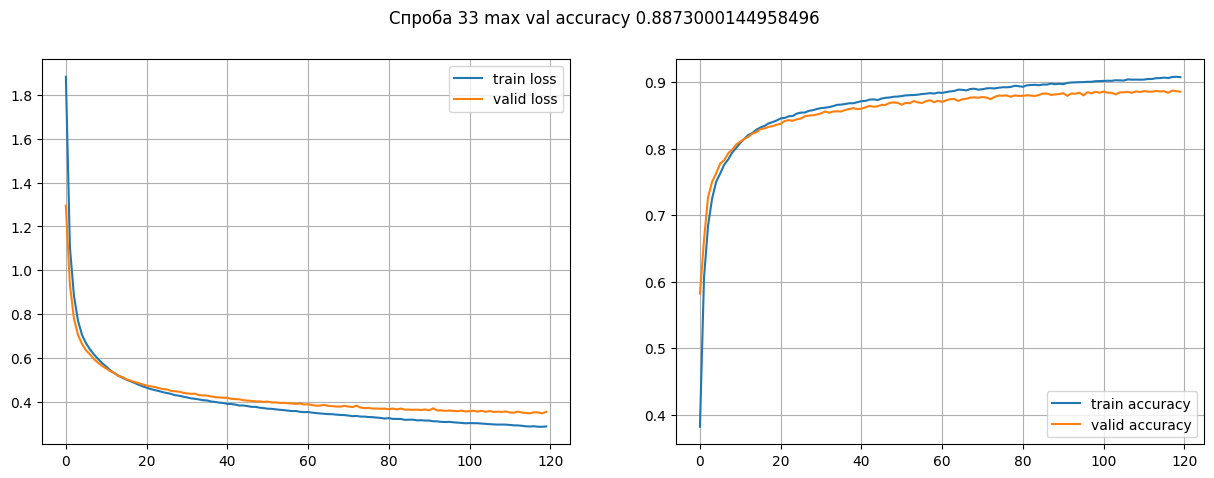

INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


INFO:tensorflow:Assets written to: best_model_34\assets


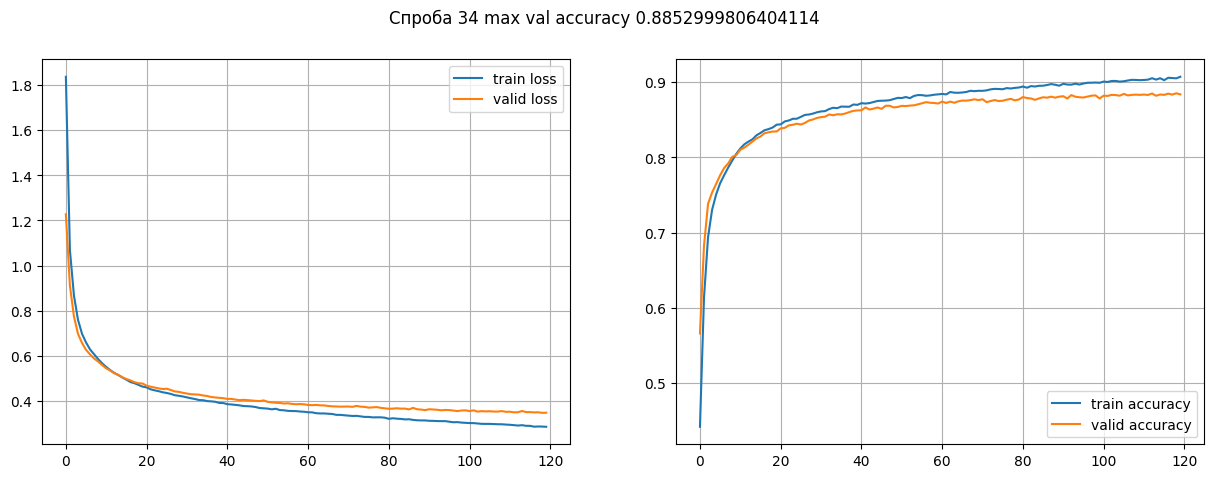

INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


INFO:tensorflow:Assets written to: best_model_35\assets


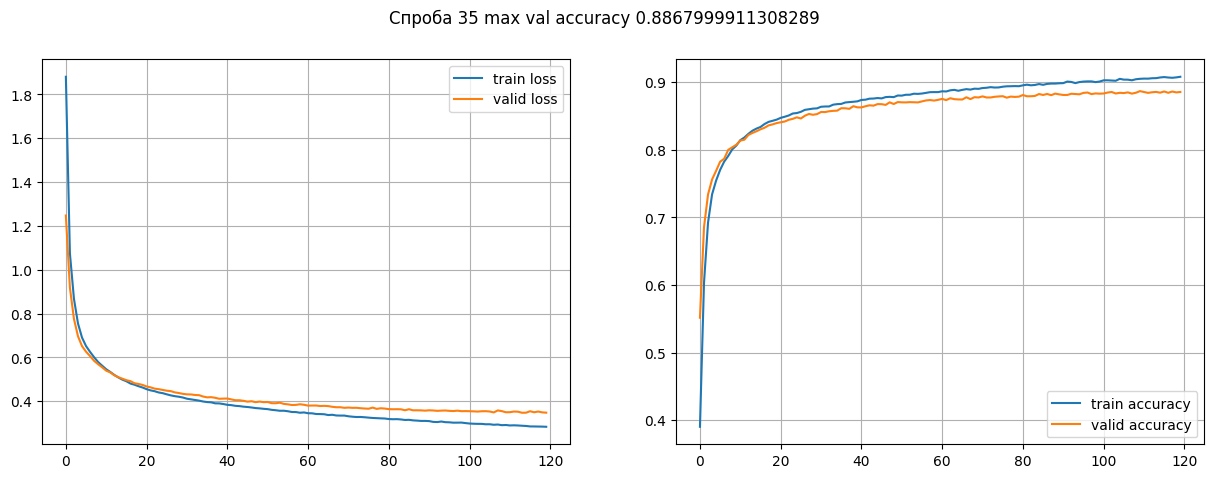

INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


INFO:tensorflow:Assets written to: best_model_36\assets


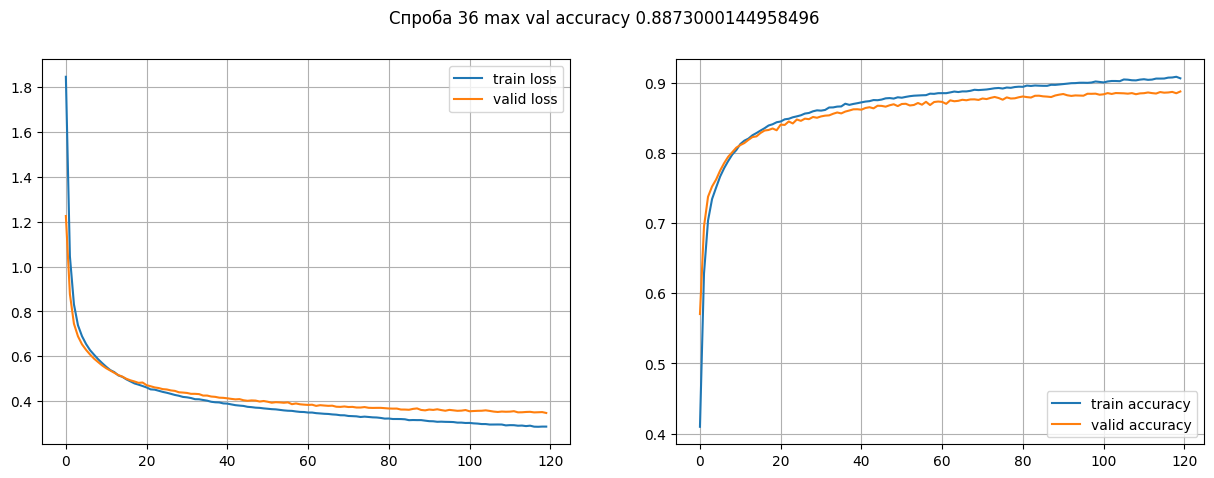

INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


INFO:tensorflow:Assets written to: best_model_37\assets


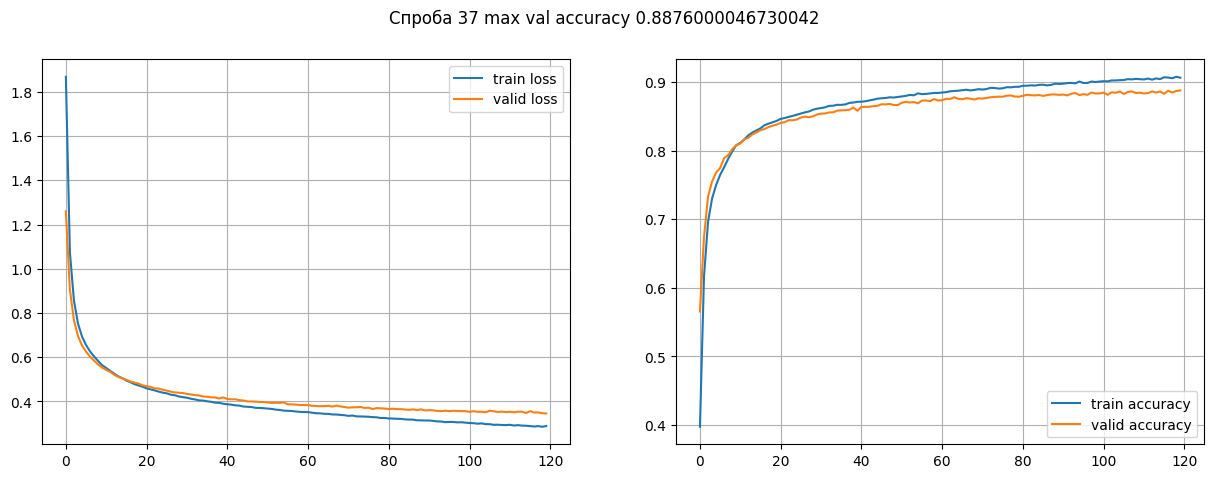

INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


INFO:tensorflow:Assets written to: best_model_38\assets


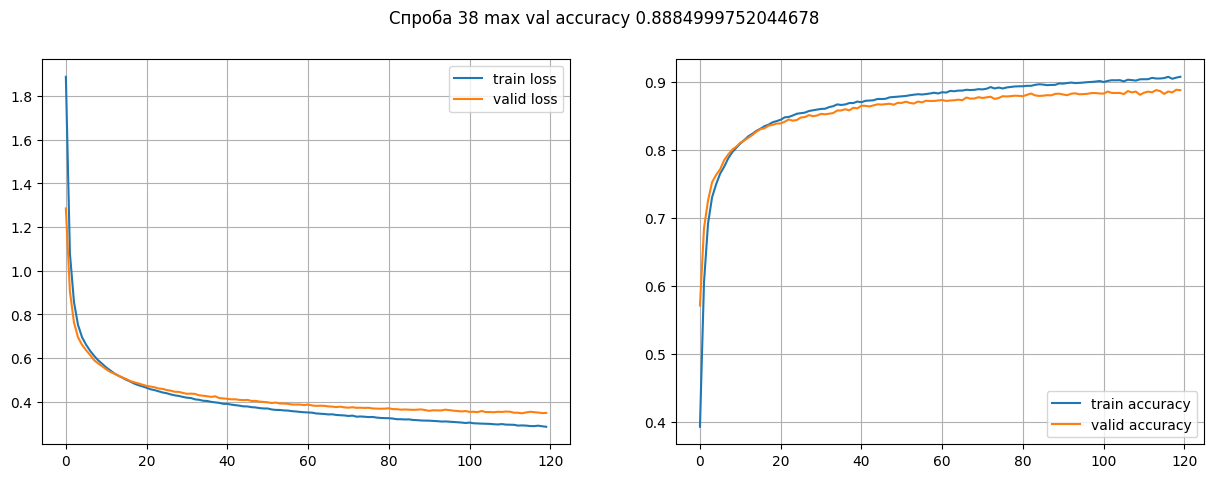

INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


INFO:tensorflow:Assets written to: best_model_39\assets


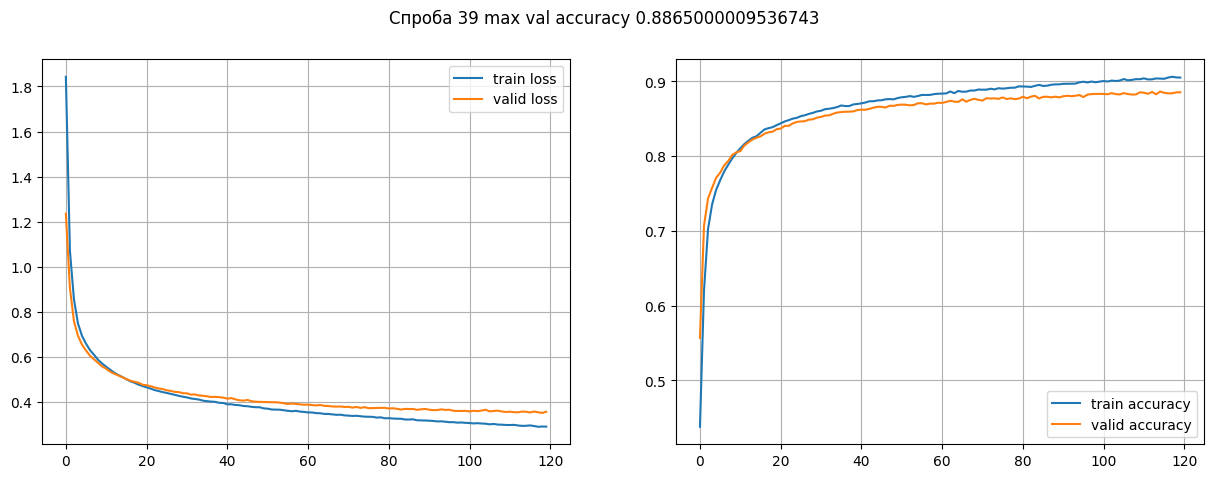

INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


INFO:tensorflow:Assets written to: best_model_40\assets


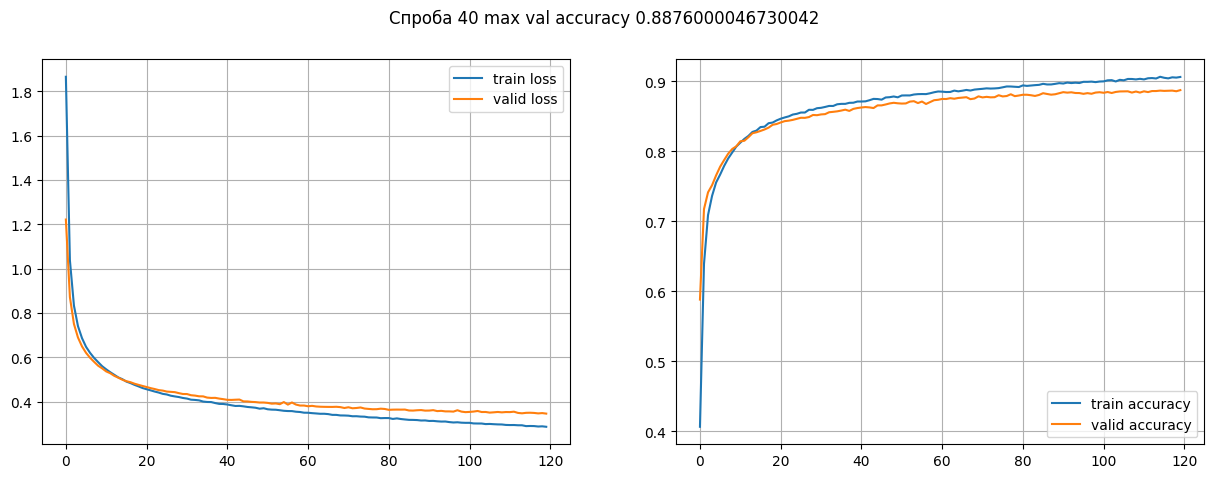

INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


INFO:tensorflow:Assets written to: best_model_41\assets


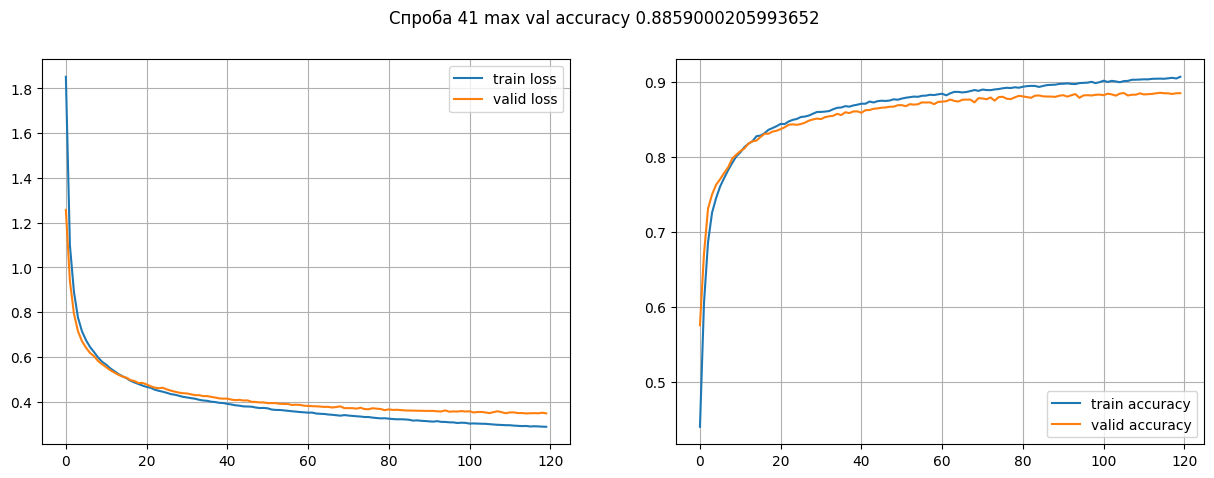

INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


INFO:tensorflow:Assets written to: best_model_42\assets


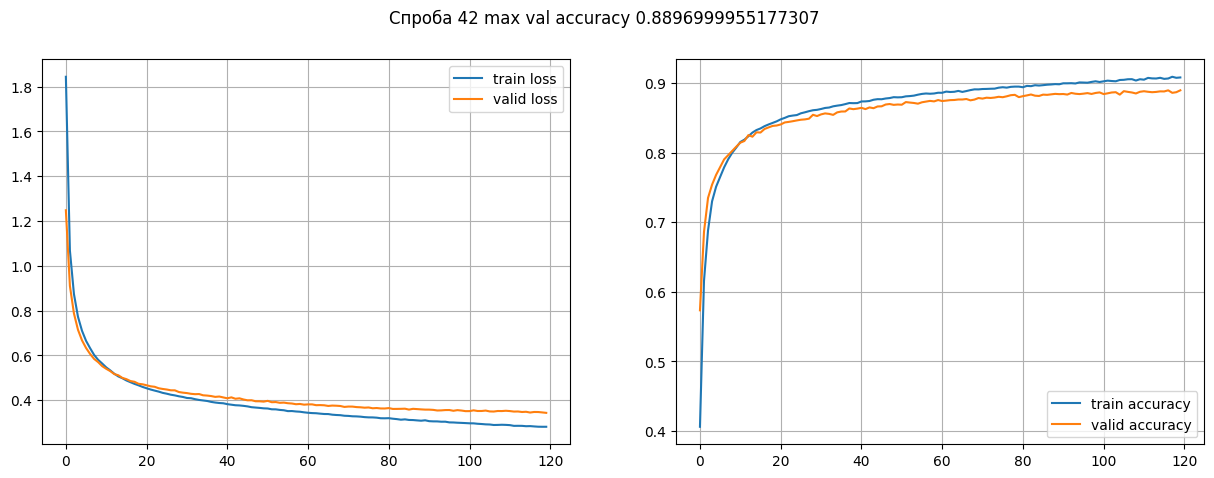

INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


INFO:tensorflow:Assets written to: best_model_43\assets


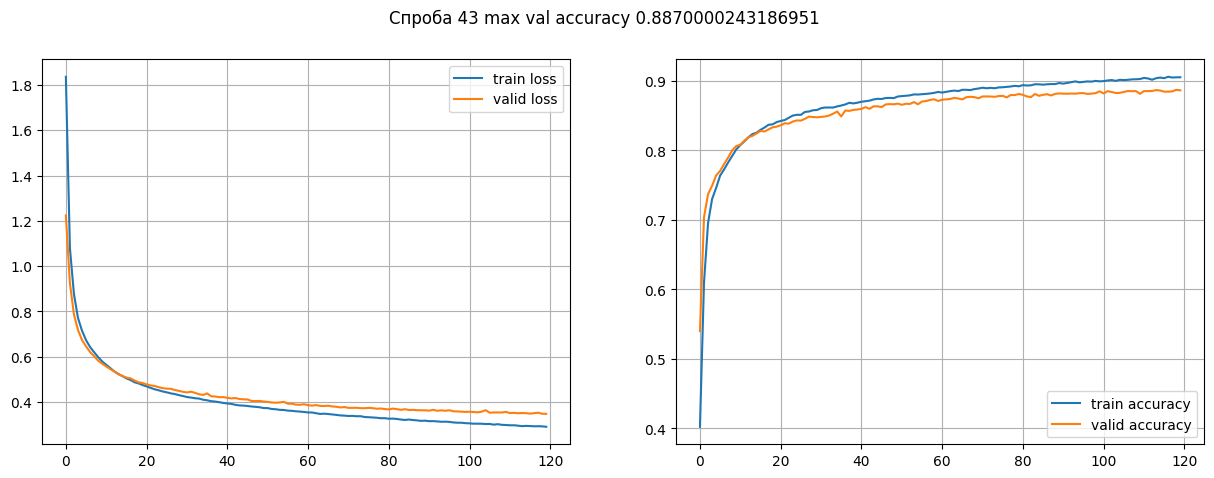

INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


INFO:tensorflow:Assets written to: best_model_44\assets


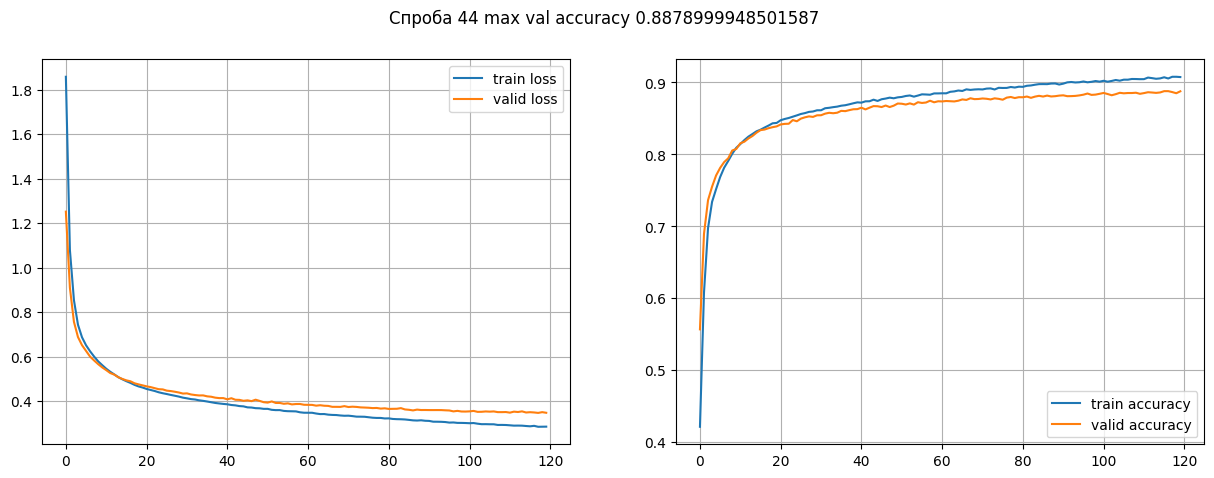

INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


INFO:tensorflow:Assets written to: best_model_45\assets


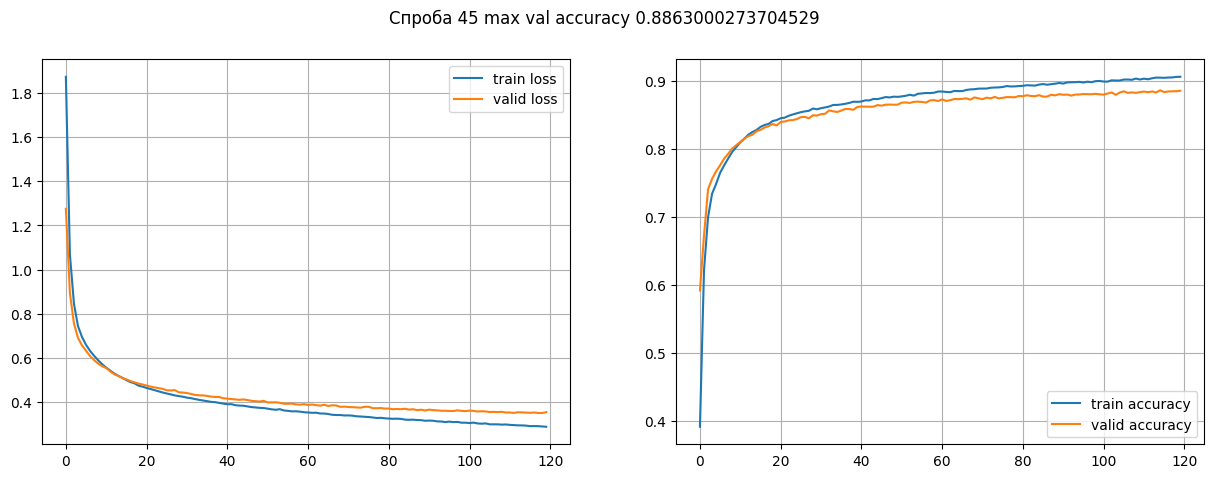

INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


INFO:tensorflow:Assets written to: best_model_46\assets


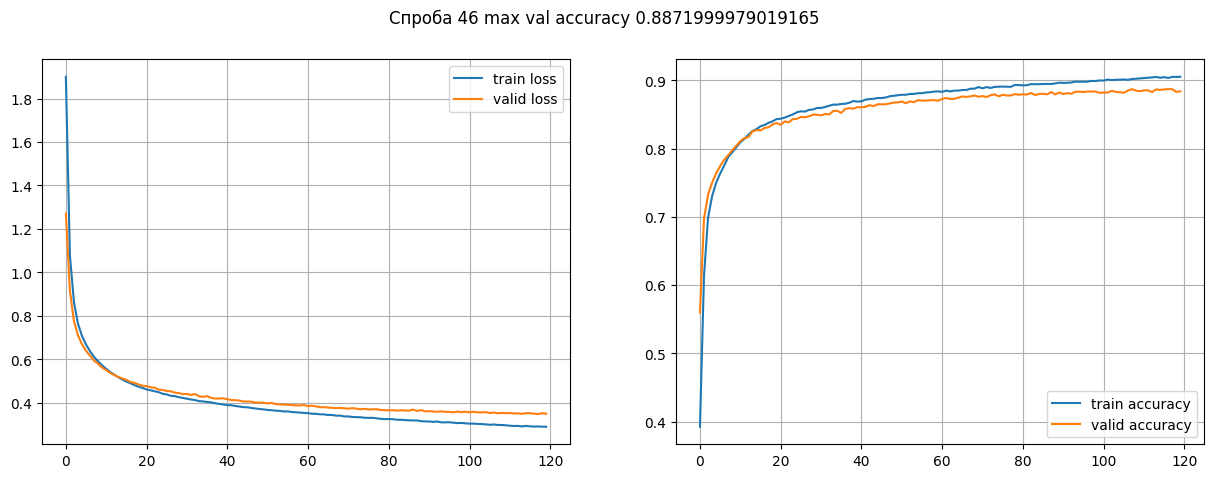

INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


INFO:tensorflow:Assets written to: best_model_47\assets


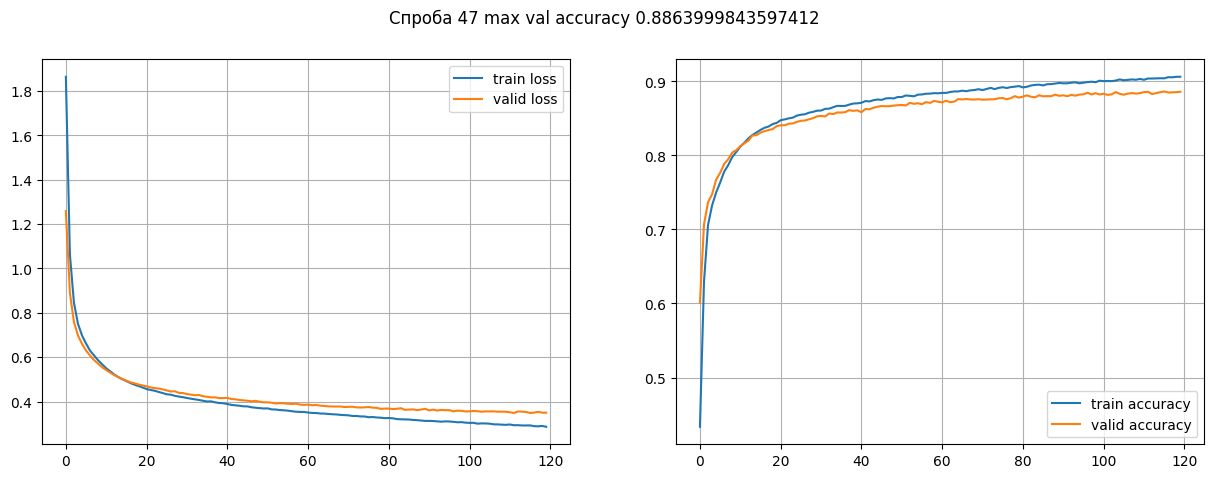

INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


INFO:tensorflow:Assets written to: best_model_48\assets


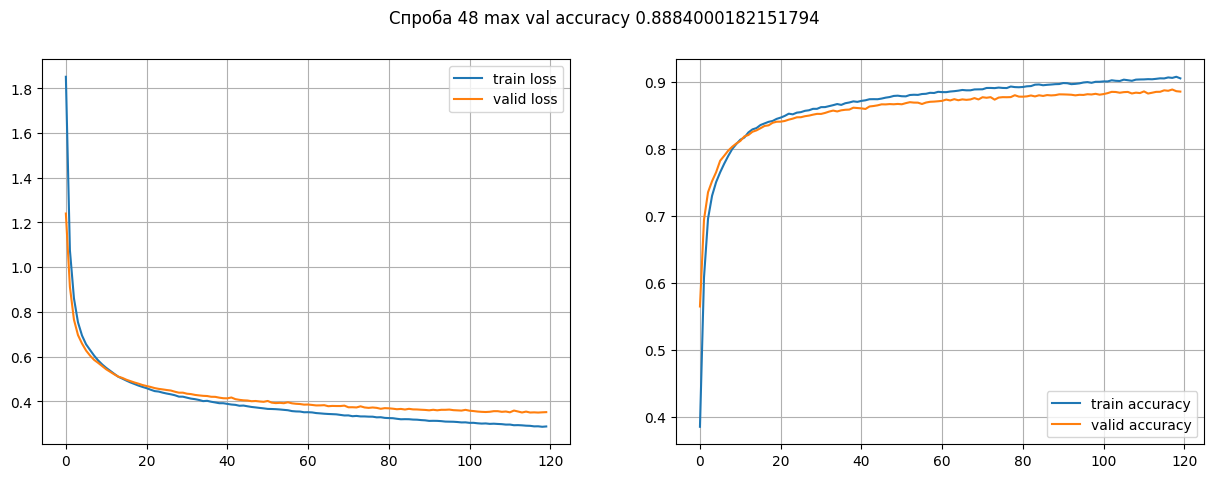

INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


INFO:tensorflow:Assets written to: best_model_49\assets


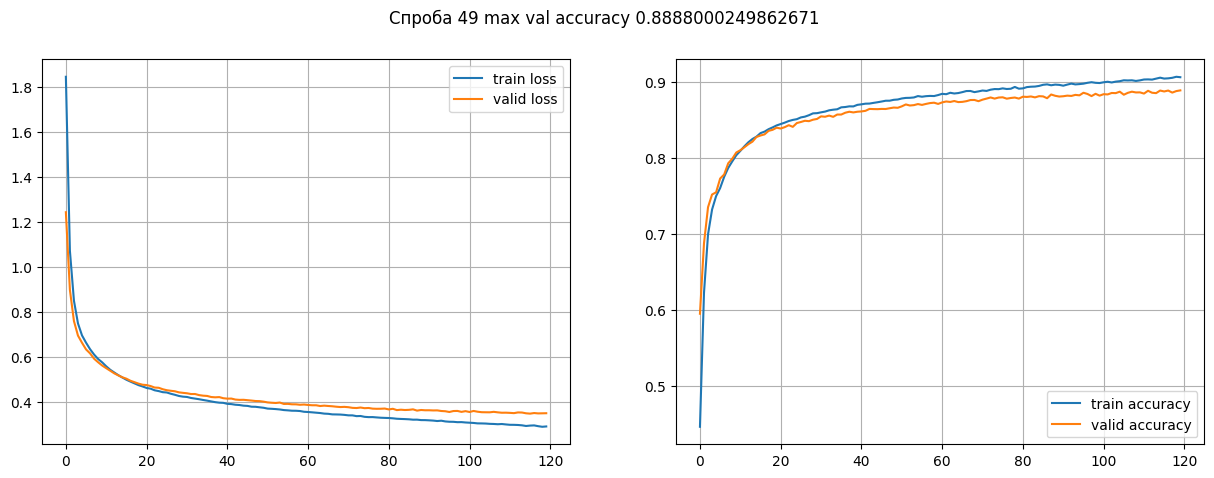

In [100]:
best_model = {
    "model" : None,
    "history" : None,
    "accuracy" : 0,
    "step" : 0
}

one_hot_Y = tf.one_hot(train_Y, 10)

for i in range(50):
    cur_model = Sequential()

    cur_model.add(Dense(14*14, "relu", input_shape = (28*28,), kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-6, l2=1e-6)))
    cur_model.add(Dropout(0.3))
    cur_model.add(Dense(7*7, "relu"))
    cur_model.add(Dense(10, "softmax"))

    cur_model.compile(optimizer=AdamW(learning_rate=0.001), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

    callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"best_model_{i}", save_best_only=True, verbose=0)

    cur_history = cur_model.fit(train_X, one_hot_Y, validation_data=(test_X, test_Y), batch_size=500, epochs=120, callbacks=[callback_save], verbose=0)

    present_histiry(f"Спроба {i}", cur_history)

    if best_model["accuracy"] < max(cur_history.history["val_categorical_accuracy"]):
        best_model["accuracy"] = max(cur_history.history["val_categorical_accuracy"])
        best_model["step"] = i
        best_model["history"] = cur_history
        best_model["model"] = cur_model

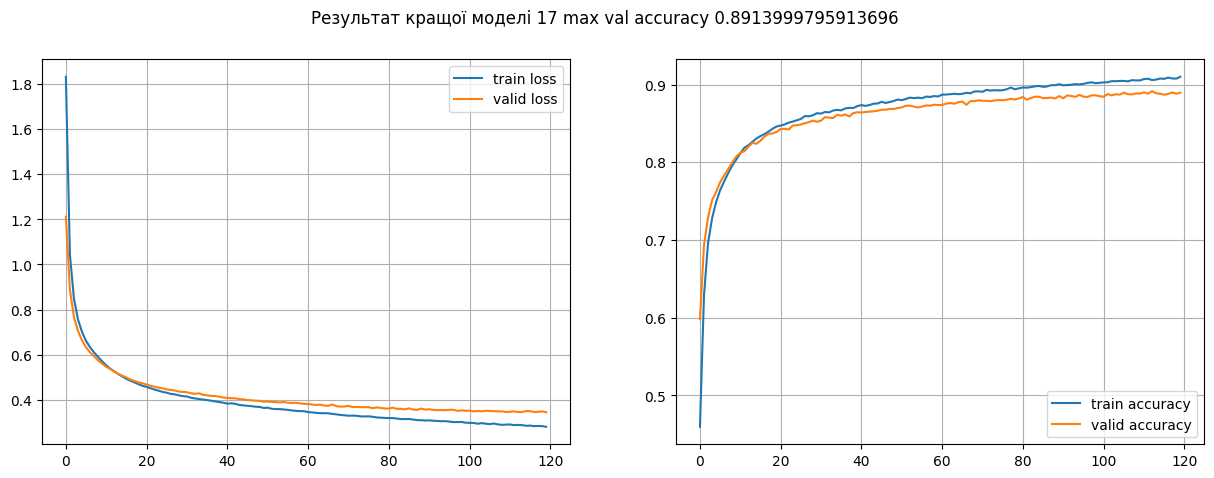

In [101]:
present_histiry(f"Результат кращої моделі {best_model['step']}", best_model["history"])

Спробуємо ще довчити обрану модель

In [104]:
i = 142
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"best_model_{i}", save_best_only=True, verbose=0, monitor="val_categorical_accuracy")
cur_history = best_model["model"].fit(train_X, one_hot_Y, validation_data=(test_X, test_Y), batch_size=250, epochs=120, callbacks=[callback_save], verbose=1)

Epoch 1/120
240/240 [==============================] - ETA: 0s - loss: 0.2411 - categorical_accuracy: 0.9231INFO:tensorflow:Assets written to: best_model_142\assets


INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 46ms/step - loss: 0.2411 - categorical_accuracy: 0.9231 - val_loss: 0.3429 - val_categorical_accuracy: 0.8933
Epoch 2/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2390 - categorical_accuracy: 0.9239 - val_loss: 0.3458 - val_categorical_accuracy: 0.8903
Epoch 3/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2384 - categorical_accuracy: 0.9228 - val_loss: 0.3478 - val_categorical_accuracy: 0.8905
Epoch 4/120
239/240 [============================>.] - ETA: 0s - loss: 0.2352 - categorical_accuracy: 0.9248INFO:tensorflow:Assets written to: best_model_142\assets


INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 46ms/step - loss: 0.2351 - categorical_accuracy: 0.9250 - val_loss: 0.3381 - val_categorical_accuracy: 0.8949
Epoch 5/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2376 - categorical_accuracy: 0.9235 - val_loss: 0.3458 - val_categorical_accuracy: 0.8924
Epoch 6/120
240/240 [==============================] - 10s 42ms/step - loss: 0.2383 - categorical_accuracy: 0.9237 - val_loss: 0.3417 - val_categorical_accuracy: 0.8932
Epoch 7/120
239/240 [============================>.] - ETA: 0s - loss: 0.2361 - categorical_accuracy: 0.9239INFO:tensorflow:Assets written to: best_model_142\assets


INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 12s 48ms/step - loss: 0.2359 - categorical_accuracy: 0.9240 - val_loss: 0.3410 - val_categorical_accuracy: 0.8956
Epoch 8/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2355 - categorical_accuracy: 0.9252 - val_loss: 0.3420 - val_categorical_accuracy: 0.8941
Epoch 9/120
240/240 [==============================] - 11s 45ms/step - loss: 0.2335 - categorical_accuracy: 0.9246 - val_loss: 0.3413 - val_categorical_accuracy: 0.8938
Epoch 10/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2352 - categorical_accuracy: 0.9241 - val_loss: 0.3403 - val_categorical_accuracy: 0.8952
Epoch 11/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2343 - categorical_accuracy: 0.9259 - val_loss: 0.3463 - val_categorical_accuracy: 0.8936
Epoch 12/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2371 - categorical_accuracy: 0.9247 - val_loss: 0.3453 - val_categorical_accuracy: 0.

INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 45ms/step - loss: 0.2317 - categorical_accuracy: 0.9262 - val_loss: 0.3411 - val_categorical_accuracy: 0.8960
Epoch 15/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2316 - categorical_accuracy: 0.9259 - val_loss: 0.3437 - val_categorical_accuracy: 0.8928
Epoch 16/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2304 - categorical_accuracy: 0.9268 - val_loss: 0.3438 - val_categorical_accuracy: 0.8958
Epoch 17/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2324 - categorical_accuracy: 0.9261 - val_loss: 0.3433 - val_categorical_accuracy: 0.8933
Epoch 18/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2309 - categorical_accuracy: 0.9258 - val_loss: 0.3464 - val_categorical_accuracy: 0.8928
Epoch 19/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2319 - categorical_accuracy: 0.9261 - val_loss: 0.3441 - val_categorical_accuracy: 

INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 45ms/step - loss: 0.2245 - categorical_accuracy: 0.9297 - val_loss: 0.3393 - val_categorical_accuracy: 0.8970
Epoch 29/120
240/240 [==============================] - 9s 39ms/step - loss: 0.2245 - categorical_accuracy: 0.9278 - val_loss: 0.3444 - val_categorical_accuracy: 0.8932
Epoch 30/120
240/240 [==============================] - 9s 39ms/step - loss: 0.2230 - categorical_accuracy: 0.9302 - val_loss: 0.3451 - val_categorical_accuracy: 0.8955
Epoch 31/120
240/240 [==============================] - 9s 39ms/step - loss: 0.2249 - categorical_accuracy: 0.9295 - val_loss: 0.3459 - val_categorical_accuracy: 0.8963
Epoch 32/120
239/240 [============================>.] - ETA: 0s - loss: 0.2247 - categorical_accuracy: 0.9290INFO:tensorflow:Assets written to: best_model_142\assets


INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 45ms/step - loss: 0.2246 - categorical_accuracy: 0.9291 - val_loss: 0.3378 - val_categorical_accuracy: 0.8971
Epoch 33/120
240/240 [==============================] - 9s 39ms/step - loss: 0.2197 - categorical_accuracy: 0.9306 - val_loss: 0.3466 - val_categorical_accuracy: 0.8942
Epoch 34/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2236 - categorical_accuracy: 0.9290 - val_loss: 0.3486 - val_categorical_accuracy: 0.8934
Epoch 35/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2224 - categorical_accuracy: 0.9285 - val_loss: 0.3486 - val_categorical_accuracy: 0.8933
Epoch 36/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2203 - categorical_accuracy: 0.9291 - val_loss: 0.3557 - val_categorical_accuracy: 0.8923
Epoch 37/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2211 - categorical_accuracy: 0.9300 - val_loss: 0.3457 - val_categorical_accuracy: 0

INFO:tensorflow:Assets written to: best_model_142\assets


240/240 [==============================] - 11s 45ms/step - loss: 0.2155 - categorical_accuracy: 0.9322 - val_loss: 0.3439 - val_categorical_accuracy: 0.8982
Epoch 51/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2138 - categorical_accuracy: 0.9330 - val_loss: 0.3446 - val_categorical_accuracy: 0.8957
Epoch 52/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2116 - categorical_accuracy: 0.9338 - val_loss: 0.3487 - val_categorical_accuracy: 0.8950
Epoch 53/120
240/240 [==============================] - 10s 40ms/step - loss: 0.2151 - categorical_accuracy: 0.9328 - val_loss: 0.3475 - val_categorical_accuracy: 0.8959
Epoch 54/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2135 - categorical_accuracy: 0.9333 - val_loss: 0.3458 - val_categorical_accuracy: 0.8933
Epoch 55/120
240/240 [==============================] - 10s 41ms/step - loss: 0.2125 - categorical_accuracy: 0.9340 - val_loss: 0.3541 - val_categorical_accuracy: 

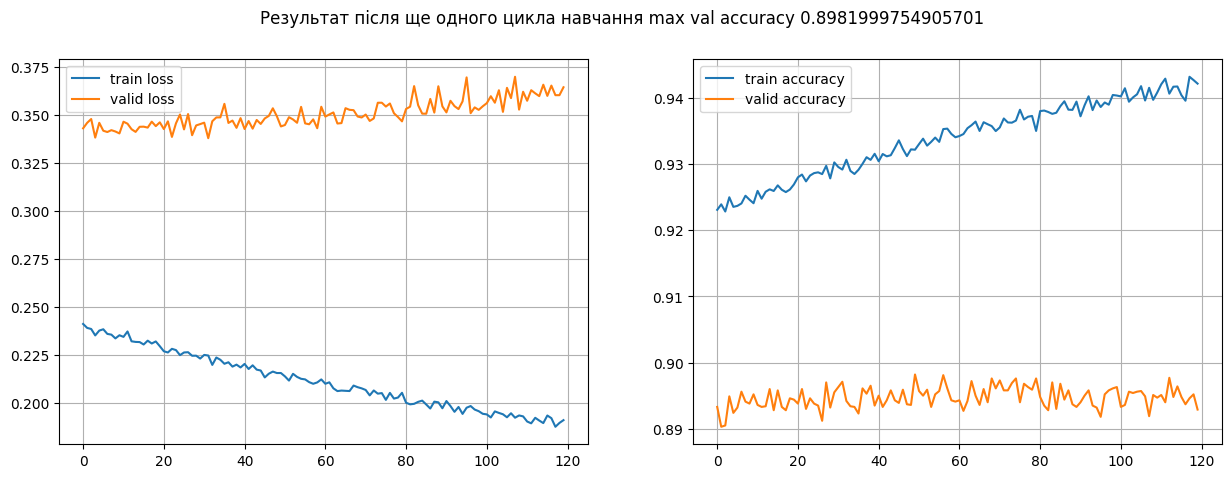

In [105]:
present_histiry(f"Результат після ще одного цикла навчання", cur_history)

Валідаційні втрати мають тенденцію до збільшення, що свідчить про перенавчання моделі. Спробуємо переломити тенденцію, змінивши розмір пакета

Epoch 1/120
77/77 [==============================] - ETA: 0s - loss: 0.1729 - categorical_accuracy: 0.9502INFO:tensorflow:Assets written to: best_model_152\assets


INFO:tensorflow:Assets written to: best_model_152\assets


77/77 [==============================] - 9s 113ms/step - loss: 0.1729 - categorical_accuracy: 0.9502 - val_loss: 0.3527 - val_categorical_accuracy: 0.8986
Epoch 2/120
77/77 [==============================] - 8s 98ms/step - loss: 0.1701 - categorical_accuracy: 0.9513 - val_loss: 0.3536 - val_categorical_accuracy: 0.8951
Epoch 3/120
77/77 [==============================] - 7s 97ms/step - loss: 0.1672 - categorical_accuracy: 0.9520 - val_loss: 0.3561 - val_categorical_accuracy: 0.8951
Epoch 4/120
77/77 [==============================] - 8s 99ms/step - loss: 0.1686 - categorical_accuracy: 0.9518 - val_loss: 0.3557 - val_categorical_accuracy: 0.8968
Epoch 5/120
77/77 [==============================] - 7s 97ms/step - loss: 0.1668 - categorical_accuracy: 0.9524 - val_loss: 0.3586 - val_categorical_accuracy: 0.8965
Epoch 6/120
77/77 [==============================] - 7s 95ms/step - loss: 0.1683 - categorical_accuracy: 0.9521 - val_loss: 0.3579 - val_categorical_accuracy: 0.8965
Epoch 7/120
77/

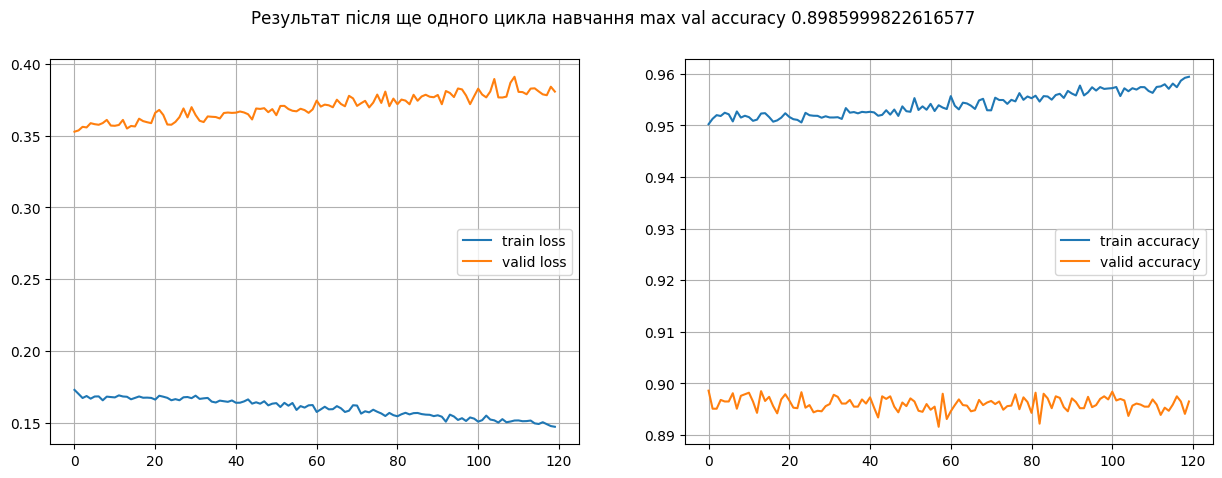

In [106]:
i = 152
callback_save = tf.keras.callbacks.ModelCheckpoint(filepath=f"best_model_{i}", save_best_only=True, verbose=0, monitor="val_categorical_accuracy")
cur_history = best_model["model"].fit(train_X, one_hot_Y, validation_data=(test_X, test_Y), batch_size=28*28, epochs=120, callbacks=[callback_save], verbose=1)
present_histiry(f"Результат після ще одного цикла навчання", cur_history)

Стратифікація даних допомагає стартувати з добрих показників, але при достатній кількості епох це не має значення.

Регуляризація захищає від перенавчання, але віддаляє від оптимального рішення.

Вибір оптимізатора, якщо він в принципі підходить під даний тип задач, може скоротити час навчання і наблизити до оптимального рішення.

Функції активації суттєво впливають на межі навчання моделі, є сенс перебирати їх поки нема досвіду, а потім, можливо, навчишся вгадувати.

Розмір пакету і кількість епох впливають на загальний час навчання моделі, підбираються, поки що, шляхом дослідів.

Ранню зупинку, на мою думку, однозначно варто використовувати для оцінки потенціалу моделі. При остаточному тренуванні слід використовувати обережно, особливо якщо застосовується регуляризація.

Стосовно складності моделей. Занадто прості моделі дають очіковано низьку точність. Занадто складні моделі, мало того що довго вчаться і зжерають безліч ресурсів, теж не відрізняються особливою точністю. Десь читав рекомендацію, що модель повинна мати достатній мінімум шарів та нейронів.

Якщо експеримент не слід відтворювати - не лізь в налаштування рандома.

Перемішування даних і початкові параметри вагів та базисів мають суттєве значення на результат навчання моделі, вони можуть як перескочити локальні мінімуми, так і посадити в калюжу.